## Load Data

In [6]:
import pandas as pd
import numpy as np
import os
os.chdir("D:\\diệu ổ D\\MBS\\model_predict_who_mr_loan_next_m\\version_2\\Data")

df_base = pd.read_csv("base_margin_data_t9.csv")
df_metric = pd.read_csv("score_metric_data_t9.csv")



In [7]:
df= pd.merge(df_base, df_metric, on='master_account', how='inner')




In [8]:
df.shape

(62479, 61)

In [9]:
df.columns

Index(['master_account', 'loan_label_next', 'customer_category', 'Age',
       'open_date', 'months_since_open', 'avg_nav_cash_12m', 'avg_nav_ck_12m',
       'total_trading_amount_12m', 'total_cash_in_12m', 'total_cash_out_12m',
       'trading_count_12m', 'login_count_12m', 'nav_ck_start_12m',
       'nav_ck_end_12m', 'unique_shares_12m', 'order_buy_12m',
       'order_sell_12m', 'total_buy_12m', 'total_sell_12m', 'avg_nav_cash_3m',
       'avg_nav_ck_3m', 'total_trading_amount_3m', 'total_cash_in_3m',
       'total_cash_out_3m', 'trading_count_3m', 'login_count_3m',
       'nav_ck_start_3m', 'nav_ck_end_3m', 'unique_shares_3m', 'order_buy_3m',
       'order_sell_3m', 'total_buy_3m', 'total_sell_3m', 'avg_nav_cash_2w',
       'avg_nav_ck_2w', 'total_trading_amount_2w', 'total_cash_in_2w',
       'total_cash_out_2w', 'trading_count_2w', 'login_count_2w',
       'nav_ck_start_2w', 'nav_ck_end_2w', 'unique_shares_2w', 'order_buy_2w',
       'order_sell_2w', 'total_buy_2w', 'total_sell_2w

In [10]:
df = df[df['customer_category'] != 'Other']
df.loan_label_next.value_counts()

loan_label_next
0    52687
1     9622
Name: count, dtype: int64

## Feature Selection

In [11]:
# login_ratio theo tháng

df['login_ratio_3m']  = df['login_count_3m']  / 60
df['login_ratio_12m'] = df['login_count_12m'] / 240
df['login_ratio_2w']  = df['login_count_2w']  / 10

df['login_trend'] = df['login_count_3m'] / df['login_count_12m']

In [12]:





# --- FLOW RATIOS (month windows) ---
# create safe denominators using fillna(0)+eps

df = df.fillna(0)

df['flow_ratio_3m']  = (df['total_buy_3m']) / (df['total_sell_3m'])
df['flow_ratio_12m'] = (df['total_buy_12m']) / (df['total_sell_12m'])
df['flow_ratio_2w']  = (df['total_buy_2w']) / (df['total_sell_2w'])


# -- Buy/Sell Presure --- 
df['buy_sell_pressure_3m']  = (df['total_buy_3m'] - df['total_sell_3m']) / df['total_trading_amount_3m']
df['buy_sell_pressure_12m'] = (df['total_buy_12m'] - df['total_sell_12m']) / df['total_trading_amount_12m']

# -- order ratio ---
df['order_buy_ratio_3m']  = df['order_buy_3m'] / (df['order_buy_3m'] + df['order_sell_3m'])
df['order_buy_ratio_12m'] = df['order_buy_12m'] / (df['order_buy_12m'] + df['order_sell_12m'])
df['order_sell_ratio_3m']  = df['order_sell_3m'] / (df['order_buy_3m'] + df['order_sell_3m'])
df['order_sell_ratio_12m'] = df['order_sell_12m'] / (df['order_buy_12m'] + df['order_sell_12m'])

## -- total_trading_ratio --- 

df['total_buy_ratio_3m']  = df['total_buy_3m'] / df['total_trading_amount_3m']
df['total_buy_ratio_12m'] = df['total_buy_12m'] / df['total_trading_amount_12m']
df['total_sell_ratio_3m']  = df['total_sell_3m'] / df['total_trading_amount_3m']
df['total_sell_ratio_12m'] = df['total_sell_12m'] / df['total_trading_amount_12m']

In [13]:
df = df.drop(columns=['market_volatility_2w'],)

In [14]:


# --- TURNOVER RATIOS (theo tháng) ---

df['turnover_3m']  = df['total_trading_amount_3m']  / (df['avg_nav_ck_3m']  + df['avg_nav_cash_3m'])
df['turnover_12m'] = df['total_trading_amount_12m'] / (df['avg_nav_ck_12m'] + df['avg_nav_cash_12m'])



In [15]:
#(Tỷ lệ tiền mặt/Tổng tài sản):

df['Cash_Drag_Ratio_3m'] = df['avg_nav_cash_3m'] / (df['avg_nav_ck_3m'] + df['avg_nav_cash_3m'])
df['Cash_Drag_Ratio_12m'] = df['avg_nav_cash_12m'] / (df['avg_nav_ck_12m'] + df['avg_nav_cash_12m'])



# (Bùng nổ giao dịch)
#df['Trading_Intensity_Surge'] = df['trading_count_3m']/(df['trading_count_12m'] / 4)
df['Trading_Intensity_Surge'] = df['trading_count_3m'] / df['trading_count_12m']
df['Speculative_Index'] = df['turnover_3m'] / df['turnover_12m']

df['asset_allocation_stock_ratio_3m'] = df['avg_nav_ck_3m'] / (df['avg_nav_ck_3m'] + df['avg_nav_cash_3m'])
df['asset_allocation_stock_ratio_12m'] = df['avg_nav_ck_12m'] / (df['avg_nav_ck_12m'] + df['avg_nav_cash_12m'])

#df['net_flow_trend'] = df['net_cash_flow_3m'] - (df['net_cash_flow_12m'] / 4)

#df['order_buy_sell_pressure_3m'] = df['order_buy_3m'] / (df['order_sell_3m'] + 1e-6)
#df['is_loss_chasing'] = ((df['profit_ratio_3m'] < 0) & (df['trading_count_3m'] > df['trading_count_12m']/4)).astype(int)


df['net_buy_pressure_3m'] = (df['order_buy_3m'] - df['order_sell_3m']) / (df['order_buy_3m'] + df['order_sell_3m'])




In [17]:
df.columns

Index(['master_account', 'loan_label_next', 'customer_category', 'Age',
       'open_date', 'months_since_open', 'avg_nav_cash_12m', 'avg_nav_ck_12m',
       'total_trading_amount_12m', 'total_cash_in_12m', 'total_cash_out_12m',
       'trading_count_12m', 'login_count_12m', 'nav_ck_start_12m',
       'nav_ck_end_12m', 'unique_shares_12m', 'order_buy_12m',
       'order_sell_12m', 'total_buy_12m', 'total_sell_12m', 'avg_nav_cash_3m',
       'avg_nav_ck_3m', 'total_trading_amount_3m', 'total_cash_in_3m',
       'total_cash_out_3m', 'trading_count_3m', 'login_count_3m',
       'nav_ck_start_3m', 'nav_ck_end_3m', 'unique_shares_3m', 'order_buy_3m',
       'order_sell_3m', 'total_buy_3m', 'total_sell_3m', 'avg_nav_cash_2w',
       'avg_nav_ck_2w', 'total_trading_amount_2w', 'total_cash_in_2w',
       'total_cash_out_2w', 'trading_count_2w', 'login_count_2w',
       'nav_ck_start_2w', 'nav_ck_end_2w', 'unique_shares_2w', 'order_buy_2w',
       'order_sell_2w', 'total_buy_2w', 'total_sell_2w

### Handle Bin Data

In [18]:
import pandas as pd
import numpy as np

def process_age_binning(df, age_col='Age'):
    """
    Hàm phân loại độ tuổi thành các nhóm Label Encoding:
    0: < 15 hoặc > 100 (Nhóm ngoại lai/Trẻ em)
    1: 15 - 30 (Thanh niên)
    2: 30 - 45 (Trung niên - Lao động chính)
    3: 45 - 60 (Tiền hưu trí)
    4: 60 - 75 (Hưu trí)
    5: 75 - 100 (Cao tuổi)
    """
    # 1. Xử lý dữ liệu lỗi/null trước (nếu có)
    # Fill NaN bằng 0 (hoặc median tùy bạn), ở đây tạm coi NaN là nhóm 0
    age_data = df[age_col].fillna(0)
    
    # 2. Định nghĩa các điều kiện (Conditions)
    conditions = [
        (age_data < 15) | (age_data > 100),   # Nhóm 0: Dưới 15 hoặc trên 100
        (age_data >= 15) & (age_data < 30),   # Nhóm 1: 15 đến dưới 30
        (age_data >= 30) & (age_data < 45),   # Nhóm 2: 30 đến dưới 45
        (age_data >= 45) & (age_data < 60),   # Nhóm 3: 45 đến dưới 60 (Lưu ý: Đã nối liền mạch 50->60)
        (age_data >= 60) & (age_data < 75),   # Nhóm 4: 60 đến dưới 75
        (age_data >= 75) & (age_data <= 100)  # Nhóm 5: 75 đến 100
    ]
    
    # 3. Định nghĩa các nhãn tương ứng (Choices)
    choices = [0, 1, 2, 3, 4, 5]
    
    # 4. Tạo cột mới bằng np.select (Cực nhanh)
    # default=0: Những trường hợp lọt khe (nếu có) sẽ về 0 hết
    df['age_group'] = np.select(conditions, choices, default=0)
    
    return df



# Áp dụng hàm
df = process_age_binning(df, age_col='Age')



In [19]:
import pandas as pd
import numpy as np

def process_tenure_binning(df, tenure_col='months_since_open'):
    """
    Phân nhóm thâm niên khách hàng (Tenure Binning):
    0: < 24 tháng (Junior - Dưới 2 năm)
    1: 24 - 48 tháng (Growth - 2 đến 4 năm) -> Nhóm phổ biến nhất (Median ~46)
    2: 48 - 96 tháng (Mature - 4 đến 8 năm)
    3: 96 - 180 tháng (Veteran - 8 đến 15 năm)
    4: >= 180 tháng (Ancient - Trên 15 năm)
    """
    # 1. Xử lý null (nếu có) -> Gán tạm vào nhóm 0 hoặc median
    # Ở đây mình fill 0 để an toàn
    col_data = df[tenure_col].fillna(0)
    
    # 2. Định nghĩa điều kiện
    conditions = [
        (col_data < 24),                     # Nhóm 0: Dưới 2 năm
        (col_data >= 24) & (col_data < 48),  # Nhóm 1: 2 - 4 năm
        (col_data >= 48) & (col_data < 96),  # Nhóm 2: 4 - 8 năm
        (col_data >= 96) & (col_data < 180), # Nhóm 3: 8 - 15 năm
        (col_data >= 180)                    # Nhóm 4: Trên 15 năm
    ]
    
    # 3. Định nghĩa nhãn
    choices = [0, 1, 2, 3, 4]
    
    # 4. Tạo cột mới
    df['tenure_group'] = np.select(conditions, choices, default=0)
    
    return df


# Chạy hàm
df = process_tenure_binning(df)


# Kiểm tra phân phối (nếu chạy trên data thật)
# print(df['tenure_group'].value_counts().sort_index())

df = df.drop(columns="months_since_open")

In [20]:
df.tenure_group.value_counts().sort_index()

tenure_group
0    10456
1    21203
2    22218
3     5771
4     2661
Name: count, dtype: int64

In [21]:
import pandas as pd
import numpy as np

def process_shares_binning(df, cols=['unique_shares_3m', 'unique_shares_12m', 'unique_shares_2w']):
    """
    Phân nhóm độ đa dạng danh mục cho nhiều cột cùng lúc.
    Logic binning:
    0: 0 mã
    1: 1 - 3 mã (Sniper)
    2: 4 - 8 mã (Balanced)
    3: 9 - 15 mã (Diversified)
    4: > 15 mã (Spray/Bot)
    """
    # Copy để tránh warning SettingWithCopy nếu df là slice
    df = df.copy()

    for col in cols:
        # Kiểm tra nếu cột tồn tại trong df
        if col not in df.columns:
            print(f"Warning: Cột {col} không tồn tại trong DataFrame.")
            continue

        # 1. Xử lý null -> coi là 0
        col_data = df[col].fillna(0)
        
        # 2. Định nghĩa điều kiện (Chạy riêng cho từng cột)
        conditions = [
            (col_data == 0),                     # Nhóm 0
            (col_data >= 1) & (col_data <= 3),   # Nhóm 1
            (col_data >= 4) & (col_data <= 8),   # Nhóm 2
            (col_data >= 9) & (col_data <= 15),  # Nhóm 3
            (col_data > 15)                      # Nhóm 4
        ]
        
        # 3. Định nghĩa nhãn
        choices = [0, 1, 2, 3, 4]
        
        # 4. Tạo tên cột mới tự động
        # Logic: unique_shares_3m -> portfolio_breadth_group_3m
        new_col_name = col.replace('unique_shares', 'unique_shares')
        
        # 5. Gán giá trị
        df[new_col_name] = np.select(conditions, choices, default=0)
        print(f"-> Đã tạo cột binning: {new_col_name}")

    return df



# Chạy hàm
df = process_shares_binning(df)



-> Đã tạo cột binning: unique_shares_3m
-> Đã tạo cột binning: unique_shares_12m
-> Đã tạo cột binning: unique_shares_2w


### Drop Columns

In [22]:
def clean_dataframe(df):
    """
    Hàm xóa các cột dữ liệu thô, dữ liệu trùng lặp hoặc ít giá trị dự báo
    để làm gọn DataFrame trước khi đưa vào mô hình.
    """
    cols_to_drop = [
        # --- 1. Nhóm Giao dịch & Dòng tiền thô (Raw Buy/Sell/Cash) ---
        'total_buy_1w', 'total_sell_1w', 'total_cash_in_1w', 'total_cash_out_1w',
        'total_buy_2w', 'total_sell_2w', 'total_cash_in_2w', 'total_cash_out_2w',
        'total_buy_3m', 'total_sell_3m', 'total_cash_in_3m', 'total_cash_out_3m',
        'total_buy_12m', 'total_sell_12m', 'total_cash_in_12m', 'total_cash_out_12m',
        
        # --- 2. Nhóm Login (Đăng nhập) ---
        'login_count_2w', 'login_count_3m', 'login_count_12m',
        'login_ratio_3m', 'login_ratio_6m', 'login_ratio_12m',

        # --- 3. Nhóm Chỉ số 1 Tuần & 2 Tuần (Short-term Noise) ---
        'total_trading_amount_2w', 'trading_count_2w', 
        'avg_nav_ck_2w', 'avg_nav_cash_2w', 'total_nav_1w',
        'nav_ck_start_1w', 'nav_ck_end_1w', 'nav_ck_start_2w', 'nav_ck_end_2w',
        'share_out_2w', 'share_quantity_2w', 'share_pl_pct_2w',
        'order_buy_2w', 'order_sell_2w', 'buying_power_2w',
        'profit_ratio_2w', 'profit_value_2w',
        'flow_ratio_2w', 'turnover_2w', 'twrp_2w', 'twrm_2w',
        'client_return_pct_1w', 'avg_nav_cash_1w',
        
        # --- 4. Nhóm Chỉ số 3M, 6M, 12M (Dư thừa hoặc dùng làm Base) ---
        'avg_nav_cash_3m', 'avg_nav_cash_6m', 'avg_nav_cash_12m',
 #       'avg_nav_ck_6m', 'avg_nav_ck_12m',
        'nav_ck_start_3m', 'nav_ck_end_3m', 'nav_ck_start_12m', 'nav_ck_end_12m',
        'total_trading_amount_6m', #'total_trading_amount_12m',
        'trading_count_6m',
        'share_quantity_3m', 'share_quantity_6m', 'share_quantity_12m',
        'share_out_3m', 'share_out_6m', 'share_out_12m',
        'share_pl_pct_6m',
        'order_buy_3m', 'order_sell_3m', 'order_buy_6m', 'order_sell_6m', 'order_buy_12m', 'order_sell_12m',
        'buying_power_3m', 'buying_power_6m', 'buying_power_12m',
        'buying_power_3m_ratio', 'buying_power_6m_ratio',
        'profit_value_3m', 'profit_value_6m', 'profit_value_12m', 'profit_ratio_6m',
        'flow_ratio_6m', 'net_cash_flow_6m', 'turnover_6m',
        'share_out_to_quantity_ratio_3m', 'share_out_to_quantity_ratio_6m', 'share_out_to_quantity_ratio_12m',

        # --- 5. Nhóm Margin & Loan (Dư nợ, Tỷ lệ vay) ---
        'loan_balance',
        'avg_margin_loan_1w', 'avg_margin_loan_2w', 'avg_margin_loan_3m', 'avg_margin_loan_6m', 'avg_margin_loan_12m',
        'min_margin_loan_12m', 'max_margin_loan_12m',
        'last_margin_loan_date_1w', 'last_margin_loan_date_2w',
        'time_since_last_margin_loan_1w', 'time_since_last_margin_loan_2w', 'time_since_last_margin_loan_3m', 'time_since_last_margin_loan_6m', 'time_since_last_margin_loan_12m',
        'margin_to_cash_in_ratio_2w', 'margin_to_cash_in_ratio_3m', 'margin_to_cash_in_ratio_6m', 'margin_to_cash_in_ratio_12m',

        # --- 6. Nhóm Thị trường & Vĩ mô (Market Index) ---
        'vn_index_2w', 'vn_changed_2w', 'vn_changed_pct_2w', 'vn_traded_2w',
        'vn_min_1w', 'vn_max_1w', 'vn_avg_1w', 
        'vn_vol_min_1w', 'vn_vol_max_1w', 'vn_vol_avg_1w',
        'market_amplitude_pct_1w', 'market_liquidity_spread', 'Speculative_Index',

        # --- 7. Thông tin tĩnh & Khác ---
        'customer_category', 'Age', 'open_date', 'days_since_open', 'months_since_open',  'n_2w', 'master_account', 'profit_ratio_12m', 'profit_ratio_3m', 'total_trading_amount_12m', 'avg_nav_ck_12m', 'total_trading_amount_3m', 'avg_nav_ck_3m'
    ]

    cols_to_drop = list(set(cols_to_drop))
    

    df_cleaned = df.drop(columns=cols_to_drop, axis=1, errors='ignore')
    
 
    n_deleted = len(df.columns) - len(df_cleaned.columns)
    print(f"--- Đã xóa xong {n_deleted} cột dư thừa ---")
    print(f"Số lượng cột còn lại: {len(df_cleaned.columns)}")
    
    return df_cleaned


df = clean_dataframe(df)



--- Đã xóa xong 52 cột dư thừa ---
Số lượng cột còn lại: 35


In [23]:
df.columns

Index(['loan_label_next', 'trading_count_12m', 'unique_shares_12m',
       'trading_count_3m', 'unique_shares_3m', 'unique_shares_2w', 'alpha_2w',
       'beta_2w', 'drawdown_2w', 'buy_intensity_3m',
       'buy_intensity_negative_3m', 'login_ratio_2w', 'login_trend',
       'flow_ratio_3m', 'flow_ratio_12m', 'buy_sell_pressure_3m',
       'buy_sell_pressure_12m', 'order_buy_ratio_3m', 'order_buy_ratio_12m',
       'order_sell_ratio_3m', 'order_sell_ratio_12m', 'total_buy_ratio_3m',
       'total_buy_ratio_12m', 'total_sell_ratio_3m', 'total_sell_ratio_12m',
       'turnover_3m', 'turnover_12m', 'Cash_Drag_Ratio_3m',
       'Cash_Drag_Ratio_12m', 'Trading_Intensity_Surge',
       'asset_allocation_stock_ratio_3m', 'asset_allocation_stock_ratio_12m',
       'net_buy_pressure_3m', 'age_group', 'tenure_group'],
      dtype='object')

[LightGBM] [Info] Number of positive: 9622, number of negative: 52687
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6986
[LightGBM] [Info] Number of data points in the train set: 62309, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.154424 -> initscore=-1.700317
[LightGBM] [Info] Start training from score -1.700317


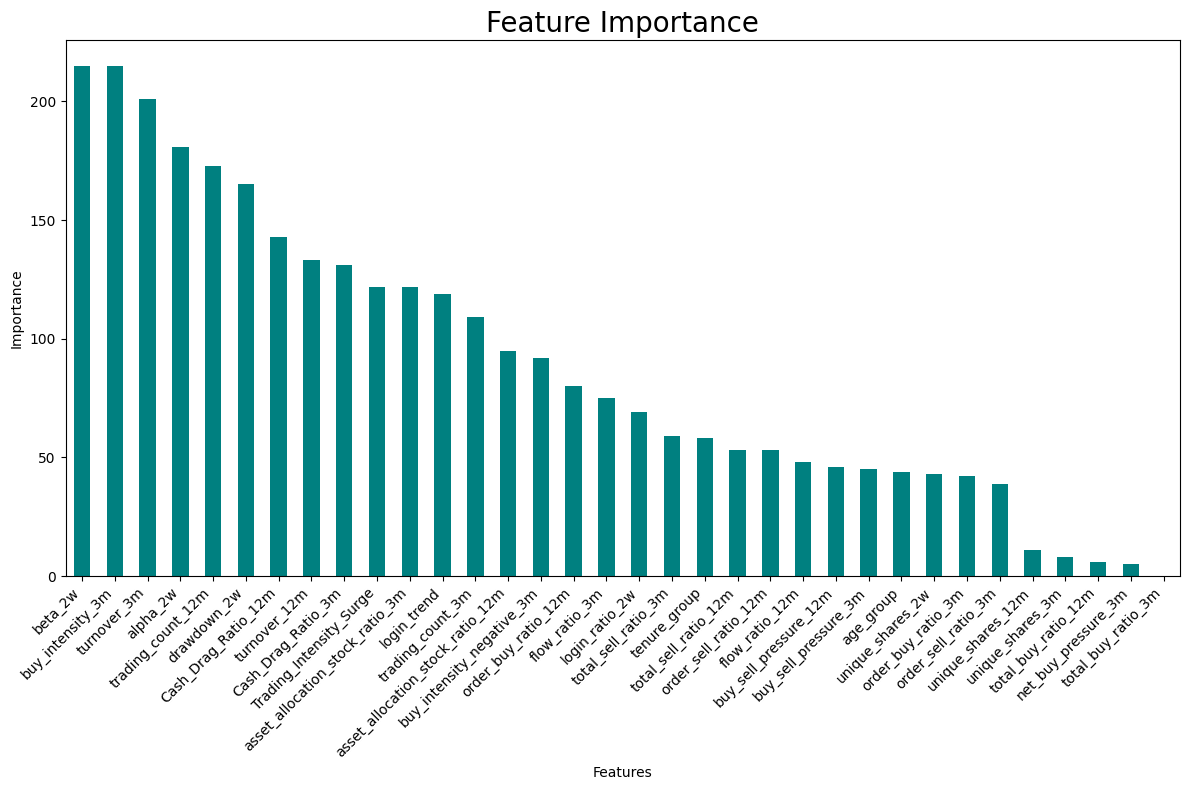


--- Feature Importance (Top 10) ---
beta_2w                    215
buy_intensity_3m           215
turnover_3m                201
alpha_2w                   181
trading_count_12m          173
drawdown_2w                165
Cash_Drag_Ratio_12m        143
turnover_12m               133
Cash_Drag_Ratio_3m         131
Trading_Intensity_Surge    122
dtype: int32


In [24]:
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier


X = df.drop(columns="loan_label_next", axis=1, errors='ignore')
y = df['loan_label_next']




rf = LGBMClassifier(random_state=42)
rf.fit(X, y)


feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 8)) # Điều chỉnh kích thước biểu đồ cho dễ nhìn
feature_importance.plot(kind='bar', color='teal')
plt.title('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=10)
plt.ylabel('Importance', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=10) # Xoay nhãn trục x để dễ đọc
plt.tight_layout() # Đảm bảo tất cả nhãn đều hiển th\ị
plt.show()

print("\n--- Feature Importance (Top 10) ---")
print(feature_importance.head(10))

## EDA 

In [166]:
df_final = df.copy()

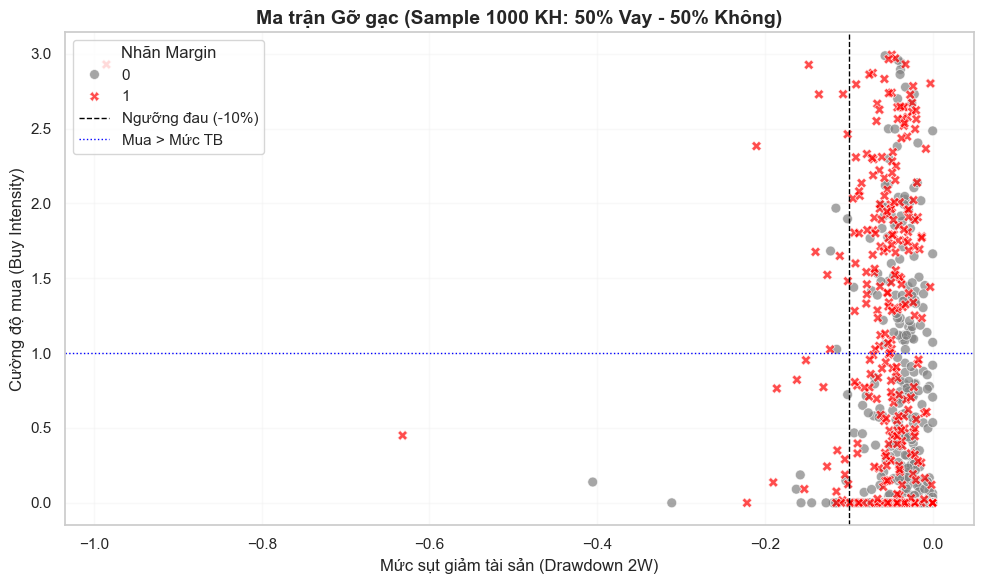

In [167]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ==============================================================================
# BƯỚC 1: LẤY MẪU CÂN BẰNG (BALANCED SAMPLING)
# ==============================================================================
# Mục tiêu: Lấy 1000 mẫu Label 0 và 1000 mẫu Label 1
n_samples_per_class = 500

# Lấy mẫu ngẫu nhiên (dùng try-except phòng trường hợp số lượng mẫu < 1000)
try:
    df_class_0 = df[df['loan_label_next'] == 0].sample(n=n_samples_per_class, random_state=42)
    df_class_1 = df[df['loan_label_next'] == 1].sample(n=n_samples_per_class, random_state=42)
except ValueError:
    # Nếu dữ liệu ít hơn 1000, lấy hết số lượng hiện có
    print("Cảnh báo: Số lượng mẫu ít hơn yêu cầu, lấy tối đa số lượng hiện có.")
    df_class_0 = df[df['loan_label_next'] == 0]
    df_class_1 = df[df['loan_label_next'] == 1]

# Ghép lại thành dataframe dùng để visualize
df_viz = pd.concat([df_class_0, df_class_1])

# ==============================================================================
# BƯỚC 2: VẼ BIỂU ĐỒ SCATTER
# ==============================================================================
plt.figure(figsize=(10, 6))

# Lọc nhẹ nhiễu hiển thị (buy_intensity < 3) để biểu đồ không bị co cụm
sns.scatterplot(
    data=df_viz[df_viz['buy_intensity_3m'] < 3], 
    x='drawdown_2w', 
    y='buy_intensity_3m', 
    hue='loan_label_next',
    style='loan_label_next', # Thêm hình dáng (tròn/chéo) để dễ phân biệt hơn
    alpha=0.7,               # Độ trong suốt (0.7 để nhìn rõ các điểm chồng nhau)
    palette={0: 'grey', 1: 'red'}, # Label 0 màu Xám (nền), Label 1 màu Đỏ (nổi bật)
    s=50                     # Kích thước điểm
)

# Trang trí biểu đồ
plt.title(f"Ma trận Gỡ gạc (Sample {len(df_viz)} KH: 50% Vay - 50% Không)", fontsize=14, fontweight='bold')
plt.xlabel("Mức sụt giảm tài sản (Drawdown 2W)", fontsize=12)
plt.ylabel("Cường độ mua (Buy Intensity)", fontsize=12)

# Vẽ các đường tham chiếu rủi ro
plt.axvline(-0.1, color='black', linestyle='--', linewidth=1, label='Ngưỡng đau (-10%)')
plt.axhline(1.0, color='blue', linestyle=':', linewidth=1, label='Mua > Mức TB')

plt.legend(title='Nhãn Margin', loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

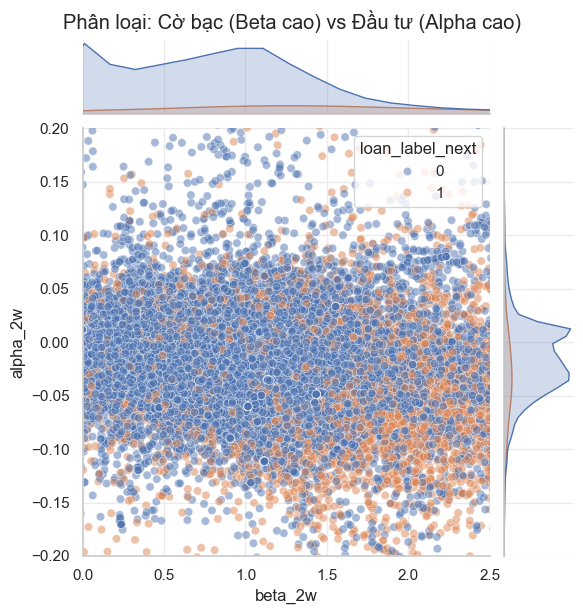

In [168]:
sns.jointplot(
    data=df,
    x='beta_2w', 
    y='alpha_2w', 
    hue='loan_label_next',
    kind='scatter',
    alpha=0.5,
    xlim=(0, 2.5), # Giới hạn lại view cho đỡ bị outlier
    ylim=(-0.2, 0.2)
)
plt.suptitle("Phân loại: Cờ bạc (Beta cao) vs Đầu tư (Alpha cao)", y=1.02)
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_31792\2362910879.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby('turnover_bin').agg(


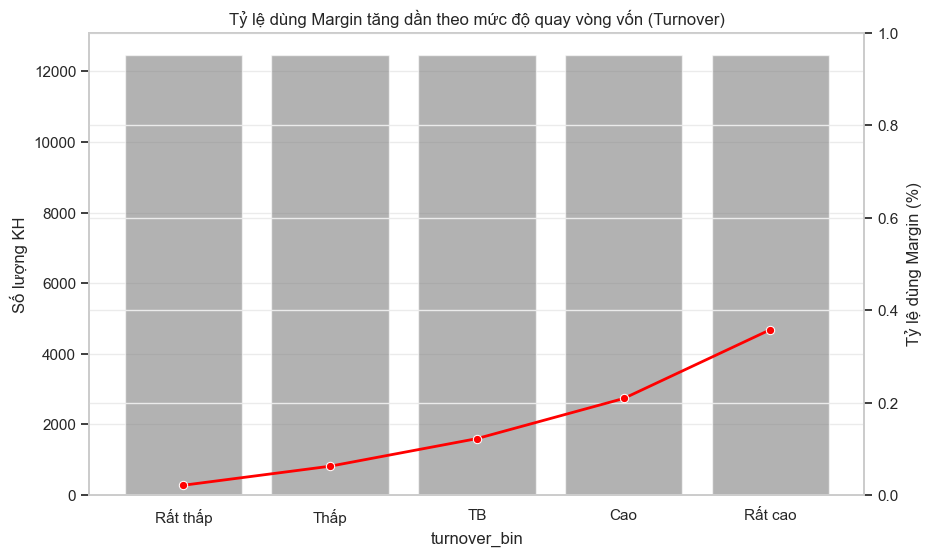

In [169]:
# Binning turnover
df['turnover_bin'] = pd.qcut(df['turnover_12m'], q=5, labels=['Rất thấp', 'Thấp', 'TB', 'Cao', 'Rất cao'])

# Tính toán
summary = df.groupby('turnover_bin').agg(
    Count=('loan_label_next', 'count'),
    Margin_Rate=('loan_label_next', 'mean')
).reset_index()

# Vẽ
fig, ax1 = plt.subplots(figsize=(10, 6))

# Cột số lượng
sns.barplot(data=summary, x='turnover_bin', y='Count', alpha=0.6, color='grey', ax=ax1)
ax1.set_ylabel('Số lượng KH')

# Đường tỷ lệ Margin
ax2 = ax1.twinx()
sns.lineplot(data=summary, x='turnover_bin', y='Margin_Rate', marker='o', color='red', ax=ax2, linewidth=2)
ax2.set_ylabel('Tỷ lệ dùng Margin (%)')
ax2.set_ylim(0, 1)

plt.title("Tỷ lệ dùng Margin tăng dần theo mức độ quay vòng vốn (Turnover)")
plt.show()

--- SO SÁNH BUY INTENSITY GIỮA 2 NHÓM ---
loan_label_next                             0            1
buy_intensity_3m          count  52687.000000  9622.000000
                          mean       0.849574     3.655448
                          std        1.942372     4.899359
                          min        0.000000     0.000000
                          25%        0.000000     0.721940
                          50%        0.112568     2.130077
                          75%        0.972853     4.659581
                          max       62.266544    76.988295
buy_intensity_negative_3m count  52687.000000  9622.000000
                          mean       0.318921     1.381549
                          std        0.918233     2.199283
                          min      -55.992237     0.000000
                          25%        0.000000     0.019670
                          50%        0.000000     0.603187
                          75%        0.253490     1.754138
              

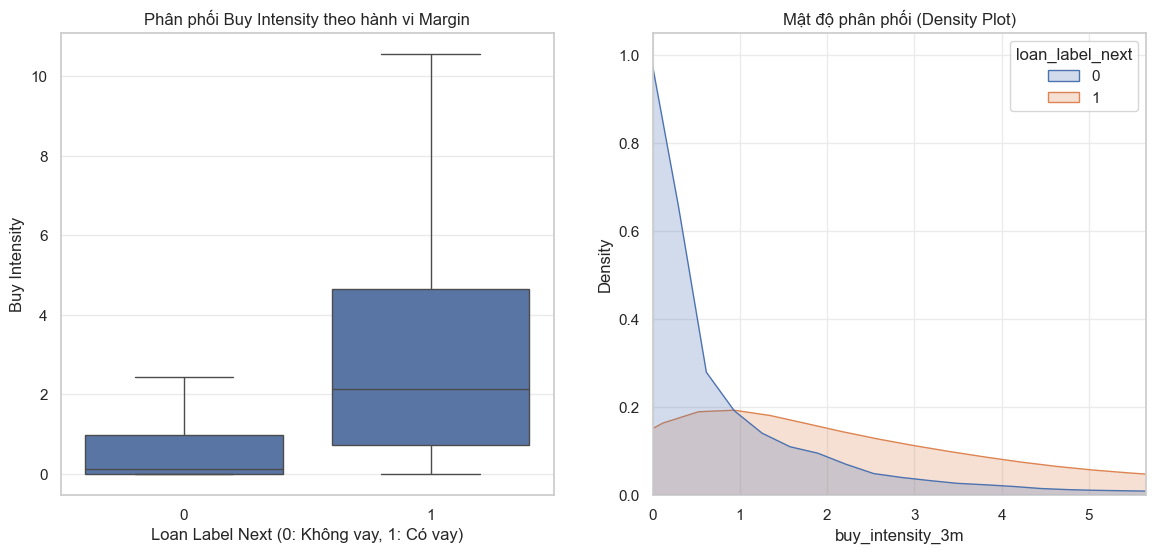

In [170]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Giả lập dữ liệu để demo (Bạn thay bằng df thật của bạn) ---
# df_final = pd.read_csv("your_data.csv") 

# 1. THỐNG KÊ MÔ TẢ (Describe)
print("--- SO SÁNH BUY INTENSITY GIỮA 2 NHÓM ---")
desc_stats = df_final.groupby('loan_label_next')[['buy_intensity_3m', 'buy_intensity_negative_3m']].describe()

# Định dạng hiển thị cho dễ nhìn
print(desc_stats.T)

# 2. TRỰC QUAN HÓA (Visualization)
plt.figure(figsize=(14, 6))

# Biểu đồ 1: Boxplot so sánh phân phối
plt.subplot(1, 2, 1)
sns.boxplot(data=df_final, x='loan_label_next', y='buy_intensity_3m', showfliers=False) # showfliers=False để ẩn bớt ngoại lai cho gọn
plt.title('Phân phối Buy Intensity theo hành vi Margin')
plt.xlabel('Loan Label Next (0: Không vay, 1: Có vay)')
plt.ylabel('Buy Intensity')

# Biểu đồ 2: Density Plot (Mật độ)
plt.subplot(1, 2, 2)
sns.kdeplot(data=df_final, x='buy_intensity_3m', hue='loan_label_next', common_norm=False, fill=True)
plt.title('Mật độ phân phối (Density Plot)')
plt.xlim(0, df_final['buy_intensity_3m'].quantile(0.95)) # Zoom vào 95% dữ liệu chính
plt.show()

# 3. TÌM NGƯỠNG (Binning Analysis)
# Chia Buy Intensity thành 10 nhóm (Deciles) hoặc các khoảng cụ thể
# Lưu ý: Vì có thể có nhiều giá

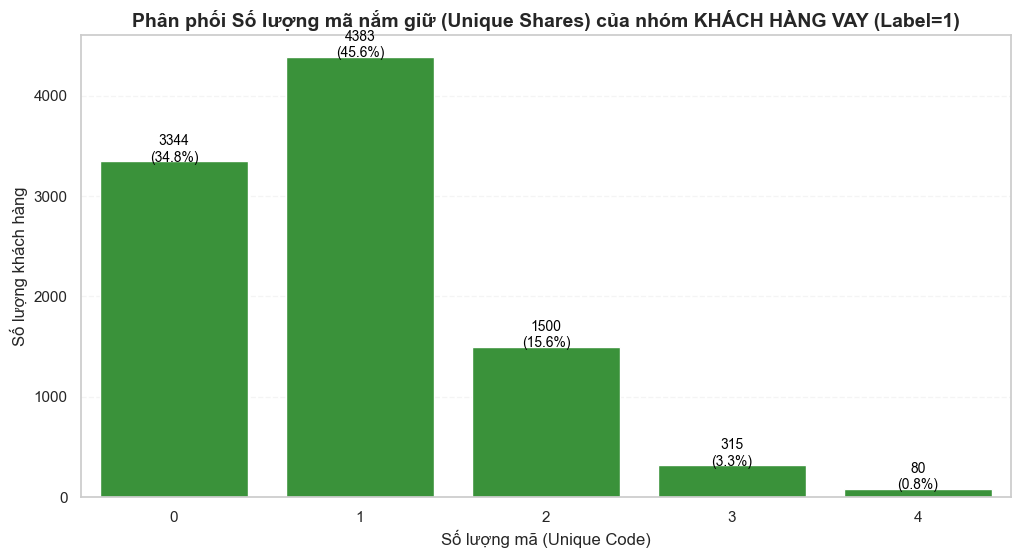

--- Thống kê Unique Code của nhóm VAY ---
count    9622.000000
mean        0.898774
std         0.836082
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         4.000000
Name: unique_shares_2w, dtype: float64


In [171]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Lọc dữ liệu: Chỉ lấy KH CÓ VAY (loan_label_next = 1)
df_borrowers = df[df['loan_label_next'] == 1].copy()

# 2. Vẽ biểu đồ đếm tần suất (Countplot)
plt.figure(figsize=(12, 6))

# Vẽ biểu đồ
ax = sns.countplot(
    data=df_borrowers, 
    x='unique_shares_2w',
    color='#2ca02c'       # Màu xanh lá (tượng trưng cho nhóm vay)
)


# Tính tổng số khách hàng vay để tính %
total_borrowers = len(df_borrowers)

for p in ax.patches:
    height = p.get_height()
    # Hiển thị số lượng + (phần trăm)
    ax.text(p.get_x() + p.get_width() / 2., height + 0.5, 
            f'{int(height)}\n({height/total_borrowers:.1%})', 
            ha="center", fontsize=10, color='black')

plt.title('Phân phối Số lượng mã nắm giữ (Unique Shares) của nhóm KHÁCH HÀNG VAY (Label=1)', fontsize=14, fontweight='bold')
plt.xlabel('Số lượng mã (Unique Code)', fontsize=12)
plt.ylabel('Số lượng khách hàng', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

# 4. In thống kê mô tả ra để bạn lấy số liệu báo cáo
print("--- Thống kê Unique Code của nhóm VAY ---")
print(df_borrowers['unique_shares_2w'].describe())

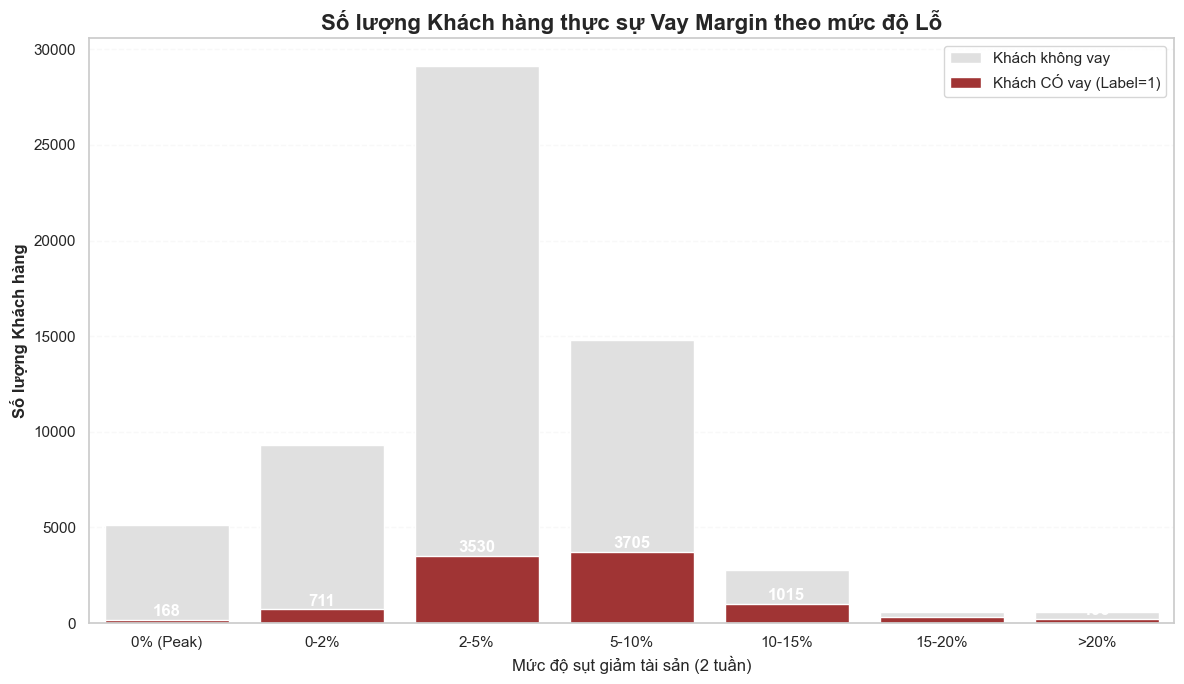

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Lấy trị tuyệt đối của drawdown
eda_df = df[['drawdown_2w', 'loan_label_next']].copy()
eda_df['dd_pct'] = eda_df['drawdown_2w'].abs() * 100 

# 2. Binning
bins = [-0.001, 0.001, 2, 5, 10, 15, 20, 100]
labels = ['0% (Peak)', '0-2%', '2-5%', '5-10%', '10-15%', '15-20%', '>20%']
eda_df['dd_group'] = pd.cut(eda_df['dd_pct'], bins=bins, labels=labels, include_lowest=True)

# Chỉ lấy những người thực sự vay (loan_label_next == 1)
borrowers_df = eda_df[eda_df['loan_label_next'] == 1]

# Đếm số lượng người vay trong từng nhóm
borrower_counts = borrowers_df.groupby('dd_group', observed=False).size().reset_index(name='borrower_count')

#  tổng số người trong nhóm đó (Total Volume)
total_counts = eda_df.groupby('dd_group', observed=False).size().reset_index(name='total_count')


merged_df = pd.merge(total_counts, borrower_counts, on='dd_group')

# 4. VẼ BIỂU ĐỒ STACKED BAR (Hiệu quả nhất)
fig, ax = plt.subplots(figsize=(12, 7))

# Vẽ cột TỔNG (Màu xám nhạt làm nền - Background)
sns.barplot(data=merged_df, x='dd_group', y='total_count', color='#e0e0e0', label='Khách không vay', ax=ax)

# Vẽ cột NGƯỜI VAY (Màu đỏ đè lên trên - Foreground)
# Đây chính là số lượng bạn đang muốn xem
sns.barplot(data=merged_df, x='dd_group', y='borrower_count', color='#b22222', label='Khách CÓ vay (Label=1)', ax=ax)

# Trang trí
ax.set_ylabel('Số lượng Khách hàng', fontsize=12, fontweight='bold')
ax.set_xlabel('Mức độ sụt giảm tài sản (2 tuần)', fontsize=12)
plt.title('Số lượng Khách hàng thực sự Vay Margin theo mức độ Lỗ', fontsize=16, fontweight='bold')
plt.legend()

# Thêm label số lượng cụ thể lên cột Đỏ
for index, row in merged_df.iterrows():
    # Ghi số lượng người vay
    ax.text(index, row['borrower_count'] + 50, f"{int(row['borrower_count'])}", 
            color='white', ha='center', va='bottom', fontweight='bold')
    
    # Ghi chú thêm tỷ lệ % ngay trên đầu cột xám (optional)
    # pct = row['borrower_count'] / row['total_count']
    # ax.text(index, row['total_count'] + 100, f"{pct:.1%}", color='gray', ha='center', fontsize=9)

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [173]:
df.alpha_2w.describe()

count    62309.000000
mean        -0.021230
std          0.054750
min         -0.972669
25%         -0.043947
50%         -0.021672
75%          0.006778
max          0.569354
Name: alpha_2w, dtype: float64

In [25]:
df = df.drop(columns=['turnover_3m'], axis=1)
df = df.drop(columns=['net_buy_pressure_3m'], axis=1) 

In [26]:
df = df.drop(columns= ['buy_sell_pressure_3m', 'buy_sell_pressure_12m'], axis=1)

In [27]:
# Tính toán ma trận tương quan
correlation_matrix = df.corr()
print("--- Ma trận tương quan (Correlation Matrix) ---")
print(correlation_matrix)

--- Ma trận tương quan (Correlation Matrix) ---
                                  loan_label_next  trading_count_12m  \
loan_label_next                          1.000000           0.403314   
trading_count_12m                        0.403314           1.000000   
unique_shares_12m                        0.346853           0.713297   
trading_count_3m                         0.421156           0.878463   
unique_shares_3m                         0.350219           0.698893   
unique_shares_2w                         0.323494           0.595526   
alpha_2w                                -0.122767          -0.092335   
beta_2w                                  0.262566           0.148311   
drawdown_2w                             -0.181386          -0.100065   
buy_intensity_3m                         0.360176           0.342939   
buy_intensity_negative_3m                0.302884           0.286223   
login_ratio_2w                           0.187351           0.346179   
login_trend     

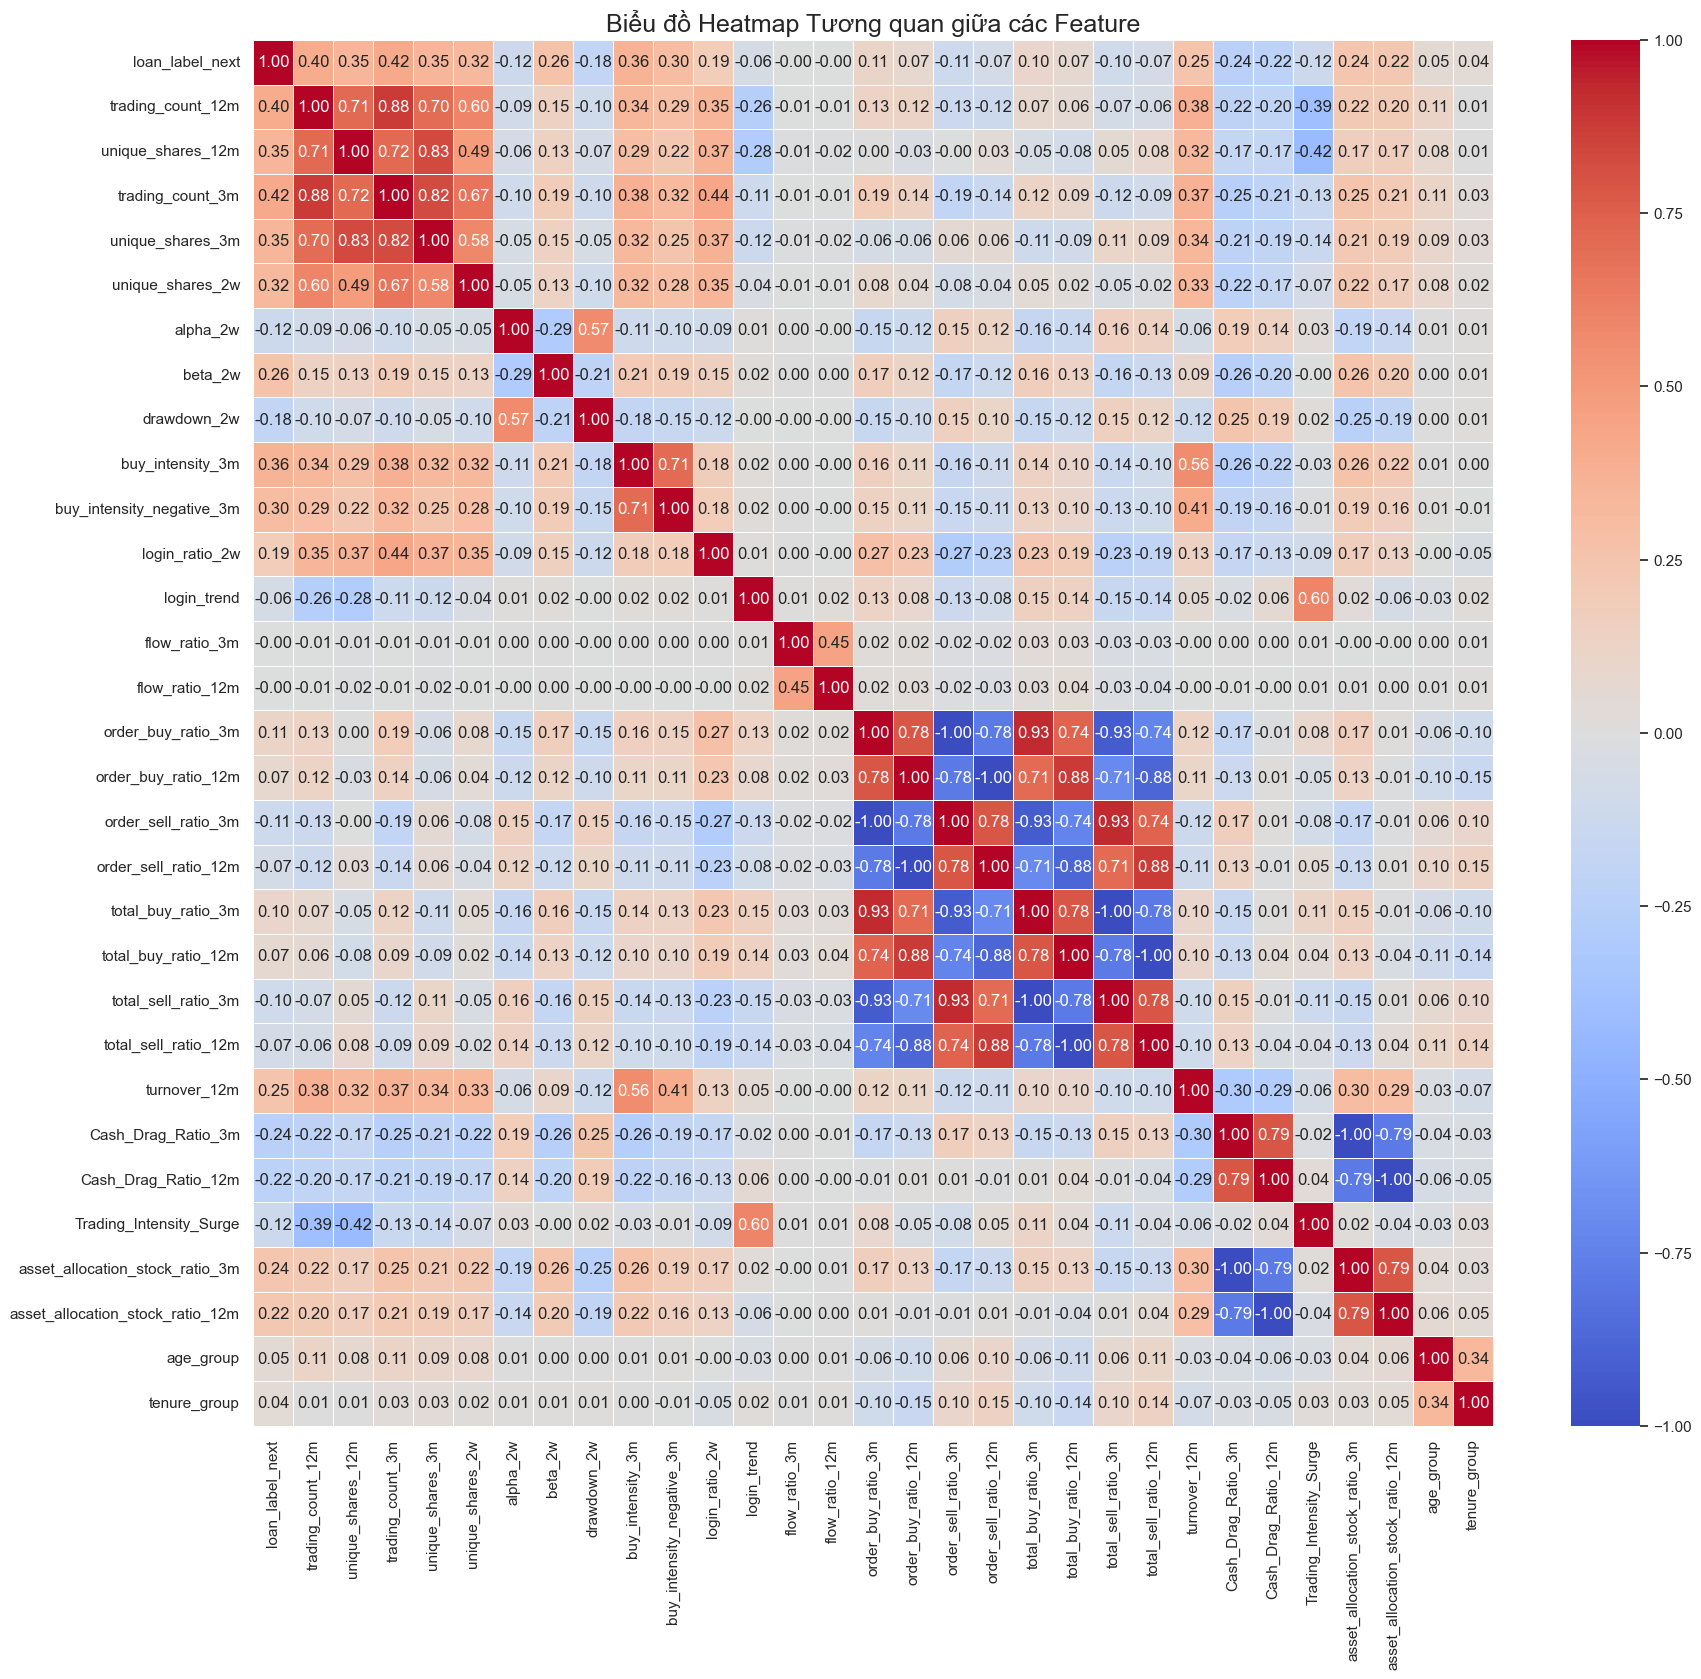

In [197]:
import seaborn as sns
import matplotlib.pyplot as plt

# Cấu hình kích thước biểu đồ
plt.figure(figsize=(20, 18))

# Tạo Heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,              # Hiển thị giá trị tương quan trên ô
    fmt=".2f",               # Định dạng số thập phân 2 chữ số
    cmap='coolwarm',         # Sử dụng bảng màu coolwarm (đỏ/xanh)
    linewidths=.5,           # Độ dày đường kẻ giữa các ô
    cbar=True                # Hiển thị thanh màu
)

# Đặt tiêu đề và điều chỉnh
plt.title('Biểu đồ Heatmap Tương quan giữa các Feature', fontsize=18)
plt.show()

In [198]:
import pandas as pd
import numpy as np

def get_redundant_pairs(corr_matrix, threshold=0.95):
    """
    Hàm trả về DataFrame các cặp biến có độ tương quan cao hơn ngưỡng (threshold).
    Xử lý cả tương quan dương (> 0.95) và âm (< -0.95).
    """
    # 1. Lấy tam giác trên của ma trận tương quan (để tránh trùng lặp A-B và B-A)
    # k=1 để loại bỏ đường chéo chính (tương quan với chính nó luôn là 1)
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # 2. Chuyển ma trận thành dạng cột (Stacking) để dễ lọc
    stacked_corr = upper_tri.stack()

    # 3. Lọc các giá trị có độ lớn (abs) > threshold
    # Dùng abs() vì tương quan -0.99 cũng gây hại như 0.99 (nghịch biến hoàn hảo)
    high_corr_pairs = stacked_corr[abs(stacked_corr) > threshold]

    # 4. Trình bày đẹp
    result_df = pd.DataFrame(high_corr_pairs, columns=['Correlation_Coefficient'])
    result_df.index.names = ['Feature_1', 'Feature_2']
    
    # Sắp xếp giảm dần theo độ lớn tương quan
    return result_df.sort_values(by='Correlation_Coefficient', ascending=False)

# --- THỰC THI ---

# Giả sử bạn đã có correlation_matrix từ bước trước
# Nếu chưa: correlation_matrix = df_final.corr()

high_corr_df = get_redundant_pairs(correlation_matrix, threshold=0.95)

print(f"Tổng số cặp biến có tương quan > 0.95: {len(high_corr_df)}")
print("-" * 50)
print(high_corr_df)

# --- GỢI Ý DROP TỰ ĐỘNG (OPTIONAL) ---
# Lấy danh sách các biến cần drop (lấy biến thứ 2 trong cặp để drop)
to_drop = [pair[1] for pair in high_corr_df.index]
unique_to_drop = list(set(to_drop))
print(f"\nDanh sách gợi ý các biến nên xóa (Biến thứ 2 trong cặp): \n{unique_to_drop}")

Tổng số cặp biến có tương quan > 0.95: 6
--------------------------------------------------
                                                      Correlation_Coefficient
Feature_1           Feature_2                                                
total_buy_ratio_12m total_sell_ratio_12m                            -0.999954
Cash_Drag_Ratio_3m  asset_allocation_stock_ratio_3m                 -1.000000
Cash_Drag_Ratio_12m asset_allocation_stock_ratio_12m                -1.000000
order_buy_ratio_12m order_sell_ratio_12m                            -1.000000
order_buy_ratio_3m  order_sell_ratio_3m                             -1.000000
total_buy_ratio_3m  total_sell_ratio_3m                             -1.000000

Danh sách gợi ý các biến nên xóa (Biến thứ 2 trong cặp): 
['total_sell_ratio_3m', 'asset_allocation_stock_ratio_12m', 'asset_allocation_stock_ratio_3m', 'order_sell_ratio_12m', 'total_sell_ratio_12m', 'order_sell_ratio_3m']


In [28]:
df = df.drop(columns=[ 'unique_shares_2w','login_ratio_2w',])

In [200]:
df.columns

Index(['loan_label_next', 'trading_count_12m', 'unique_shares_12m',
       'trading_count_3m', 'unique_shares_3m', 'alpha_2w', 'beta_2w',
       'drawdown_2w', 'buy_intensity_3m', 'buy_intensity_negative_3m',
       'login_trend', 'flow_ratio_3m', 'flow_ratio_12m', 'order_buy_ratio_3m',
       'order_buy_ratio_12m', 'order_sell_ratio_3m', 'order_sell_ratio_12m',
       'total_buy_ratio_3m', 'total_buy_ratio_12m', 'total_sell_ratio_3m',
       'total_sell_ratio_12m', 'turnover_12m', 'Cash_Drag_Ratio_3m',
       'Cash_Drag_Ratio_12m', 'Trading_Intensity_Surge',
       'asset_allocation_stock_ratio_3m', 'asset_allocation_stock_ratio_12m',
       'age_group', 'tenure_group'],
      dtype='object')

c:\Users\Admin\.conda\envs\py39\lib\site-packages\pandas\core\nanops.py:1256: RuntimeWarning: invalid value encountered in subtract
  adjusted = values - mean
c:\Users\Admin\.conda\envs\py39\lib\site-packages\pandas\core\nanops.py:1256: RuntimeWarning: invalid value encountered in subtract
  adjusted = values - mean


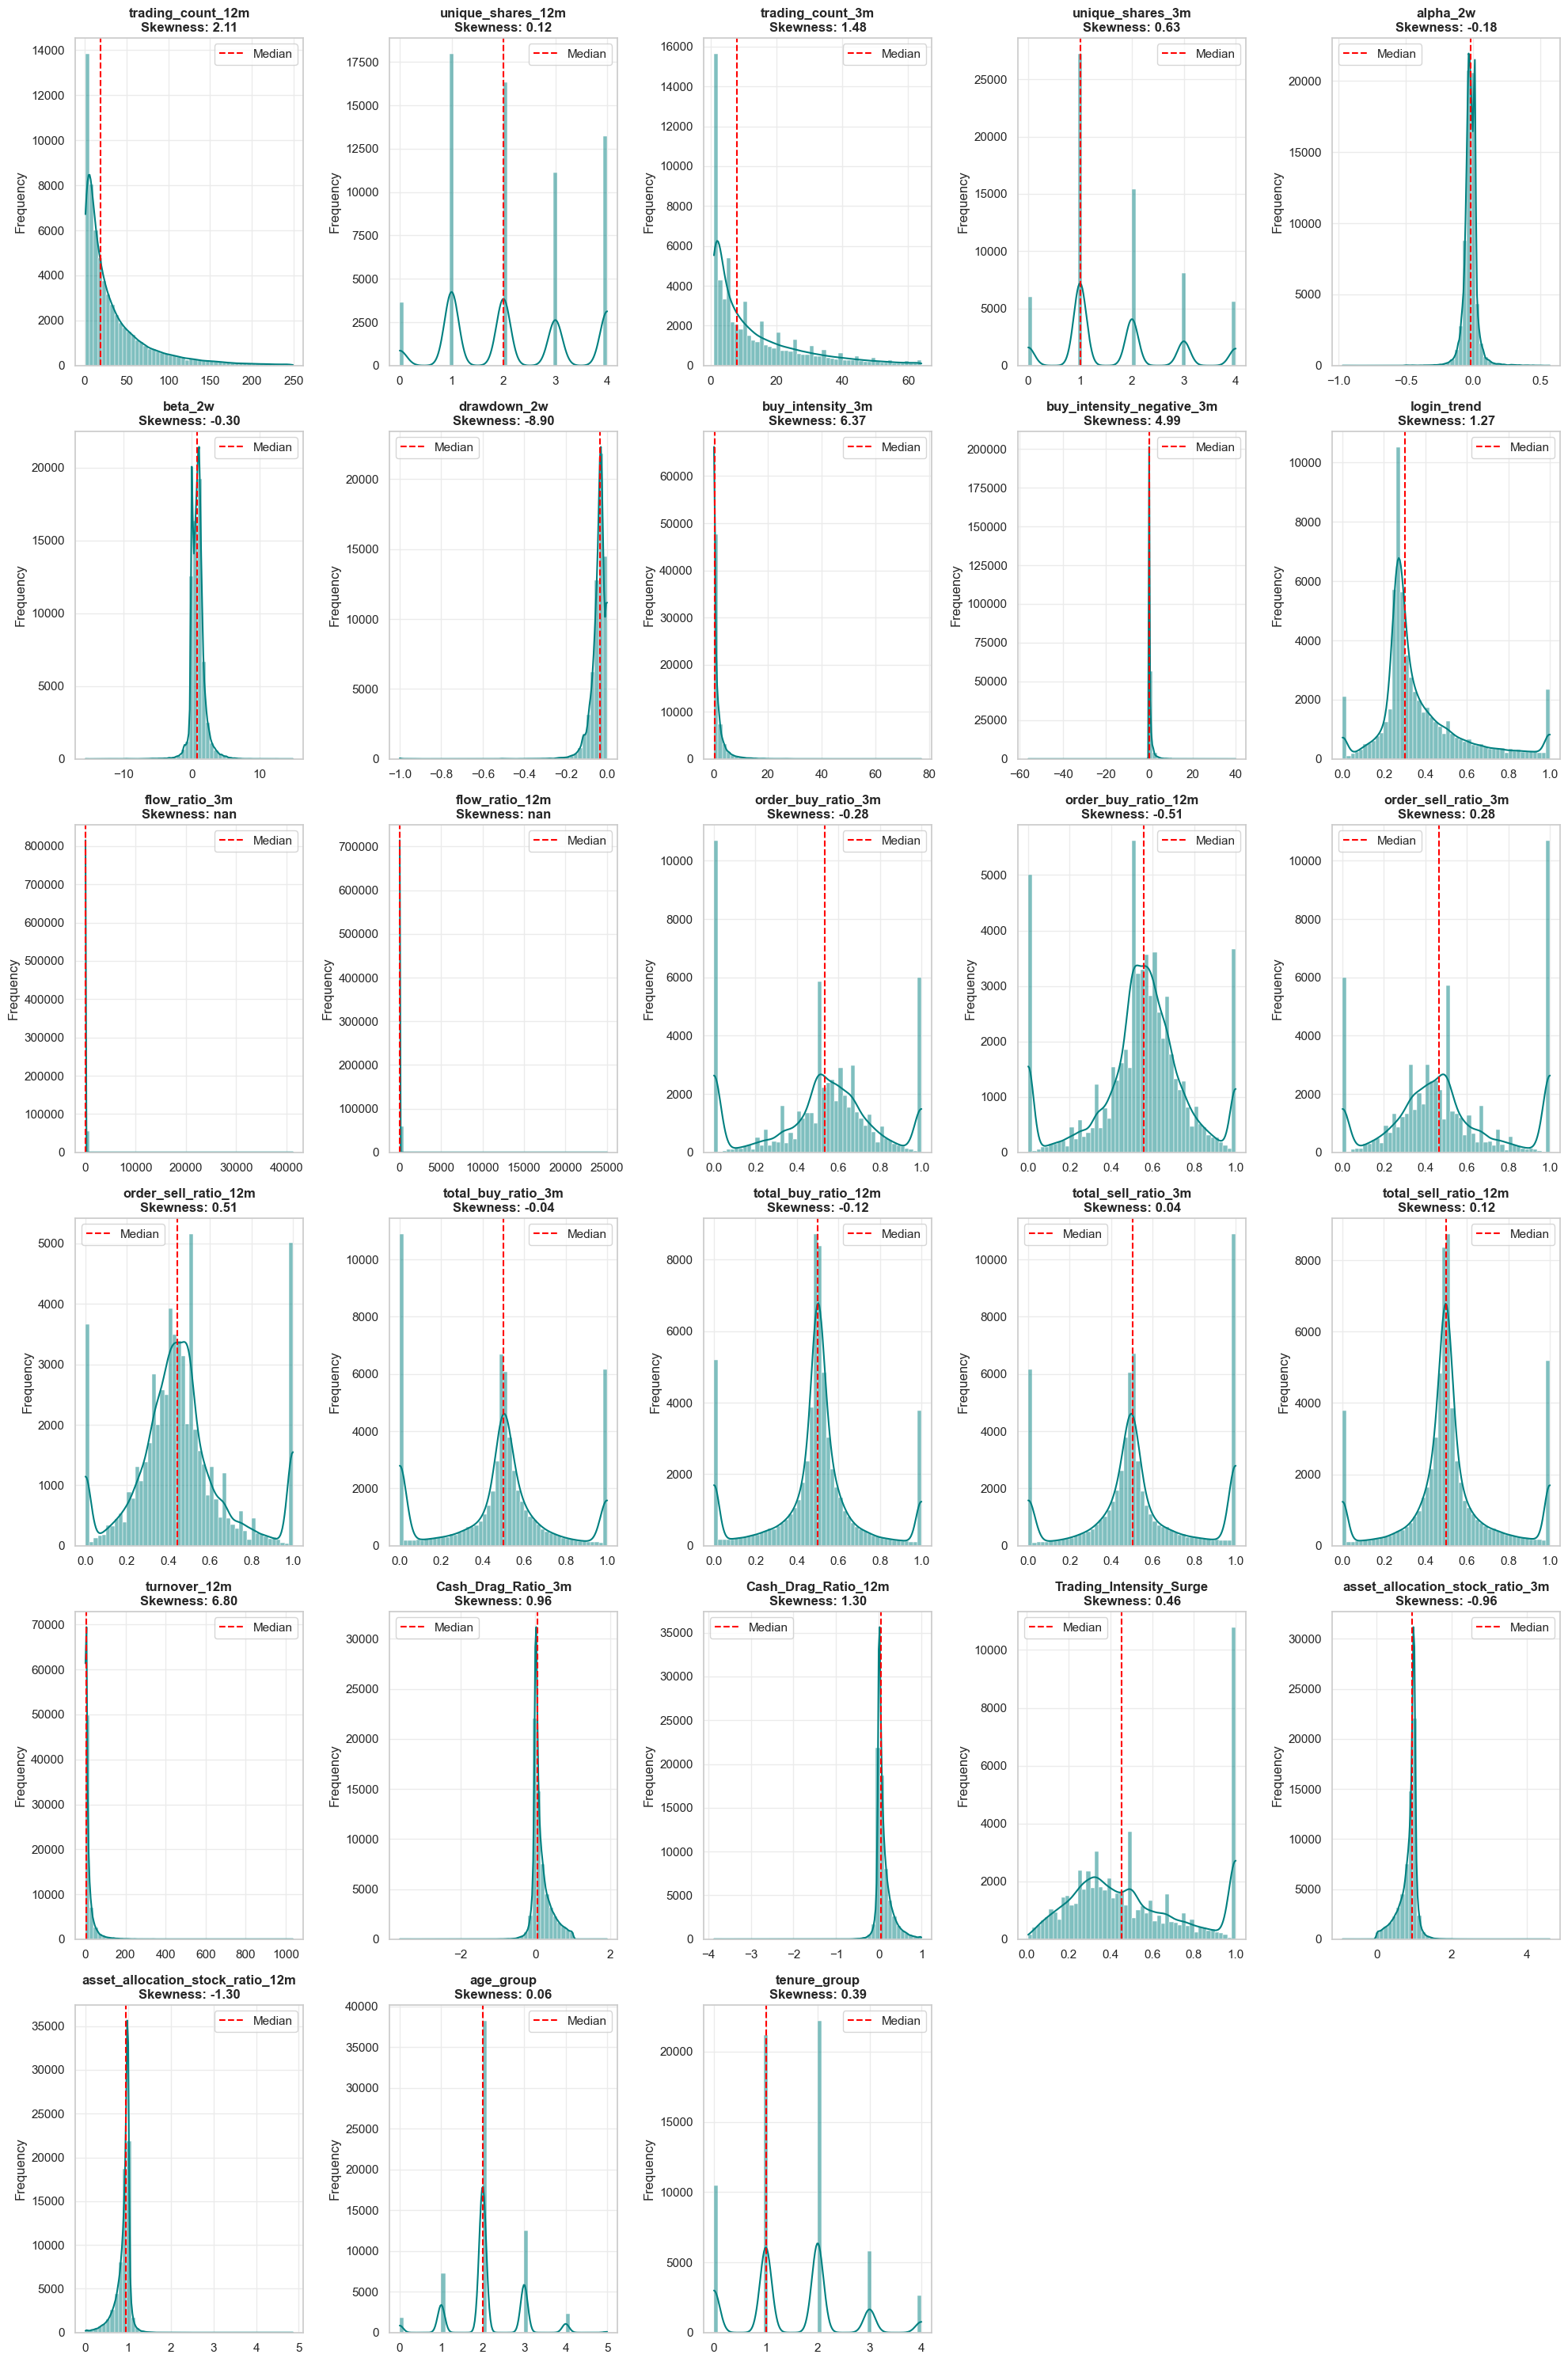

In [201]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

def check_money_distribution(df, cols_to_check):
    """
    Vẽ biểu đồ phân phối và tính độ lệch (Skewness)
    """
    # Lọc các cột thực sự tồn tại trong df
    valid_cols = [c for c in cols_to_check if c in df.columns]
    
    n_cols = 5
    n_rows = (len(valid_cols) + n_cols - 1) // n_cols
    
    plt.figure(figsize=(20, 5 * n_rows))
    
    for i, col in enumerate(valid_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        
        # 1. Vẽ Histogram và đường KDE (Kernel Density Estimate)
        sns.histplot(df[col], kde=True, color='teal', bins=50)
        
        # 2. Tính chỉ số Skewness (Độ lệch)
        # Skewness = 0: Chuẩn tuyệt đối
        # Skewness > 0: Lệch phải (đuôi dài bên phải)
        # Skewness < 0: Lệch trái (đuôi dài bên trái)
        skew_val = df[col].skew()
        
        # 3. Trang trí
        plt.title(f'{col}\nSkewness: {skew_val:.2f}', fontsize=12, fontweight='bold')
        plt.xlabel('')
        plt.ylabel('Frequency')
        
        # Thêm đường kẻ dọc tại trung vị (Median)
        plt.axvline(df[col].median(), color='red', linestyle='--', label='Median')
        plt.legend()

    plt.tight_layout()
    plt.show()

# --- DANH SÁCH CÁC TRƯỜNG TIỀN TỆ CẦN KIỂM TRA ---
# Đây là danh sách các biến bạn vừa Log/Yeo-Johnson
money_cols_to_check = [
    # Nhóm Log1p
       'avg_nav_ck_12m', 'total_trading_amount_12m',
       'trading_count_12m', 'unique_shares_12m', 'trading_count_3m',
       'unique_shares_3m', 'profit_ratio_12m', 'profit_ratio_3m', 'alpha_2w',
       'beta_2w', 'drawdown_2w', 'buy_intensity_3m',
       'buy_intensity_negative_3m', 'login_trend', 'flow_ratio_3m',
       'flow_ratio_12m', 'order_buy_ratio_3m', 'order_buy_ratio_12m',
       'order_sell_ratio_3m', 'order_sell_ratio_12m', 'total_buy_ratio_3m',
       'total_buy_ratio_12m', 'total_sell_ratio_3m', 'total_sell_ratio_12m',
       'turnover_12m', 'Cash_Drag_Ratio_3m', 'Cash_Drag_Ratio_12m',
       'Trading_Intensity_Surge', 'asset_allocation_stock_ratio_3m',
       'asset_allocation_stock_ratio_12m', 'age_group', 'tenure_group'
]

# --- THỰC THI ---
# df_clean của bạn lúc này đã là df_ready_for_scale (đã transform)
check_money_distribution(df, money_cols_to_check)
        
        


In [29]:
df.columns

Index(['loan_label_next', 'trading_count_12m', 'unique_shares_12m',
       'trading_count_3m', 'unique_shares_3m', 'alpha_2w', 'beta_2w',
       'drawdown_2w', 'buy_intensity_3m', 'buy_intensity_negative_3m',
       'login_trend', 'flow_ratio_3m', 'flow_ratio_12m', 'order_buy_ratio_3m',
       'order_buy_ratio_12m', 'order_sell_ratio_3m', 'order_sell_ratio_12m',
       'total_buy_ratio_3m', 'total_buy_ratio_12m', 'total_sell_ratio_3m',
       'total_sell_ratio_12m', 'turnover_12m', 'Cash_Drag_Ratio_3m',
       'Cash_Drag_Ratio_12m', 'Trading_Intensity_Surge',
       'asset_allocation_stock_ratio_3m', 'asset_allocation_stock_ratio_12m',
       'age_group', 'tenure_group'],
      dtype='object')

## Feature Extration 

#### Handle Outlier

In [202]:
import pandas as pd
import numpy as np

# 1. Nhóm các biến chỉ có giá trị dương (Cần chặn trên 99%)
pos_cols = [
    'turnover_12m', 'flow_ratio_12m',
    'flow_ratio_3m','order_buy_ratio_3m', 'order_buy_ratio_12m', 'order_sell_ratio_3m', 'order_sell_ratio_12m',
    'Trading_Intensity_Surge', 'login_trend', 'asset_allocation_stock_ratio_3m', 'asset_allocation_stock_ratio_12m', 'trading_count_12m',
    'trading_count_3m', "buy_intensity_3m"
]

# 2. Nhóm các biến có giá trị âm (Cần chặn cả 2 đầu: 1% và 99%)
# Đặc biệt quan trọng cho Beta, Alpha, Profit, Net Flow
two_way_cols = [
    'profit_ratio_3m',
    'cash_flow_3m', 'cash_flow_12m', 
    'buy_sell_pressure_3m', 'buy_sell_pressure_12m',
    'order_buy_sell_pressure_3m', 'beta_2w', 'alpha_2w', 'drawdown_2w', 'Cash_Drag_Ratio_3m', 'Cash_Drag_Ratio_12m', #'buy_intensity_negative_3m'
]

def handle_outliers(df):
    df_capped = df.copy()
    
    # Xử lý nhóm chặn trên 0.99
    for col in pos_cols:
        if col in df_capped.columns:
            upper_limit = df_capped[col].quantile(0.99)
            df_capped[col] = df_capped[col].clip(upper=upper_limit)
            
    # Xử lý nhóm chặn 2 đầu (0.01 và 0.99)
    for col in two_way_cols:
        if col in df_capped.columns:
            lower_limit = df_capped[col].quantile(0.01)
            upper_limit = df_capped[col].quantile(0.99)
            df_capped[col] = df_capped[col].clip(lower=lower_limit, upper=upper_limit)
            
    return df_capped

# Áp dụng
df = handle_outliers(df)

c:\Users\Admin\.conda\envs\py39\lib\site-packages\numpy\lib\_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\Users\Admin\.conda\envs\py39\lib\site-packages\numpy\lib\_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [203]:
df.columns

Index(['loan_label_next', 'trading_count_12m', 'unique_shares_12m',
       'trading_count_3m', 'unique_shares_3m', 'alpha_2w', 'beta_2w',
       'drawdown_2w', 'buy_intensity_3m', 'buy_intensity_negative_3m',
       'login_trend', 'flow_ratio_3m', 'flow_ratio_12m', 'order_buy_ratio_3m',
       'order_buy_ratio_12m', 'order_sell_ratio_3m', 'order_sell_ratio_12m',
       'total_buy_ratio_3m', 'total_buy_ratio_12m', 'total_sell_ratio_3m',
       'total_sell_ratio_12m', 'turnover_12m', 'Cash_Drag_Ratio_3m',
       'Cash_Drag_Ratio_12m', 'Trading_Intensity_Surge',
       'asset_allocation_stock_ratio_3m', 'asset_allocation_stock_ratio_12m',
       'age_group', 'tenure_group'],
      dtype='object')

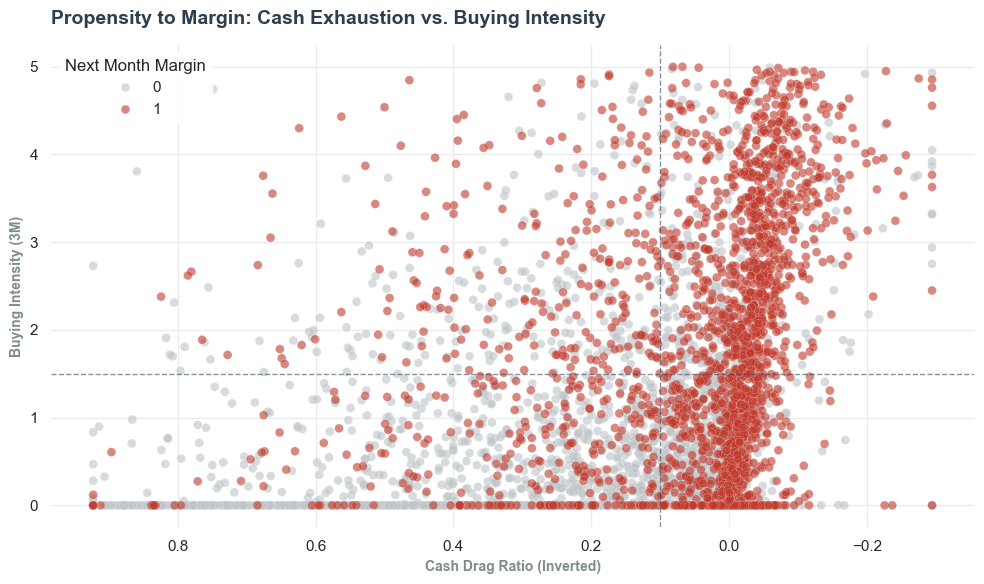

In [204]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ==============================================================================
# 1. PREPARE DATA (BALANCED SAMPLING)
# ==============================================================================
n_samples = 3000  # Tăng lên 3000 mẫu mỗi nhóm

df_class_0 = df[df['loan_label_next'] == 0]
df_class_1 = df[df['loan_label_next'] == 1]

# Sampling (Dùng min để tránh lỗi nếu dữ liệu thực tế < 3000)
df_sample_0 = df_class_0.sample(n=min(n_samples, len(df_class_0)), random_state=42)
df_sample_1 = df_class_1.sample(n=min(n_samples, len(df_class_1)), random_state=42)
df_viz = pd.concat([df_sample_0, df_sample_1])

# Filter noise (Tập trung vào vùng phân bố chính)
data_plot = df_viz[(df_viz['buy_intensity_3m'] < 5) & (df_viz['Cash_Drag_Ratio_3m'] <= 1)]

# ==============================================================================
# 2. PLOTTING - PROFESSIONAL KAGGLE STYLE
# ==============================================================================
# Thiết lập style nền trắng, grid mờ, font chữ sans-serif
sns.set_theme(style="whitegrid", rc={"grid.color": ".92", "axes.edgecolor": ".8"})

plt.figure(figsize=(10, 6))

# Vẽ Scatter plot
ax = sns.scatterplot(
    data=data_plot,
    x='Cash_Drag_Ratio_3m', 
    y='buy_intensity_3m',
    hue='loan_label_next',
    palette=['#BDC3C7', '#C0392B'],  # Màu: Silver (0) vs. Professional Red (1)
    alpha=0.6,                       # Độ trong suốt (giảm nhẹ vì số lượng điểm tăng lên)
    s=40,                            # Kích thước điểm (giảm nhẹ để đỡ bị dính)
    marker='o',
    edgecolor='white',               # Viền trắng mỏng
    linewidth=0.2,
    legend='full'
)

# --- AESTHETICS ---

# 1. Các đường ngưỡng (Thresholds)
plt.axvline(0.1, color='#34495E', linestyle='--', linewidth=1, alpha=0.6)
plt.axhline(1.5, color='#34495E', linestyle='--', linewidth=1, alpha=0.6)

# 2. Đảo trục X (Rủi ro tăng dần về phía bên phải)
plt.gca().invert_xaxis()

# 3. Tinh chỉnh trục và tiêu đề (Minimalist)
plt.title('Propensity to Margin: Cash Exhaustion vs. Buying Intensity', 
          fontsize=14, fontweight='bold', pad=15, color='#2C3E50', loc='left')

plt.xlabel('Cash Drag Ratio (Inverted)', fontsize=10, fontweight='bold', color='#7F8C8D')
plt.ylabel('Buying Intensity (3M)', fontsize=10, fontweight='bold', color='#7F8C8D')

# 4. Tinh chỉnh Legend
legend = plt.legend(title='Next Month Margin', loc='upper left', frameon=True)
legend.get_frame().set_edgecolor('white') 
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.9)

# 5. Despine (Bỏ khung viền thừa)
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_31792\373164281.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


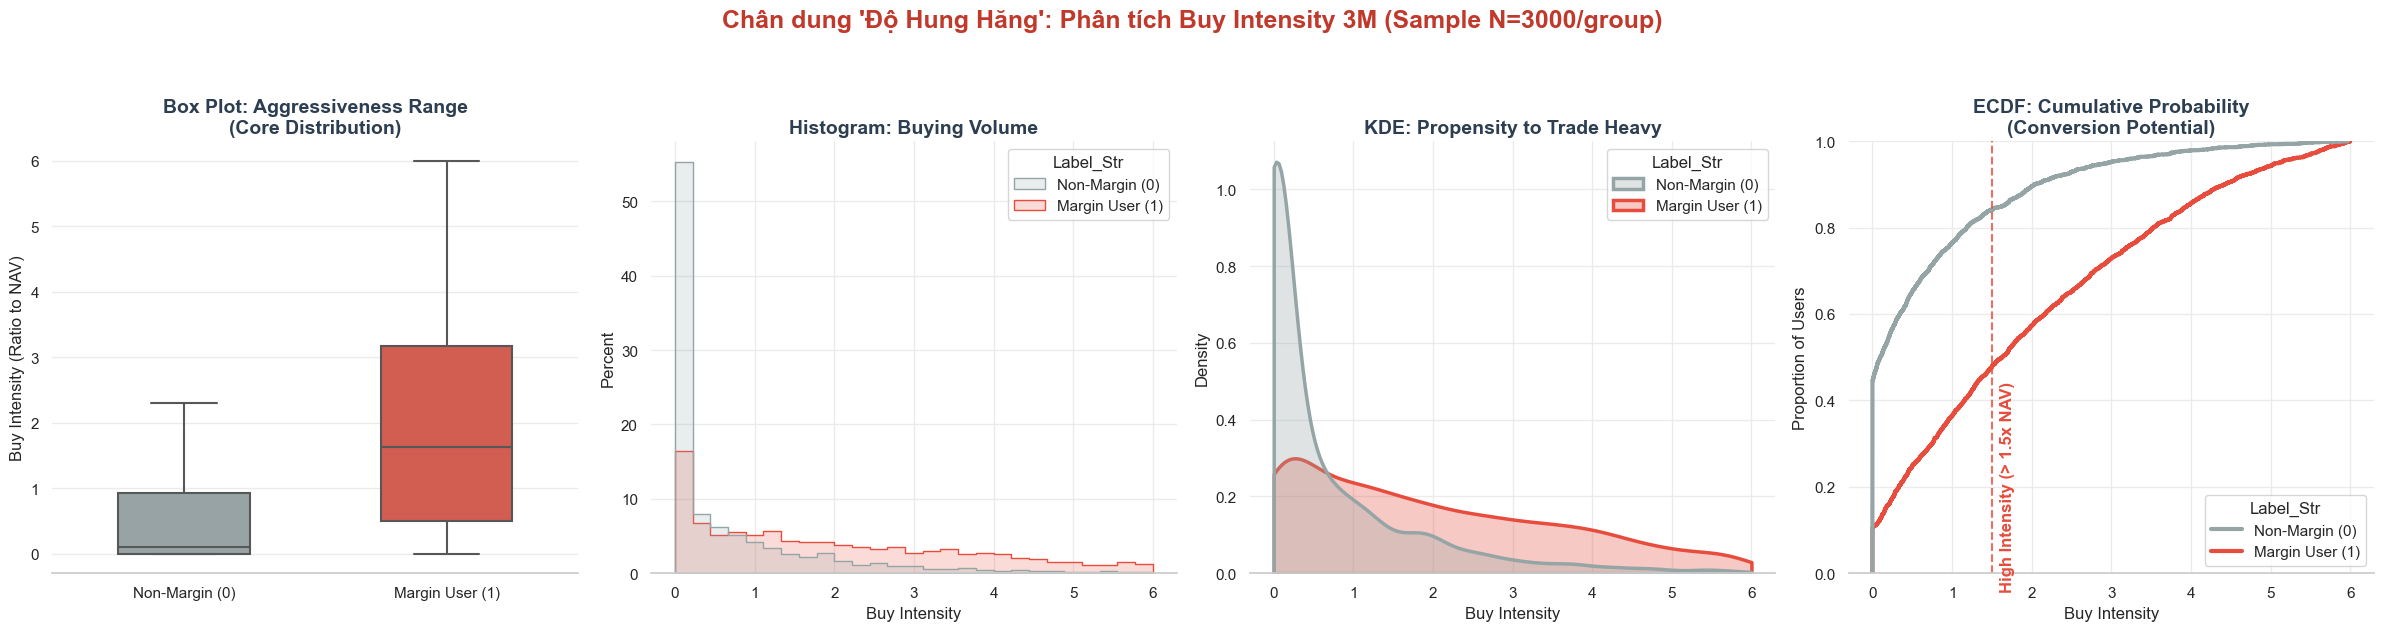

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ==============================================================================
# 1. DATA PREPARATION (BALANCED SAMPLING)
# ==============================================================================
n_samples = 3000  # 3000 mẫu mỗi nhóm

# Lấy mẫu cân bằng
df_0 = df[df['loan_label_next'] == 0].sample(n=min(n_samples, len(df[df['loan_label_next'] == 0])), random_state=42)
df_1 = df[df['loan_label_next'] == 1].sample(n=min(n_samples, len(df[df['loan_label_next'] == 1])), random_state=42)

# Gán nhãn text
df_0['Label_Str'] = 'Non-Margin (0)'
df_1['Label_Str'] = 'Margin User (1)'

# Ghép dữ liệu
df_viz = pd.concat([df_0, df_1])

# Lọc bớt nhiễu cực đoan để biểu đồ đẹp (Chỉ lấy Intensity < 6)
# Vì thực tế có những người quay vòng vốn 20-30 lần/tháng sẽ làm hỏng scale
df_viz_clean = df_viz[df_viz['buy_intensity_3m'] < 6]

# ==============================================================================
# 2. SETUP STYLE & PALETTE
# ==============================================================================
# Palette: 0 (Thận trọng) = Xám Xanh, 1 (Hung hăng) = Đỏ Tươi
custom_palette = {'Non-Margin (0)': '#95A5A6', 'Margin User (1)': '#E74C3C'}
sns.set_style('whitegrid', {"grid.color": ".92", "axes.edgecolor": ".8"})

# ==============================================================================
# 3. PLOTTING FUNCTION
# ==============================================================================
def plot_intensity_portrait(data, variable='buy_intensity_3m'):
    
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))
    
    # --- Plot 1: Box Plot (So sánh mức trung bình & biên độ) ---
    sns.boxplot(
        ax=axes[0], 
        data=data, 
        x='Label_Str', 
        y=variable, 
        palette=custom_palette,
        linewidth=1.5,
        width=0.5,
        showfliers=False # Ẩn outlier để tập trung vào phân phối chính
    )
    axes[0].set_title(f"Box Plot: Aggressiveness Range\n(Core Distribution)", fontsize=14, fontweight='bold', color='#2C3E50')
    axes[0].set_xlabel("")
    axes[0].set_ylabel("Buy Intensity (Ratio to NAV)")

    # --- Plot 2: Histogram (Tần suất) ---
    sns.histplot(
        ax=axes[1], 
        data=data, 
        x=variable, 
        hue='Label_Str', 
        palette=custom_palette, 
        kde=False, 
        element="step", 
        stat="percent", 
        common_norm=False,
        alpha=0.2
    )
    axes[1].set_title(f"Histogram: Buying Volume", fontsize=14, fontweight='bold', color='#2C3E50')
    axes[1].set_xlabel("Buy Intensity")
    
    # --- Plot 3: KDE Plot (Hình dáng hành vi) ---
    sns.kdeplot(
        ax=axes[2], 
        data=data, 
        x=variable, 
        hue='Label_Str', 
        fill=True, 
        common_norm=False,
        palette=custom_palette, 
        alpha=0.3, 
        linewidth=2.5,
        clip=(0, 6) # Giới hạn hiển thị KDE
    )
    axes[2].set_title(f"KDE: Propensity to Trade Heavy", fontsize=14, fontweight='bold', color='#2C3E50')
    axes[2].set_xlabel("Buy Intensity")
    
    # --- Plot 4: ECDF Plot (Xác suất Hung hăng - Quan trọng nhất) ---
    sns.ecdfplot(
        ax=axes[3], 
        data=data, 
        x=variable, 
        hue='Label_Str', 
        palette=custom_palette, 
        linewidth=3
    )
    
    # Đường tham chiếu: Aggressive Threshold (> 1.5 lần NAV)
    threshold_val = 1.5
    axes[3].axvline(threshold_val, color='#E74C3C', linestyle='--', alpha=0.8)
    axes[3].text(threshold_val + 0.1, 0.2, 'High Intensity (> 1.5x NAV)', rotation=90, color='#E74C3C', verticalalignment='center', fontweight='bold')
    
    axes[3].set_title(f"ECDF: Cumulative Probability\n(Conversion Potential)", fontsize=14, fontweight='bold', color='#2C3E50')
    axes[3].set_xlabel("Buy Intensity")
    axes[3].set_ylabel("Proportion of Users")

    # --- Final Touches ---
    plt.suptitle(f"Chân dung 'Độ Hung Hăng': Phân tích Buy Intensity 3M (Sample N={n_samples}/group)", 
                 fontsize=18, fontweight='bold', y=1.05, color='#C0392B')
    sns.despine(left=True)
    plt.tight_layout()
    plt.show()

# Chạy hàm vẽ
plot_intensity_portrait(df_viz_clean)

C:\Users\Admin\AppData\Local\Temp\ipykernel_31792\1334293129.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


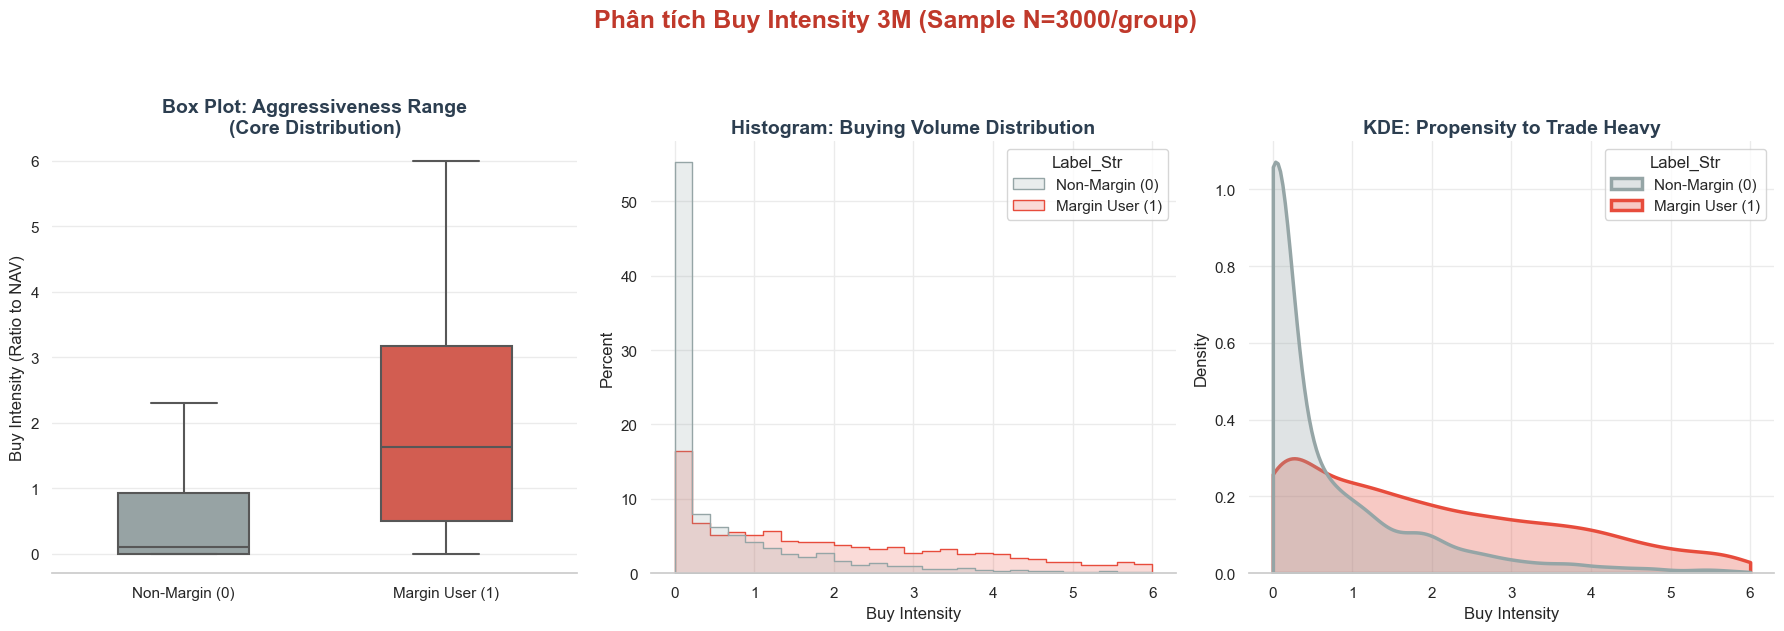

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ==============================================================================
# 1. DATA PREPARATION (BALANCED SAMPLING)
# ==============================================================================
n_samples = 3000  # 3000 mẫu mỗi nhóm

# Lấy mẫu cân bằng
df_0 = df[df['loan_label_next'] == 0].sample(n=min(n_samples, len(df[df['loan_label_next'] == 0])), random_state=42)
df_1 = df[df['loan_label_next'] == 1].sample(n=min(n_samples, len(df[df['loan_label_next'] == 1])), random_state=42)

# Gán nhãn text
df_0['Label_Str'] = 'Non-Margin (0)'
df_1['Label_Str'] = 'Margin User (1)'

# Ghép dữ liệu
df_viz = pd.concat([df_0, df_1])

# Lọc bớt nhiễu cực đoan để biểu đồ đẹp (Chỉ lấy Intensity < 6)
df_viz_clean = df_viz[df_viz['buy_intensity_3m'] < 6]

# ==============================================================================
# 2. SETUP STYLE & PALETTE
# ==============================================================================
# Palette: 0 (Thận trọng) = Xám Xanh, 1 (Hung hăng) = Đỏ Tươi
custom_palette = {'Non-Margin (0)': '#95A5A6', 'Margin User (1)': '#E74C3C'}
sns.set_theme(style="whitegrid", rc={"grid.color": ".92", "axes.edgecolor": ".8"})

# ==============================================================================
# 3. PLOTTING FUNCTION (3 PLOTS VERSION)
# ==============================================================================
def plot_intensity_portrait_3cols(data, variable='buy_intensity_3m'):
    
    # Điều chỉnh layout thành 1 hàng 3 cột
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # --- Plot 1: Box Plot (So sánh mức trung bình & biên độ) ---
    sns.boxplot(
        ax=axes[0], 
        data=data, 
        x='Label_Str', 
        y=variable, 
        palette=custom_palette,
        linewidth=1.5,
        width=0.5,
        showfliers=False # Ẩn outlier để tập trung vào phân phối chính
    )
    axes[0].set_title(f"Box Plot: Aggressiveness Range\n(Core Distribution)", fontsize=14, fontweight='bold', color='#2C3E50')
    axes[0].set_xlabel("")
    axes[0].set_ylabel("Buy Intensity (Ratio to NAV)")

    # --- Plot 2: Histogram (Tần suất) ---
    sns.histplot(
        ax=axes[1], 
        data=data, 
        x=variable, 
        hue='Label_Str', 
        palette=custom_palette, 
        kde=False, 
        element="step", 
        stat="percent", 
        common_norm=False,
        alpha=0.2
    )
    axes[1].set_title(f"Histogram: Buying Volume Distribution", fontsize=14, fontweight='bold', color='#2C3E50')
    axes[1].set_xlabel("Buy Intensity")
    
    # --- Plot 3: KDE Plot (Hình dáng hành vi) ---
    sns.kdeplot(
        ax=axes[2], 
        data=data, 
        x=variable, 
        hue='Label_Str', 
        fill=True, 
        common_norm=False,
        palette=custom_palette, 
        alpha=0.3, 
        linewidth=2.5,
        clip=(0, 6) # Giới hạn hiển thị KDE
    )
    axes[2].set_title(f"KDE: Propensity to Trade Heavy", fontsize=14, fontweight='bold', color='#2C3E50')
    axes[2].set_xlabel("Buy Intensity")
    
    # --- Final Touches ---
    plt.suptitle(f" Phân tích Buy Intensity 3M (Sample N={n_samples}/group)", 
                 fontsize=18, fontweight='bold', y=1.05, color='#C0392B')
    sns.despine(left=True)
    plt.tight_layout()
    plt.show()

# Chạy hàm vẽ
plot_intensity_portrait_3cols(df_viz_clean)

C:\Users\Admin\AppData\Local\Temp\ipykernel_31792\895167814.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


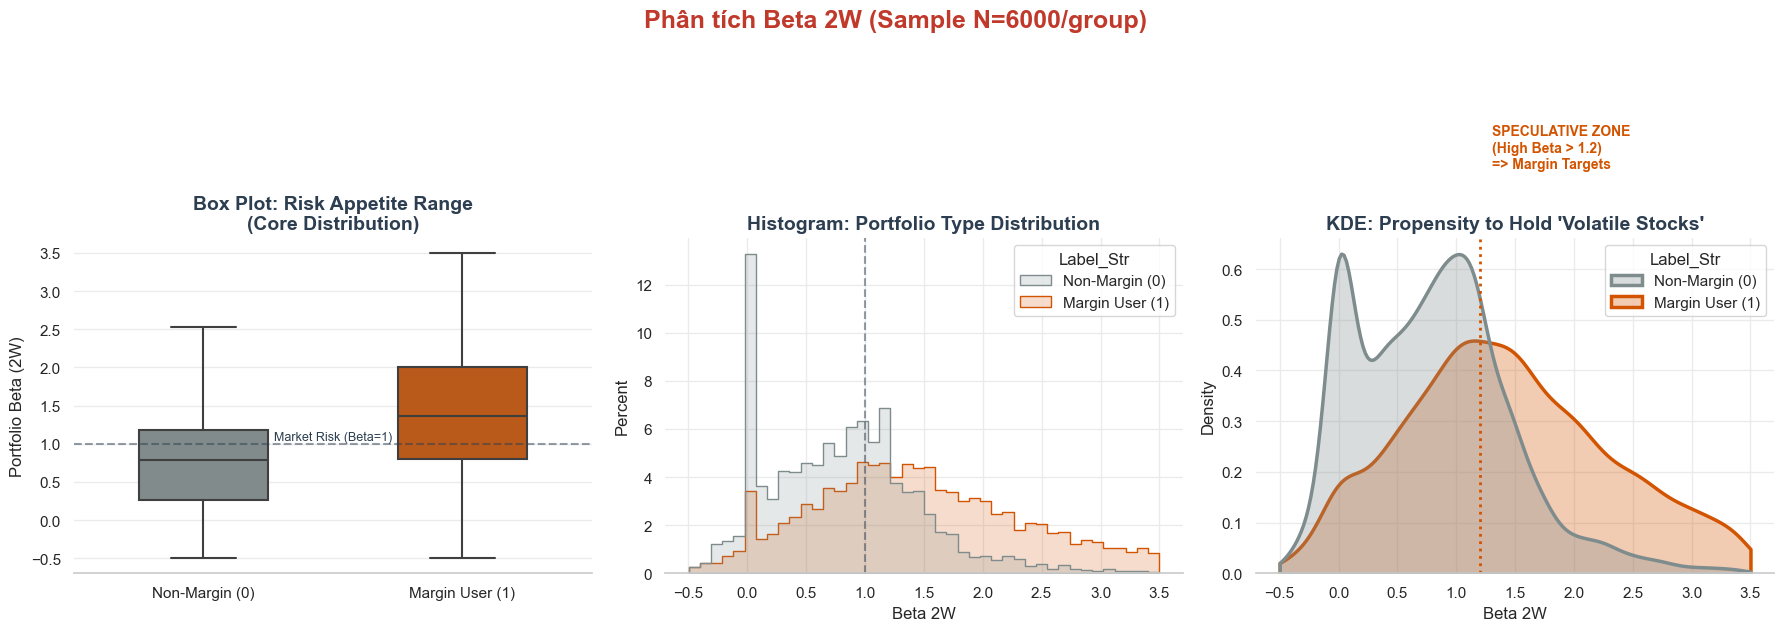

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ==============================================================================
# 1. DATA PREPARATION (BALANCED SAMPLING)
# ==============================================================================
n_samples = 6000  # 3000 mẫu mỗi nhóm

# Lấy mẫu cân bằng
df_0 = df[df['loan_label_next'] == 0].sample(n=min(n_samples, len(df[df['loan_label_next'] == 0])), random_state=42)
df_1 = df[df['loan_label_next'] == 1].sample(n=min(n_samples, len(df[df['loan_label_next'] == 1])), random_state=42)

# Gán nhãn text
df_0['Label_Str'] = 'Non-Margin (0)'
df_1['Label_Str'] = 'Margin User (1)'

# Ghép dữ liệu
df_viz = pd.concat([df_0, df_1])

# Lọc nhiễu: Beta thường nằm trong khoảng -0.5 đến 4. 
# Các giá trị ngoài khoảng này thường là do thanh khoản thấp hoặc lỗi dữ liệu.
df_viz_clean = df_viz[df_viz['beta_2w'].between(-0.5, 3.5)]

# ==============================================================================
# 2. SETUP STYLE & PALETTE
# ==============================================================================
# Palette: 0 (Phòng thủ) = Xanh Đá, 1 (Tấn công) = Cam Đậm
custom_palette = {'Non-Margin (0)': '#7F8C8D', 'Margin User (1)': '#D35400'} 
sns.set_theme(style="whitegrid", rc={"grid.color": ".92", "axes.edgecolor": ".8"})

# ==============================================================================
# 3. PLOTTING FUNCTION
# ==============================================================================
def plot_beta_portrait(data, variable='beta_2w'):
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # --- Plot 1: Box Plot (So sánh mức độ rủi ro trung bình) ---
    sns.boxplot(
        ax=axes[0], 
        data=data, 
        x='Label_Str', 
        y=variable, 
        palette=custom_palette,
        linewidth=1.5,
        width=0.5,
        showfliers=False
    )
    # Kẻ đường Beta = 1 (Thị trường chung)
    axes[0].axhline(1.0, color='#2C3E50', linestyle='--', alpha=0.5)
    axes[0].text(0.5, 1.05, 'Market Risk (Beta=1)', ha='center', fontsize=9, color='#2C3E50')
    
    axes[0].set_title(f"Box Plot: Risk Appetite Range\n(Core Distribution)", fontsize=14, fontweight='bold', color='#2C3E50')
    axes[0].set_xlabel("")
    axes[0].set_ylabel("Portfolio Beta (2W)")

    # --- Plot 2: Histogram (Tần suất) ---
    sns.histplot(
        ax=axes[1], 
        data=data, 
        x=variable, 
        hue='Label_Str', 
        palette=custom_palette, 
        kde=False, 
        element="step", 
        stat="percent", 
        common_norm=False,
        alpha=0.2
    )
    axes[1].axvline(1.0, color='#2C3E50', linestyle='--', alpha=0.5)
    
    axes[1].set_title(f"Histogram: Portfolio Type Distribution", fontsize=14, fontweight='bold', color='#2C3E50')
    axes[1].set_xlabel("Beta 2W")
    
    # --- Plot 3: KDE Plot (Hình dáng phân phối) ---
    sns.kdeplot(
        ax=axes[2], 
        data=data, 
        x=variable, 
        hue='Label_Str', 
        fill=True, 
        common_norm=False,
        palette=custom_palette, 
        alpha=0.3, 
        linewidth=2.5,
        clip=(-0.5, 3.5)
    )
    
    # Annotation: Vùng "Hàng Nóng" (Speculative Zone)
    axes[2].axvline(1.2, color='#D35400', linestyle=':', linewidth=2)
    axes[2].text(1.3, 0.8, "SPECULATIVE ZONE\n(High Beta > 1.2)\n=> Margin Targets", 
                 color='#D35400', fontweight='bold', ha='left', fontsize=10)
    
    axes[2].set_title(f"KDE: Propensity to Hold 'Volatile Stocks'", fontsize=14, fontweight='bold', color='#2C3E50')
    axes[2].set_xlabel("Beta 2W")
    
    # --- Final Touches ---
    plt.suptitle(f" Phân tích Beta 2W (Sample N={n_samples}/group)", 
                 fontsize=18, fontweight='bold', y=1.05, color='#C0392B')
    sns.despine(left=True)
    plt.tight_layout()
    plt.show()

# Chạy hàm vẽ
plot_beta_portrait(df_viz_clean)

C:\Users\Admin\AppData\Local\Temp\ipykernel_31792\1340694442.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


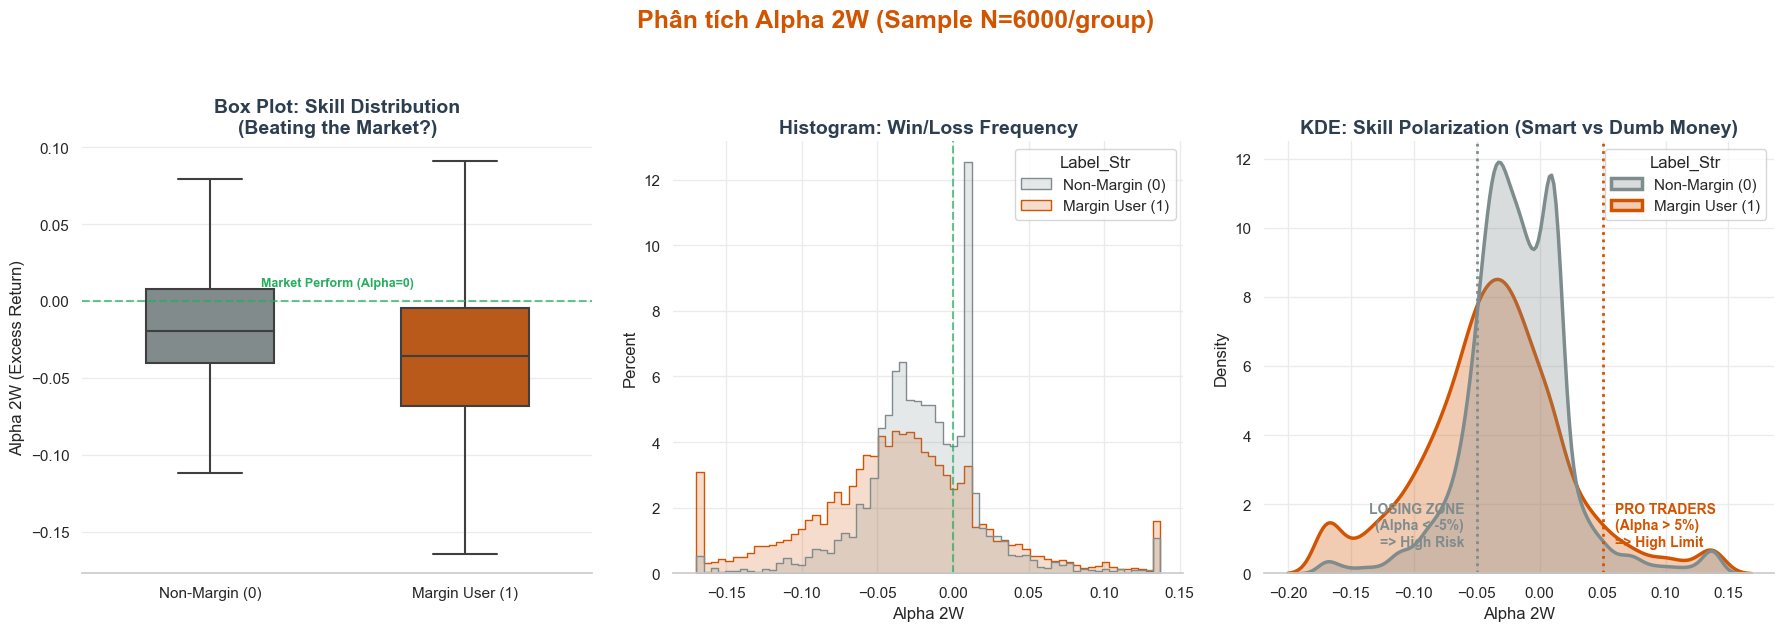

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ==============================================================================
# 1. DATA PREPARATION (BALANCED SAMPLING)
# ==============================================================================
n_samples = 6000 # Giữ nguyên mẫu lớn 6000/nhóm

# Lấy mẫu cân bằng
df_0 = df[df['loan_label_next'] == 0].sample(n=min(n_samples, len(df[df['loan_label_next'] == 0])), random_state=42)
df_1 = df[df['loan_label_next'] == 1].sample(n=min(n_samples, len(df[df['loan_label_next'] == 1])), random_state=42)

# Gán nhãn text
df_0['Label_Str'] = 'Non-Margin (0)'
df_1['Label_Str'] = 'Margin User (1)'

# Ghép dữ liệu
df_viz = pd.concat([df_0, df_1])

# Lọc nhiễu: Alpha 2 tuần thường nằm trong biên độ +/- 25%.
df_viz_clean = df_viz[df_viz['alpha_2w'].between(-0.25, 0.25)]

# ==============================================================================
# 2. SETUP STYLE & PALETTE (ĐỒNG BỘ MÀU CŨ)
# ==============================================================================
# Palette: 0 = Xám Đá (An toàn), 1 = Cam Đậm (Rủi ro/Hành động) -> Giống chart Beta
custom_palette = {'Non-Margin (0)': '#7F8C8D', 'Margin User (1)': '#D35400'} 
sns.set_theme(style="whitegrid", rc={"grid.color": ".92", "axes.edgecolor": ".8"})

# ==============================================================================
# 3. PLOTTING FUNCTION
# ==============================================================================
def plot_alpha_portrait(data, variable='alpha_2w'):
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # --- Plot 1: Box Plot (So sánh kỹ năng/hiệu quả) ---
    sns.boxplot(
        ax=axes[0], 
        data=data, 
        x='Label_Str', 
        y=variable, 
        palette=custom_palette,
        linewidth=1.5,
        width=0.5,
        showfliers=False
    )
    # Kẻ đường Alpha = 0 (Hiệu suất ngang thị trường) dùng màu xanh lá để làm mốc chuẩn
    axes[0].axhline(0, color='#27AE60', linestyle='--', linewidth=1.5, alpha=0.7)
    axes[0].text(0.5, 0.01, 'Market Perform (Alpha=0)', ha='center', fontsize=9, color='#27AE60', fontweight='bold')
    
    axes[0].set_title(f"Box Plot: Skill Distribution\n(Beating the Market?)", fontsize=14, fontweight='bold', color='#2C3E50')
    axes[0].set_xlabel("")
    axes[0].set_ylabel("Alpha 2W (Excess Return)")

    # --- Plot 2: Histogram (Tần suất Thắng/Thua) ---
    sns.histplot(
        ax=axes[1], 
        data=data, 
        x=variable, 
        hue='Label_Str', 
        palette=custom_palette, 
        kde=False, 
        element="step", 
        stat="percent", 
        common_norm=False,
        alpha=0.2
    )
    axes[1].axvline(0, color='#27AE60', linestyle='--', linewidth=1.5, alpha=0.7)
    
    axes[1].set_title(f"Histogram: Win/Loss Frequency", fontsize=14, fontweight='bold', color='#2C3E50')
    axes[1].set_xlabel("Alpha 2W")
    
    # --- Plot 3: KDE Plot (Phân cực Kỹ năng) ---
    sns.kdeplot(
        ax=axes[2], 
        data=data, 
        x=variable, 
        hue='Label_Str', 
        fill=True, 
        common_norm=False,
        palette=custom_palette, 
        alpha=0.3, 
        linewidth=2.5,
        clip=(-0.25, 0.25)
    )
    
    # Annotation: Vùng "Thiên Tài" (Pro Traders) - Dùng màu Cam của nhóm 1 để nhấn mạnh
    axes[2].axvline(0.05, color='#D35400', linestyle=':', linewidth=2)
    axes[2].text(0.06, 0.8, "PRO TRADERS\n(Alpha > 5%)\n=> High Limit", 
                 color='#D35400', fontweight='bold', ha='left', fontsize=10)
    
    # Annotation: Vùng "Thua Lỗ" (Underperformers) - Dùng màu Xám của nhóm 0 để cảnh báo
    axes[2].axvline(-0.05, color='#7F8C8D', linestyle=':', linewidth=2)
    axes[2].text(-0.06, 0.8, "LOSING ZONE\n(Alpha < -5%)\n=> High Risk", 
                 color='#7F8C8D', fontweight='bold', ha='right', fontsize=10)
    
    axes[2].set_title(f"KDE: Skill Polarization (Smart vs Dumb Money)", fontsize=14, fontweight='bold', color='#2C3E50')
    axes[2].set_xlabel("Alpha 2W")
    
    # --- Final Touches ---
    plt.suptitle(f" Phân tích Alpha 2W (Sample N={n_samples}/group)", 
                 fontsize=18, fontweight='bold', y=1.05, color='#D35400') # Màu tiêu đề theo màu Margin
    sns.despine(left=True)
    plt.tight_layout()
    plt.show()

# Chạy hàm vẽ
plot_alpha_portrait(df_viz_clean)

C:\Users\Admin\AppData\Local\Temp\ipykernel_31792\1209365617.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


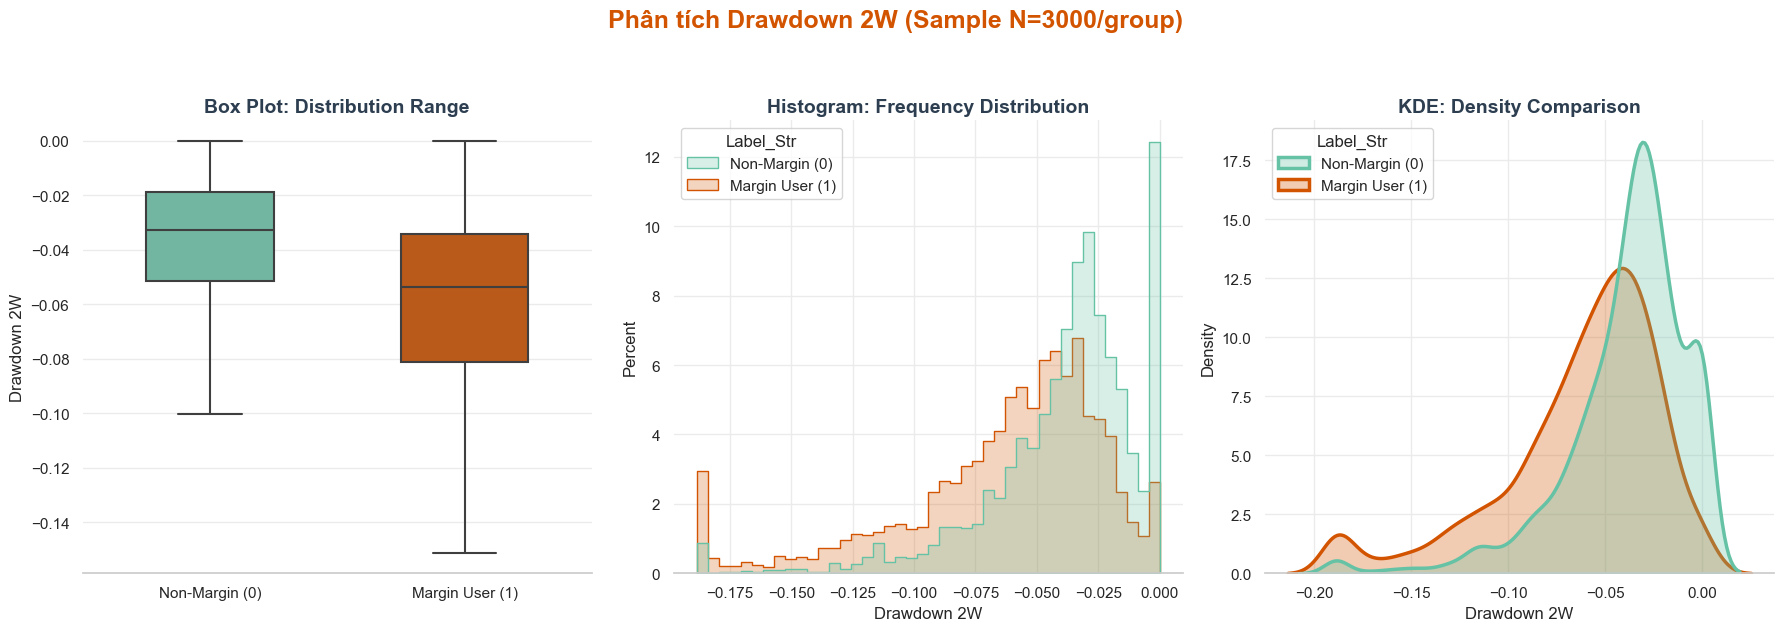

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ==============================================================================
# 1. DATA PREPARATION
# ==============================================================================
n_samples = 3000

# Lấy mẫu cân bằng
df_0 = df[df['loan_label_next'] == 0].sample(n=min(n_samples, len(df[df['loan_label_next'] == 0])), random_state=42)
df_1 = df[df['loan_label_next'] == 1].sample(n=min(n_samples, len(df[df['loan_label_next'] == 1])), random_state=42)

# Gán nhãn
df_0['Label_Str'] = 'Non-Margin (0)'
df_1['Label_Str'] = 'Margin User (1)'

df_viz = pd.concat([df_0, df_1])

# ==============================================================================
# 2. PLOTTING (CLEAN VERSION)
# ==============================================================================
# Palette: Xanh Mint (An toàn) vs Cam Đất (Lỗ/Rủi ro)
custom_palette = {'Non-Margin (0)': '#66C2A5', 'Margin User (1)': '#D35400'} 
sns.set_theme(style="whitegrid", rc={"grid.color": ".92", "axes.edgecolor": ".8"})

def plot_drawdown_clean(data, variable='drawdown_2w'):
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # --- Plot 1: Box Plot ---
    sns.boxplot(
        ax=axes[0], 
        data=data, 
        x='Label_Str', 
        y=variable, 
        palette=custom_palette,
        linewidth=1.5,
        width=0.5,
        showfliers=False
    )
    axes[0].set_title("Box Plot: Distribution Range", fontsize=14, fontweight='bold', color='#2C3E50')
    axes[0].set_xlabel("")
    axes[0].set_ylabel("Drawdown 2W")

    # --- Plot 2: Histogram ---
    sns.histplot(
        ax=axes[1], 
        data=data, 
        x=variable, 
        hue='Label_Str', 
        palette=custom_palette, 
        kde=False, 
        element="step", 
        stat="percent", 
        common_norm=False,
        alpha=0.25
    )
    axes[1].set_title("Histogram: Frequency Distribution", fontsize=14, fontweight='bold', color='#2C3E50')
    axes[1].set_xlabel("Drawdown 2W")
    
    # --- Plot 3: KDE Plot ---
    sns.kdeplot(
        ax=axes[2], 
        data=data, 
        x=variable, 
        hue='Label_Str', 
        fill=True, 
        common_norm=False,
        palette=custom_palette, 
        alpha=0.3, 
        linewidth=2.5
    )
    axes[2].set_title("KDE: Density Comparison", fontsize=14, fontweight='bold', color='#2C3E50')
    axes[2].set_xlabel("Drawdown 2W")
    
    # --- Final Layout ---
    plt.suptitle(f" Phân tích Drawdown 2W (Sample N={n_samples}/group)", 
                 fontsize=18, fontweight='bold', y=1.05, color='#D35400')
    sns.despine(left=True)
    plt.tight_layout()
    plt.show()

# Chạy hàm vẽ
plot_drawdown_clean(df_viz)

In [ ]:
df.dtypes

loan_label_next                       int64
trading_count_12m                     int64
unique_shares_12m                     int64
trading_count_3m                      int64
unique_shares_3m                      int64
unique_shares_2w                      int64
alpha_2w                            float64
beta_2w                             float64
drawdown_2w                         float64
buy_intensity_3m                    float64
buy_intensity_negative_3m           float64
login_ratio_2w                      float64
login_trend                         float64
flow_ratio_3m                       float64
flow_ratio_12m                      float64
buy_sell_pressure_3m                float64
buy_sell_pressure_12m               float64
order_buy_ratio_3m                  float64
order_buy_ratio_12m                 float64
order_sell_ratio_3m                 float64
order_sell_ratio_12m                float64
total_buy_ratio_3m                  float64
total_buy_ratio_12m             

c:\Users\Admin\.conda\envs\py39\lib\site-packages\numpy\lib\_function_base_impl.py:2767: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\Admin\AppData\Local\Temp\ipykernel_31792\1804817374.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


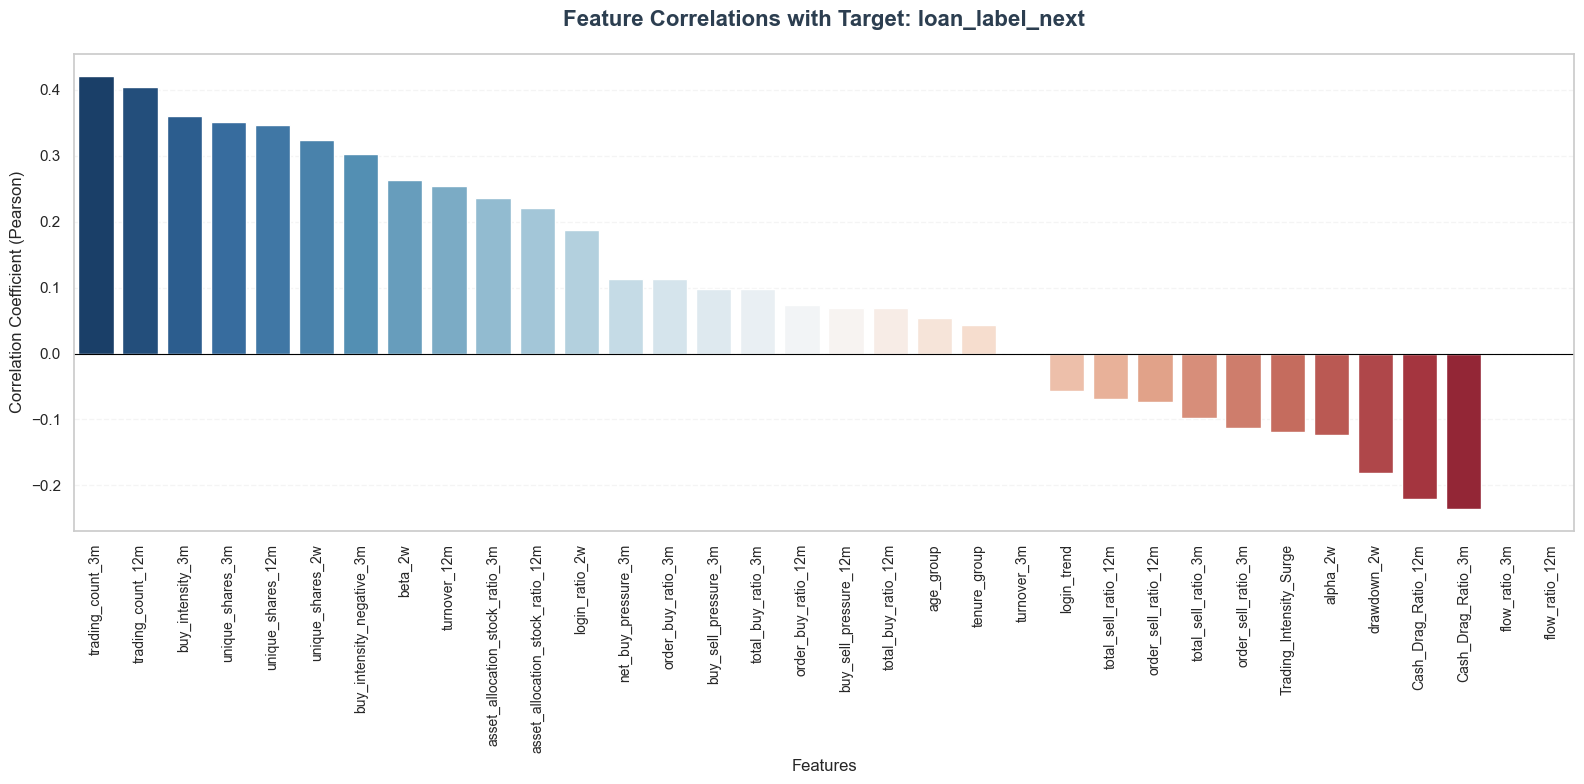

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ==============================================================================
# 1. TÍNH TOÁN TƯƠNG QUAN (CORRELATION)
# ==============================================================================
target = 'loan_label_next'

# Chỉ lấy các cột số (Numerical)
df_numeric = df.select_dtypes(include=['number'])

# Tính tương quan của tất cả các biến với target
corr_data = df_numeric.corrwith(df[target]).sort_values(ascending=False)

# Loại bỏ chính biến target ra khỏi danh sách (vì corr = 1)
corr_data = corr_data.drop(target)

# ==============================================================================
# 2. VẼ BIỂU ĐỒ (VERTICAL BAR PLOT)
# ==============================================================================
plt.figure(figsize=(16, 8)) # Kéo dài chiều ngang để đủ chỗ cho tên biến

# Tạo màu sắc: Đỏ cho dương, Xanh cho âm
# Dùng palette 'coolwarm' hoặc 'RdBu_r' để thể hiện tính đối lập
colors = sns.color_palette("RdBu_r", n_colors=len(corr_data))

# Nếu muốn map màu chính xác theo giá trị (Dương=Đỏ, Âm=Xanh):
# norm = plt.Normalize(corr_data.min(), corr_data.max())
# colors = plt.cm.RdBu_r(norm(corr_data.values))

ax = sns.barplot(
    x=corr_data.index, 
    y=corr_data.values, 
    palette=colors
)

# --- TRANG TRÍ ---
plt.title(f"Feature Correlations with Target: {target}", fontsize=16, fontweight='bold', color='#2C3E50', pad=20)
plt.ylabel("Correlation Coefficient (Pearson)", fontsize=12)
plt.xlabel("Features", fontsize=12)

# Xoay tên biến 90 độ để không bị đè lên nhau
plt.xticks(rotation=90, fontsize=10)
plt.axhline(0, color='black', linewidth=0.8) # Đường kẻ ngang ở mức 0

# Grid mờ
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

c:\Users\Admin\.conda\envs\py39\lib\site-packages\pandas\core\nanops.py:1256: RuntimeWarning: invalid value encountered in subtract
  adjusted = values - mean
c:\Users\Admin\.conda\envs\py39\lib\site-packages\pandas\core\nanops.py:1256: RuntimeWarning: invalid value encountered in subtract
  adjusted = values - mean


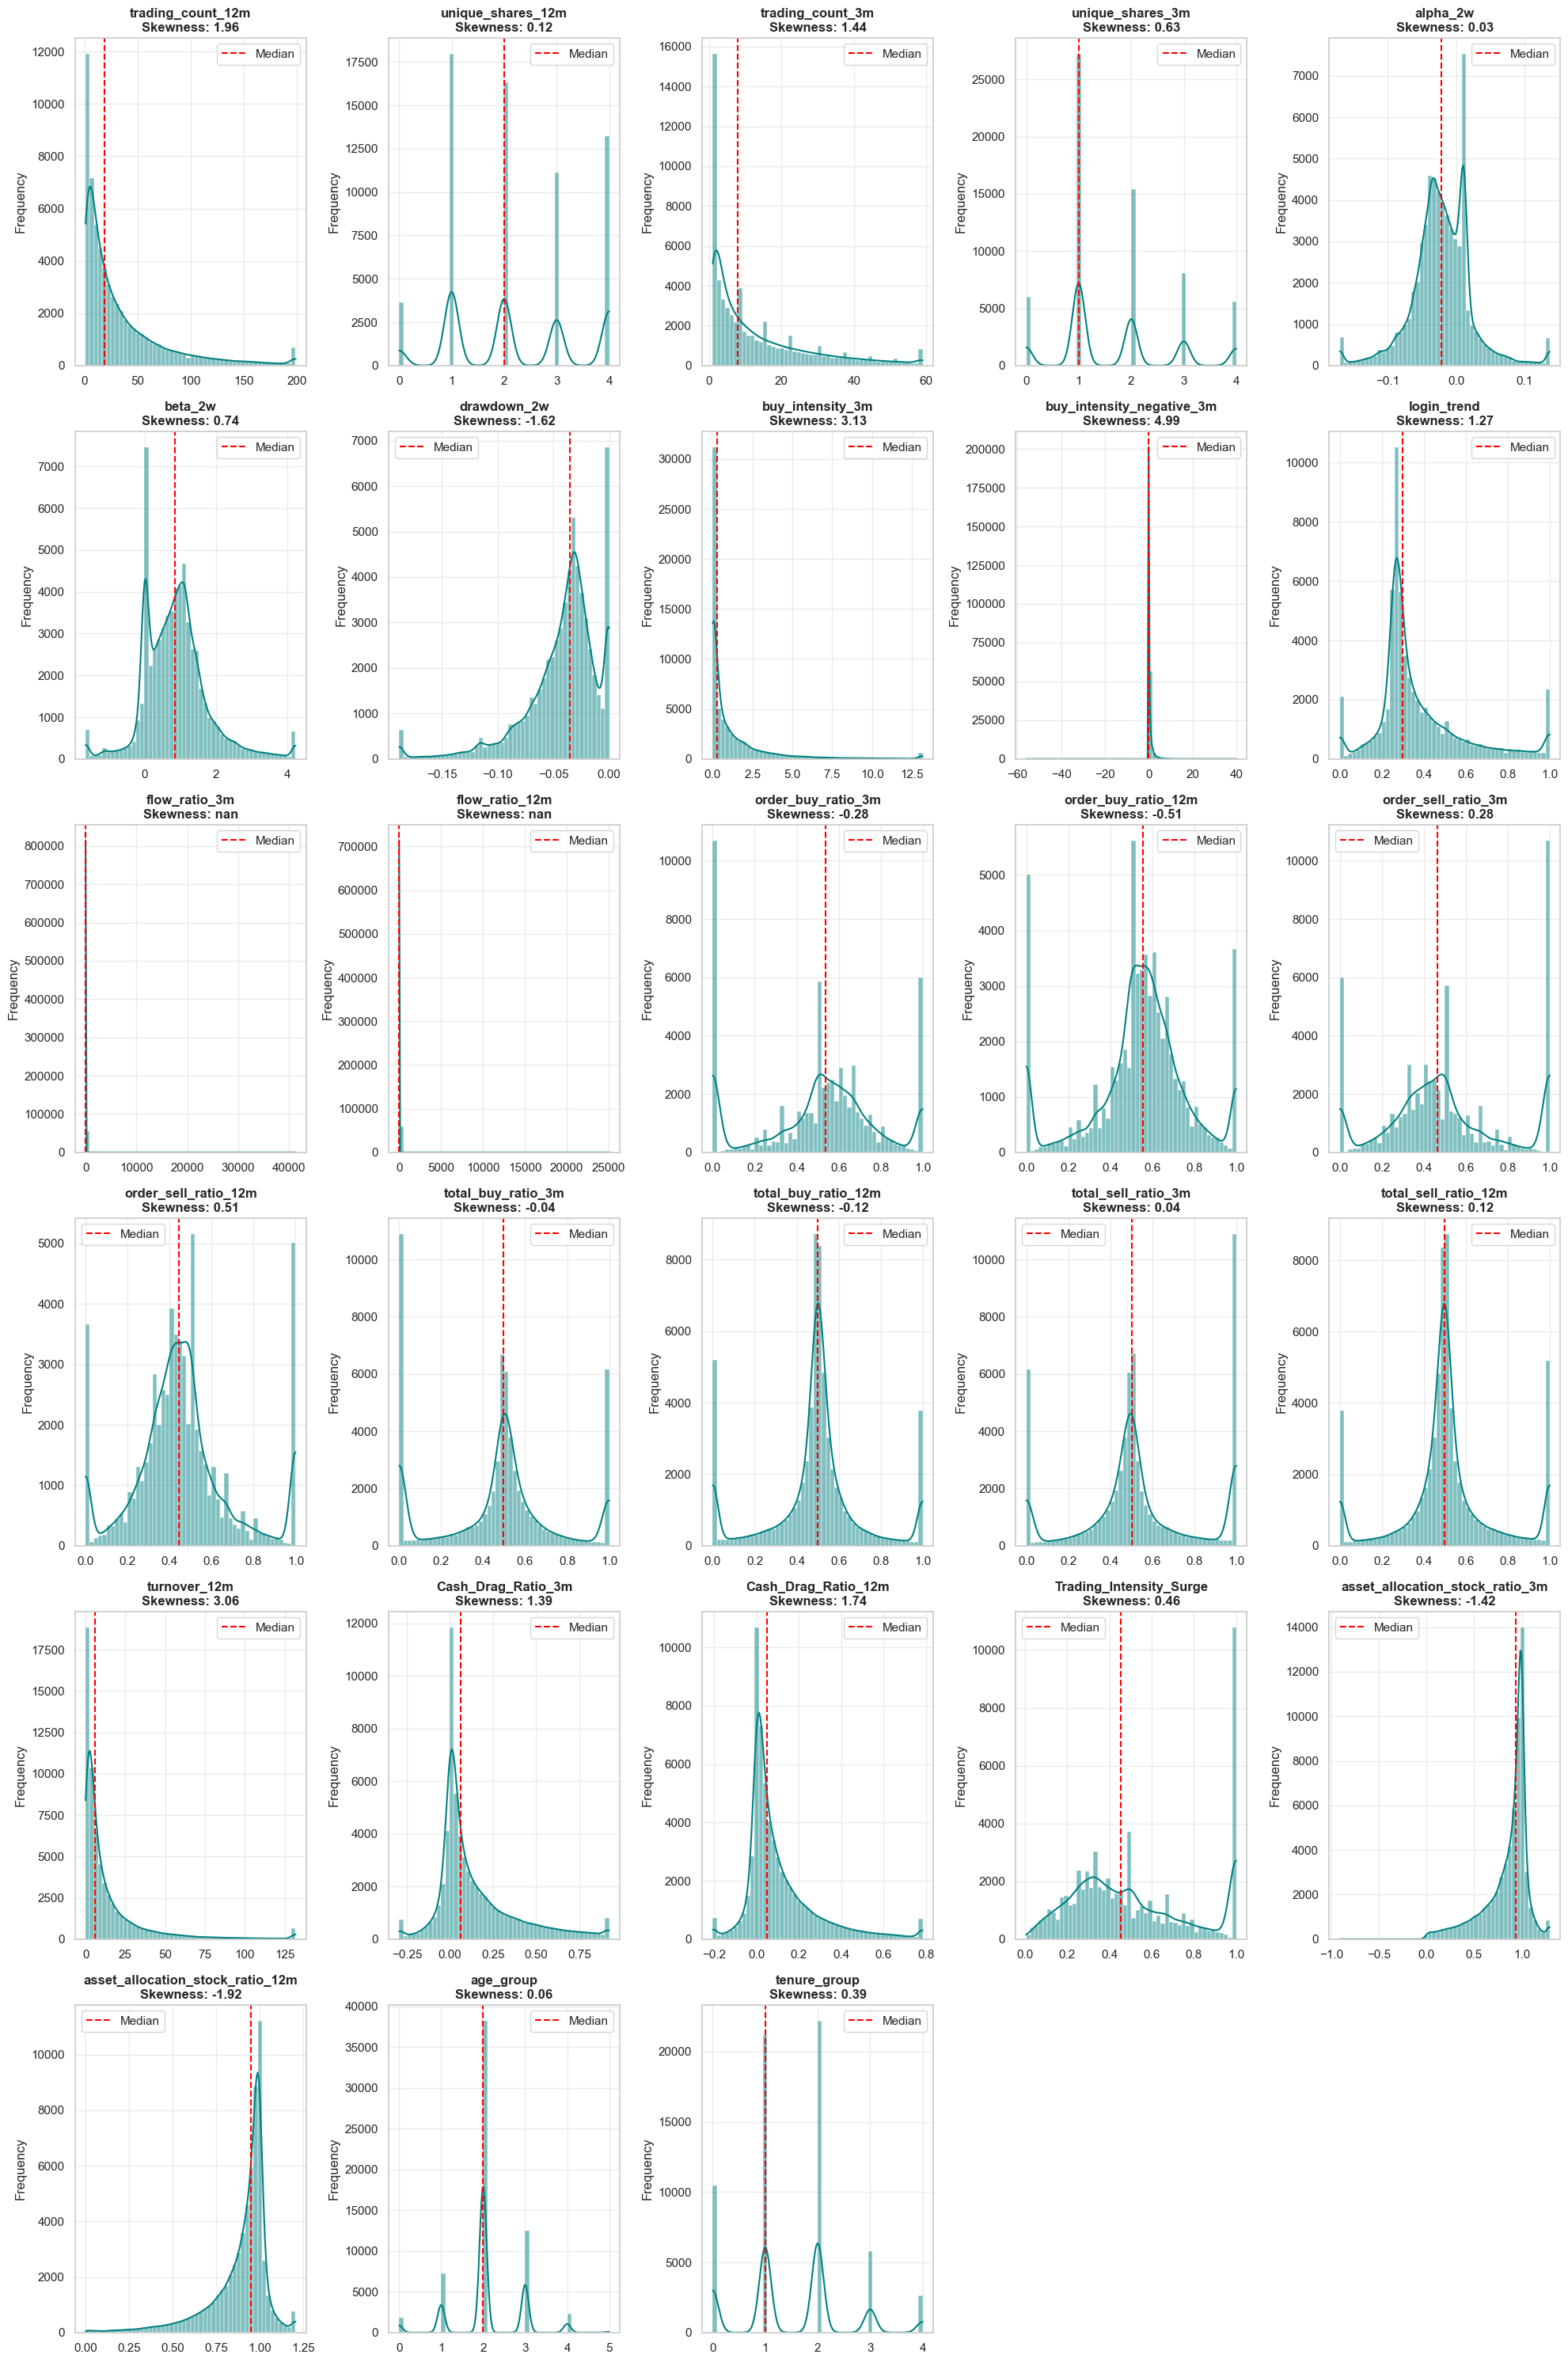

In [205]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

def check_money_distribution(df, cols_to_check):
    """
    Vẽ biểu đồ phân phối và tính độ lệch (Skewness)
    """

    valid_cols = [c for c in cols_to_check if c in df.columns]
    
    n_cols = 5
    n_rows = (len(valid_cols) + n_cols - 1) // n_cols
    
    plt.figure(figsize=(20, 5 * n_rows))
    
    for i, col in enumerate(valid_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        
        # 1. Vẽ Histogram và đường KDE (Kernel Density Estimate)
        sns.histplot(df[col], kde=True, color='teal', bins=50)
        

        skew_val = df[col].skew()
        
        # 3. Trang trí
        plt.title(f'{col}\nSkewness: {skew_val:.2f}', fontsize=12, fontweight='bold')
        plt.xlabel('')
        plt.ylabel('Frequency')
        
        # Thêm đường kẻ dọc tại trung vị (Median)
        plt.axvline(df[col].median(), color='red', linestyle='--', label='Median')
        plt.legend()

    plt.tight_layout()
    plt.show()

# --- DANH SÁCH CÁC TRƯỜNG TIỀN TỆ CẦN KIỂM TRA ---

money_cols_to_check = [
    # Nhóm Log1p
       'avg_nav_ck_12m', 'total_trading_amount_12m',
       'trading_count_12m', 'unique_shares_12m', 'trading_count_3m',
       'unique_shares_3m', 'profit_ratio_12m', 'profit_ratio_3m', 'alpha_2w',
       'beta_2w', 'drawdown_2w', 'buy_intensity_3m',
       'buy_intensity_negative_3m', 'login_trend', 'flow_ratio_3m',
       'flow_ratio_12m', 'order_buy_ratio_3m', 'order_buy_ratio_12m',
       'order_sell_ratio_3m', 'order_sell_ratio_12m', 'total_buy_ratio_3m',
       'total_buy_ratio_12m', 'total_sell_ratio_3m', 'total_sell_ratio_12m',
       'turnover_12m', 'Cash_Drag_Ratio_3m', 'Cash_Drag_Ratio_12m',
       'Trading_Intensity_Surge', 'asset_allocation_stock_ratio_3m',
       'asset_allocation_stock_ratio_12m', 'age_group', 'tenure_group'
]

check_money_distribution(df, money_cols_to_check)

[LightGBM] [Info] Number of positive: 9622, number of negative: 52687
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5891
[LightGBM] [Info] Number of data points in the train set: 62309, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.154424 -> initscore=-1.700317
[LightGBM] [Info] Start training from score -1.700317


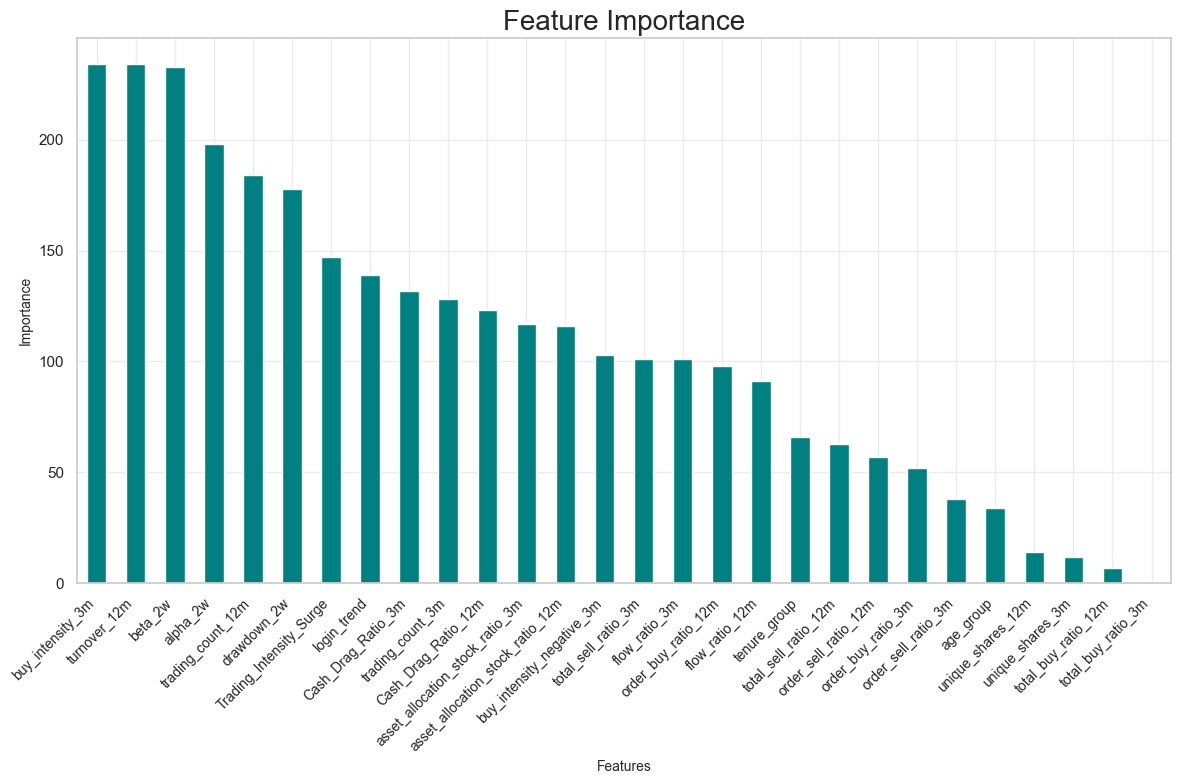


--- Feature Importance (Top 10) ---
buy_intensity_3m           234
turnover_12m               234
beta_2w                    233
alpha_2w                   198
trading_count_12m          184
drawdown_2w                178
Trading_Intensity_Surge    147
login_trend                139
Cash_Drag_Ratio_3m         132
trading_count_3m           128
dtype: int32


In [206]:
from catboost import CatBoostClassifier
from matplotlib import pyplot as plt
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier



X = df.drop(columns="loan_label_next", axis=1, errors='ignore')
y = df['loan_label_next']




rf = LGBMClassifier(random_state=42)
rf.fit(X, y)


feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 8)) # Điều chỉnh kích thước biểu đồ cho dễ nhìn
feature_importance.plot(kind='bar', color='teal')
plt.title('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=10)
plt.ylabel('Importance', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=10) # Xoay nhãn trục x để dễ đọc
plt.tight_layout() # Đảm bảo tất cả nhãn đều hiển thị
plt.show()

print("\n--- Feature Importance (Top 10) ---")
print(feature_importance.head(10))

In [207]:
df.columns

Index(['loan_label_next', 'trading_count_12m', 'unique_shares_12m',
       'trading_count_3m', 'unique_shares_3m', 'alpha_2w', 'beta_2w',
       'drawdown_2w', 'buy_intensity_3m', 'buy_intensity_negative_3m',
       'login_trend', 'flow_ratio_3m', 'flow_ratio_12m', 'order_buy_ratio_3m',
       'order_buy_ratio_12m', 'order_sell_ratio_3m', 'order_sell_ratio_12m',
       'total_buy_ratio_3m', 'total_buy_ratio_12m', 'total_sell_ratio_3m',
       'total_sell_ratio_12m', 'turnover_12m', 'Cash_Drag_Ratio_3m',
       'Cash_Drag_Ratio_12m', 'Trading_Intensity_Surge',
       'asset_allocation_stock_ratio_3m', 'asset_allocation_stock_ratio_12m',
       'age_group', 'tenure_group'],
      dtype='object')

In [208]:
# Thay thế inf bằng NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)


# Sau đó xử lý NaN — ví dụ: thay bằng 0, hoặc dùng fillna(method='ffill'), hoặc drop
df.fillna(0, inplace=True) 


In [ ]:
df.columns

Index(['loan_label_next', 'trading_count_12m', 'unique_shares_12m',
       'trading_count_3m', 'unique_shares_3m', 'alpha_2w', 'beta_2w',
       'drawdown_2w', 'buy_intensity_3m', 'buy_intensity_negative_3m',
       'login_trend', 'flow_ratio_3m', 'flow_ratio_12m', 'order_buy_ratio_3m',
       'order_buy_ratio_12m', 'order_sell_ratio_3m', 'order_sell_ratio_12m',
       'total_buy_ratio_3m', 'total_buy_ratio_12m', 'total_sell_ratio_3m',
       'total_sell_ratio_12m', 'turnover_12m', 'Cash_Drag_Ratio_3m',
       'Cash_Drag_Ratio_12m', 'Trading_Intensity_Surge',
       'asset_allocation_stock_ratio_3m', 'asset_allocation_stock_ratio_12m',
       'age_group', 'tenure_group'],
      dtype='object')

## Handle Hard Negative

In [209]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# ==============================================================================
# 1. HÀM LỌC HARD NEGATIVES (Cosine Similarity)
# ==============================================================================
def filter_hard_negatives_cosine(df, features, label_col='loan_label_next'):
    """
    Tìm Label 0 có độ tương đồng Cosine cao nhất với bất kỳ Label 1 nào.
    - Những mẫu này (Hard Negatives) sẽ bị loại khỏi tập train để model đỡ nhiễu.
    - Đồng thời, chúng chính là danh sách 'Leads' để gửi cho Sale.
    """
    print(f"--- BẮT ĐẦU LỌC: COSINE SIMILARITY ---")
    print(f"Tổng mẫu đầu vào: {len(df)}")
    
    # 1. Tạo bản sao tạm thời để Scale (tránh ảnh hưởng df gốc)
    # Fillna = 0 để đảm bảo tính toán được khoảng cách
    X_temp = df[features].fillna(0)
    
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X_temp), columns=features, index=df.index)
    X_scaled['target'] = df[label_col]
    
    # 2. Tách Label 0 và Label 1 (Dạng Scaled)
    X_0 = X_scaled[X_scaled['target'] == 0].drop(columns=['target'])
    X_1 = X_scaled[X_scaled['target'] == 1].drop(columns=['target'])
    
    print(f"Đang so sánh {len(X_0)} mẫu Label 0 (Non-Margin) với {len(X_1)} mẫu Label 1 (Margin)...")
    
    # 3. Tìm láng giềng gần nhất (Nearest Neighbor)
    # n_neighbors=1: Tìm 1 thằng Label 1 giống nhất với thằng Label 0 đang xét
    nbrs = NearestNeighbors(n_neighbors=1, metric='cosine', n_jobs=-1).fit(X_1)
    
    # Tính khoảng cách từ mỗi điểm X_0 đến điểm gần nhất trong X_1
    distances, indices = nbrs.kneighbors(X_0)
    
    # Cosine Similarity = 1 - Cosine Distance
    similarities = 1 - distances.flatten()
    
    # 4. Xác định ngưỡng lọc (Top 15% giống nhất)
    # Bạn có thể điều chỉnh số 85 (Top 15%) thành 90 (Top 10%) hoặc 80 (Top 20%) tùy nhu cầu
    percentile_threshold = np.percentile(similarities, 80) 
    
    # Tạo mask: True là những dòng QUÁ GIỐNG Label 1 -> Cần loại bỏ khỏi tập 0
    hard_negative_mask = similarities > percentile_threshold
    
    # Lấy ra Index của các dòng cần xóa (Đây chính là Leads tiềm năng)
    indices_to_drop = X_0.index[hard_negative_mask]
    
    print(f"Ngưỡng Similarity (Top 15%): {percentile_threshold:.4f}")
    print(f"-> Đã lọc ra {len(indices_to_drop)} mẫu Label 0 có hành vi giống Label 1.")
    
    # 5. Tách DataFrame
    # df_cleaned: Dùng để Train Model (Đã sạch nhiễu)
    # df_leads: Dùng để gửi cho Sale (Khách chưa vay nhưng hành vi giống hệt người vay)
    df_cleaned = df.drop(index=indices_to_drop)
    df_leads = df.loc[indices_to_drop]
    
    return df_cleaned, df_leads

# ==============================================================================
# 2. CHẠY PIPELINE
# ==============================================================================

# Danh sách feature (Đã update theo danh sách mới của bạn)
feature_cols = [
       'trading_count_12m', 'unique_shares_12m',
       'trading_count_3m', 'unique_shares_3m', 'alpha_2w', 'beta_2w',
       'drawdown_2w', 'buy_intensity_3m', 'buy_intensity_negative_3m',
       'login_trend', 'flow_ratio_3m', 'flow_ratio_12m', 'order_buy_ratio_3m',
       'order_buy_ratio_12m', 'order_sell_ratio_3m', 'order_sell_ratio_12m',
       'total_buy_ratio_3m', 'total_buy_ratio_12m', 'total_sell_ratio_3m',
       'total_sell_ratio_12m', 'turnover_12m', 'Cash_Drag_Ratio_3m',
       'Cash_Drag_Ratio_12m', 'Trading_Intensity_Surge',
       'asset_allocation_stock_ratio_3m', 'asset_allocation_stock_ratio_12m',
       'age_group', 'tenure_group'
]

# --- THỰC HIỆN LỌC ---
# Lưu ý: Truyền thẳng df gốc vào hàm này
df_clean, df_potential_leads = filter_hard_negatives_cosine(
    df, 
    features=feature_cols
)

# ==============================================================================
# 3. KẾT QUẢ
# ==============================================================================
print("\n--- TỔNG KẾT ---")
print(f"1. Số lượng mẫu sạch (df_clean): {len(df_clean)}")
print(f"   -> Dùng tập này để Train Model (giúp model phân biệt rạch ròi 0 và 1 hơn).")
print(f"2. Số lượng Leads (df_potential_leads): {len(df_potential_leads)}")
print(f"   -> Xuất file excel tập này gửi cho Business team.")

--- BẮT ĐẦU LỌC: COSINE SIMILARITY ---
Tổng mẫu đầu vào: 62309
Đang so sánh 52687 mẫu Label 0 (Non-Margin) với 9622 mẫu Label 1 (Margin)...
Ngưỡng Similarity (Top 15%): 0.9460
-> Đã lọc ra 10538 mẫu Label 0 có hành vi giống Label 1.

--- TỔNG KẾT ---
1. Số lượng mẫu sạch (df_clean): 51771
   -> Dùng tập này để Train Model (giúp model phân biệt rạch ròi 0 và 1 hơn).
2. Số lượng Leads (df_potential_leads): 10538
   -> Xuất file excel tập này gửi cho Business team.


In [210]:
df_clean.loan_label_next.value_counts()

loan_label_next
0    42149
1     9622
Name: count, dtype: int64

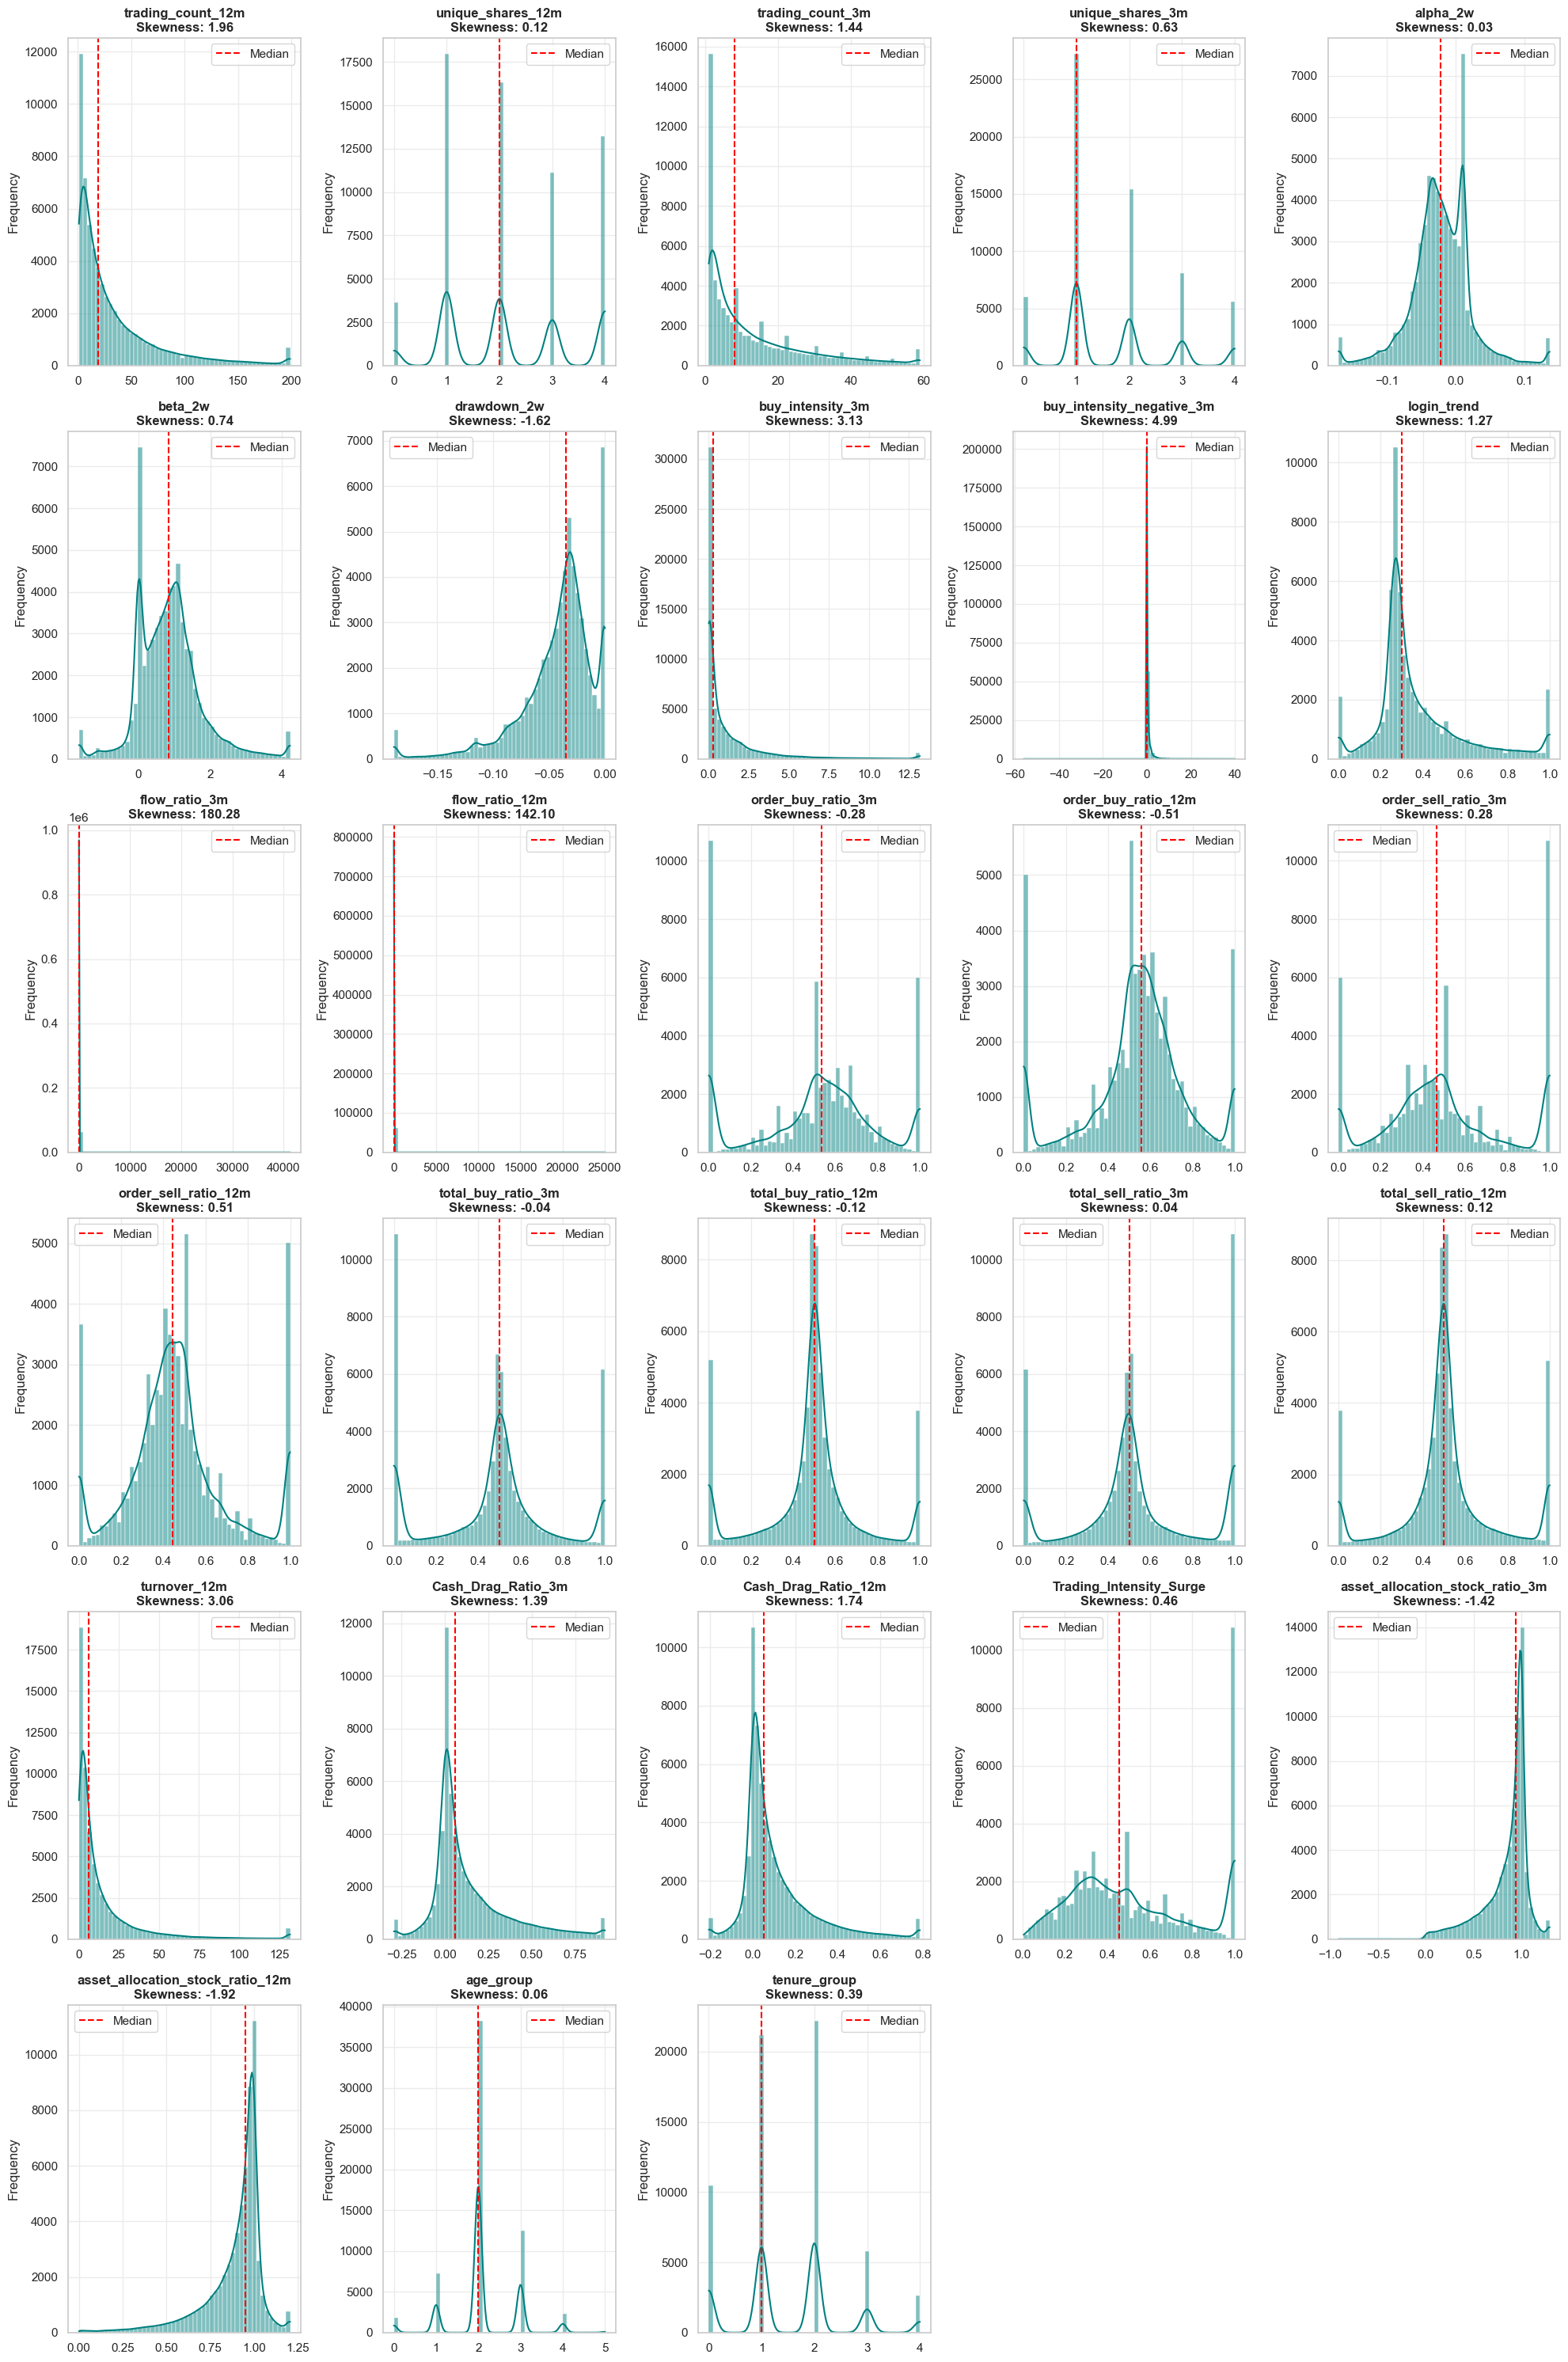

In [211]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

def check_money_distribution(df, cols_to_check):
    """
    Vẽ biểu đồ phân phối và tính độ lệch (Skewness)
    """

    valid_cols = [c for c in cols_to_check if c in df.columns]
    
    n_cols = 5
    n_rows = (len(valid_cols) + n_cols - 1) // n_cols
    
    plt.figure(figsize=(20, 5 * n_rows))
    
    for i, col in enumerate(valid_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        
        # 1. Vẽ Histogram và đường KDE (Kernel Density Estimate)
        sns.histplot(df[col], kde=True, color='teal', bins=50)
        

        skew_val = df[col].skew()
        
        # 3. Trang trí
        plt.title(f'{col}\nSkewness: {skew_val:.2f}', fontsize=12, fontweight='bold')
        plt.xlabel('')
        plt.ylabel('Frequency')
        
        # Thêm đường kẻ dọc tại trung vị (Median)
        plt.axvline(df[col].median(), color='red', linestyle='--', label='Median')
        plt.legend()

    plt.tight_layout()
    plt.show()

# --- DANH SÁCH CÁC TRƯỜNG TIỀN TỆ CẦN KIỂM TRA ---

money_cols_to_check = [
    # Nhóm Log1p
        'avg_nav_ck_12m', 'total_trading_amount_12m',
       'trading_count_12m', 'unique_shares_12m', 'trading_count_3m',
       'unique_shares_3m', 'profit_ratio_12m', 'profit_ratio_3m', 'alpha_2w',
       'beta_2w', 'drawdown_2w', 'buy_intensity_3m',
       'buy_intensity_negative_3m', 'login_trend', 'flow_ratio_3m',
       'flow_ratio_12m', 'order_buy_ratio_3m', 'order_buy_ratio_12m',
       'order_sell_ratio_3m', 'order_sell_ratio_12m', 'total_buy_ratio_3m',
       'total_buy_ratio_12m', 'total_sell_ratio_3m', 'total_sell_ratio_12m',
       'turnover_12m', 'Cash_Drag_Ratio_3m', 'Cash_Drag_Ratio_12m',
       'Trading_Intensity_Surge', 'asset_allocation_stock_ratio_3m',
       'asset_allocation_stock_ratio_12m', 'age_group', 'tenure_group'
]

check_money_distribution(df, money_cols_to_check)

### Transform Data

In [212]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer

def transform_final_features(df):
    df_trans = df.copy()
    print("--- BẮT ĐẦU FEATURE TRANSFORMATION ---")

    # ==========================================================================
    # NHÓM 1: TIỀN TỆ & SỐ LƯỢNG LỚN (Luôn Dương) -> Dùng Log1p
    # ==========================================================================
    log_cols = [
       'turnover_12m', 'buy_intensity_3m', 'avg_nav_ck_12m', 'total_trading_amount_12m',
       
     
    ]
    # Lọc cột tồn tại
    log_cols = [c for c in log_cols if c in df_trans.columns]
    
    for col in log_cols:
        df_trans[col] = np.log1p(df_trans[col])
    
    print(f"-> [Log1p] Đã xử lý {len(log_cols)} biến dương lớn (NAV, Trading, Volume...).")

    # ==========================================================================
    # NHÓM 2: SỐ CÓ THỂ ÂM HOẶC PHÂN PHỐI LẠ (Lãi/Lỗ, Dòng tiền) -> Dùng Yeo-Johnson
    # ==========================================================================

    yeo_cols = [
        'profit_ratio_3m', 'profit_ratio_12m',
        'asset_allocation_stock_ratio_3m', 'asset_allocation_stock_ratio_12m',
        'order_buy_sell_pressure_3m','flow_ratio_12m','flow_ratio_3m', 'Cash_Drag_Ratio_3m', 'Cash_Drag_Ratio_12m',
        'buy_intensity_negative_3m', 'drawdown_2w'

    ]
    yeo_cols = [c for c in yeo_cols if c in df_trans.columns]
    
    # standardize=False: Chỉ biến đổi hình dáng phân phối, chưa scale về 0-1 (để làm sau cùng)
    pt = PowerTransformer(method='yeo-johnson', standardize=False)
    
    if yeo_cols:
        df_trans[yeo_cols] = pt.fit_transform(df_trans[yeo_cols])
        print(f"-> [Yeo-Johnson] Đã xử lý {len(yeo_cols)} biến có giá trị âm (Profit, Net Flow...).")

    # ==========================================================================
    # NHÓM 3: TỶ LỆ CHUẨN (RATIO 0-1) -> Giữ nguyên (Sẽ Scale sau)
    # ==========================================================================

    
    print(f"-> [Keep Raw] Các biến tỷ lệ (Ratio 0-1) được giữ nguyên để Scale sau.")


    
    return df_trans

# --- ÁP DỤNG ---
# Giả sử df_clean là dataframe bạn đang có
df_ready_for_scale = transform_final_features(df_clean)

--- BẮT ĐẦU FEATURE TRANSFORMATION ---
-> [Log1p] Đã xử lý 2 biến dương lớn (NAV, Trading, Volume...).
-> [Yeo-Johnson] Đã xử lý 8 biến có giá trị âm (Profit, Net Flow...).
-> [Keep Raw] Các biến tỷ lệ (Ratio 0-1) được giữ nguyên để Scale sau.


In [213]:
df.columns

Index(['loan_label_next', 'trading_count_12m', 'unique_shares_12m',
       'trading_count_3m', 'unique_shares_3m', 'alpha_2w', 'beta_2w',
       'drawdown_2w', 'buy_intensity_3m', 'buy_intensity_negative_3m',
       'login_trend', 'flow_ratio_3m', 'flow_ratio_12m', 'order_buy_ratio_3m',
       'order_buy_ratio_12m', 'order_sell_ratio_3m', 'order_sell_ratio_12m',
       'total_buy_ratio_3m', 'total_buy_ratio_12m', 'total_sell_ratio_3m',
       'total_sell_ratio_12m', 'turnover_12m', 'Cash_Drag_Ratio_3m',
       'Cash_Drag_Ratio_12m', 'Trading_Intensity_Surge',
       'asset_allocation_stock_ratio_3m', 'asset_allocation_stock_ratio_12m',
       'age_group', 'tenure_group'],
      dtype='object')

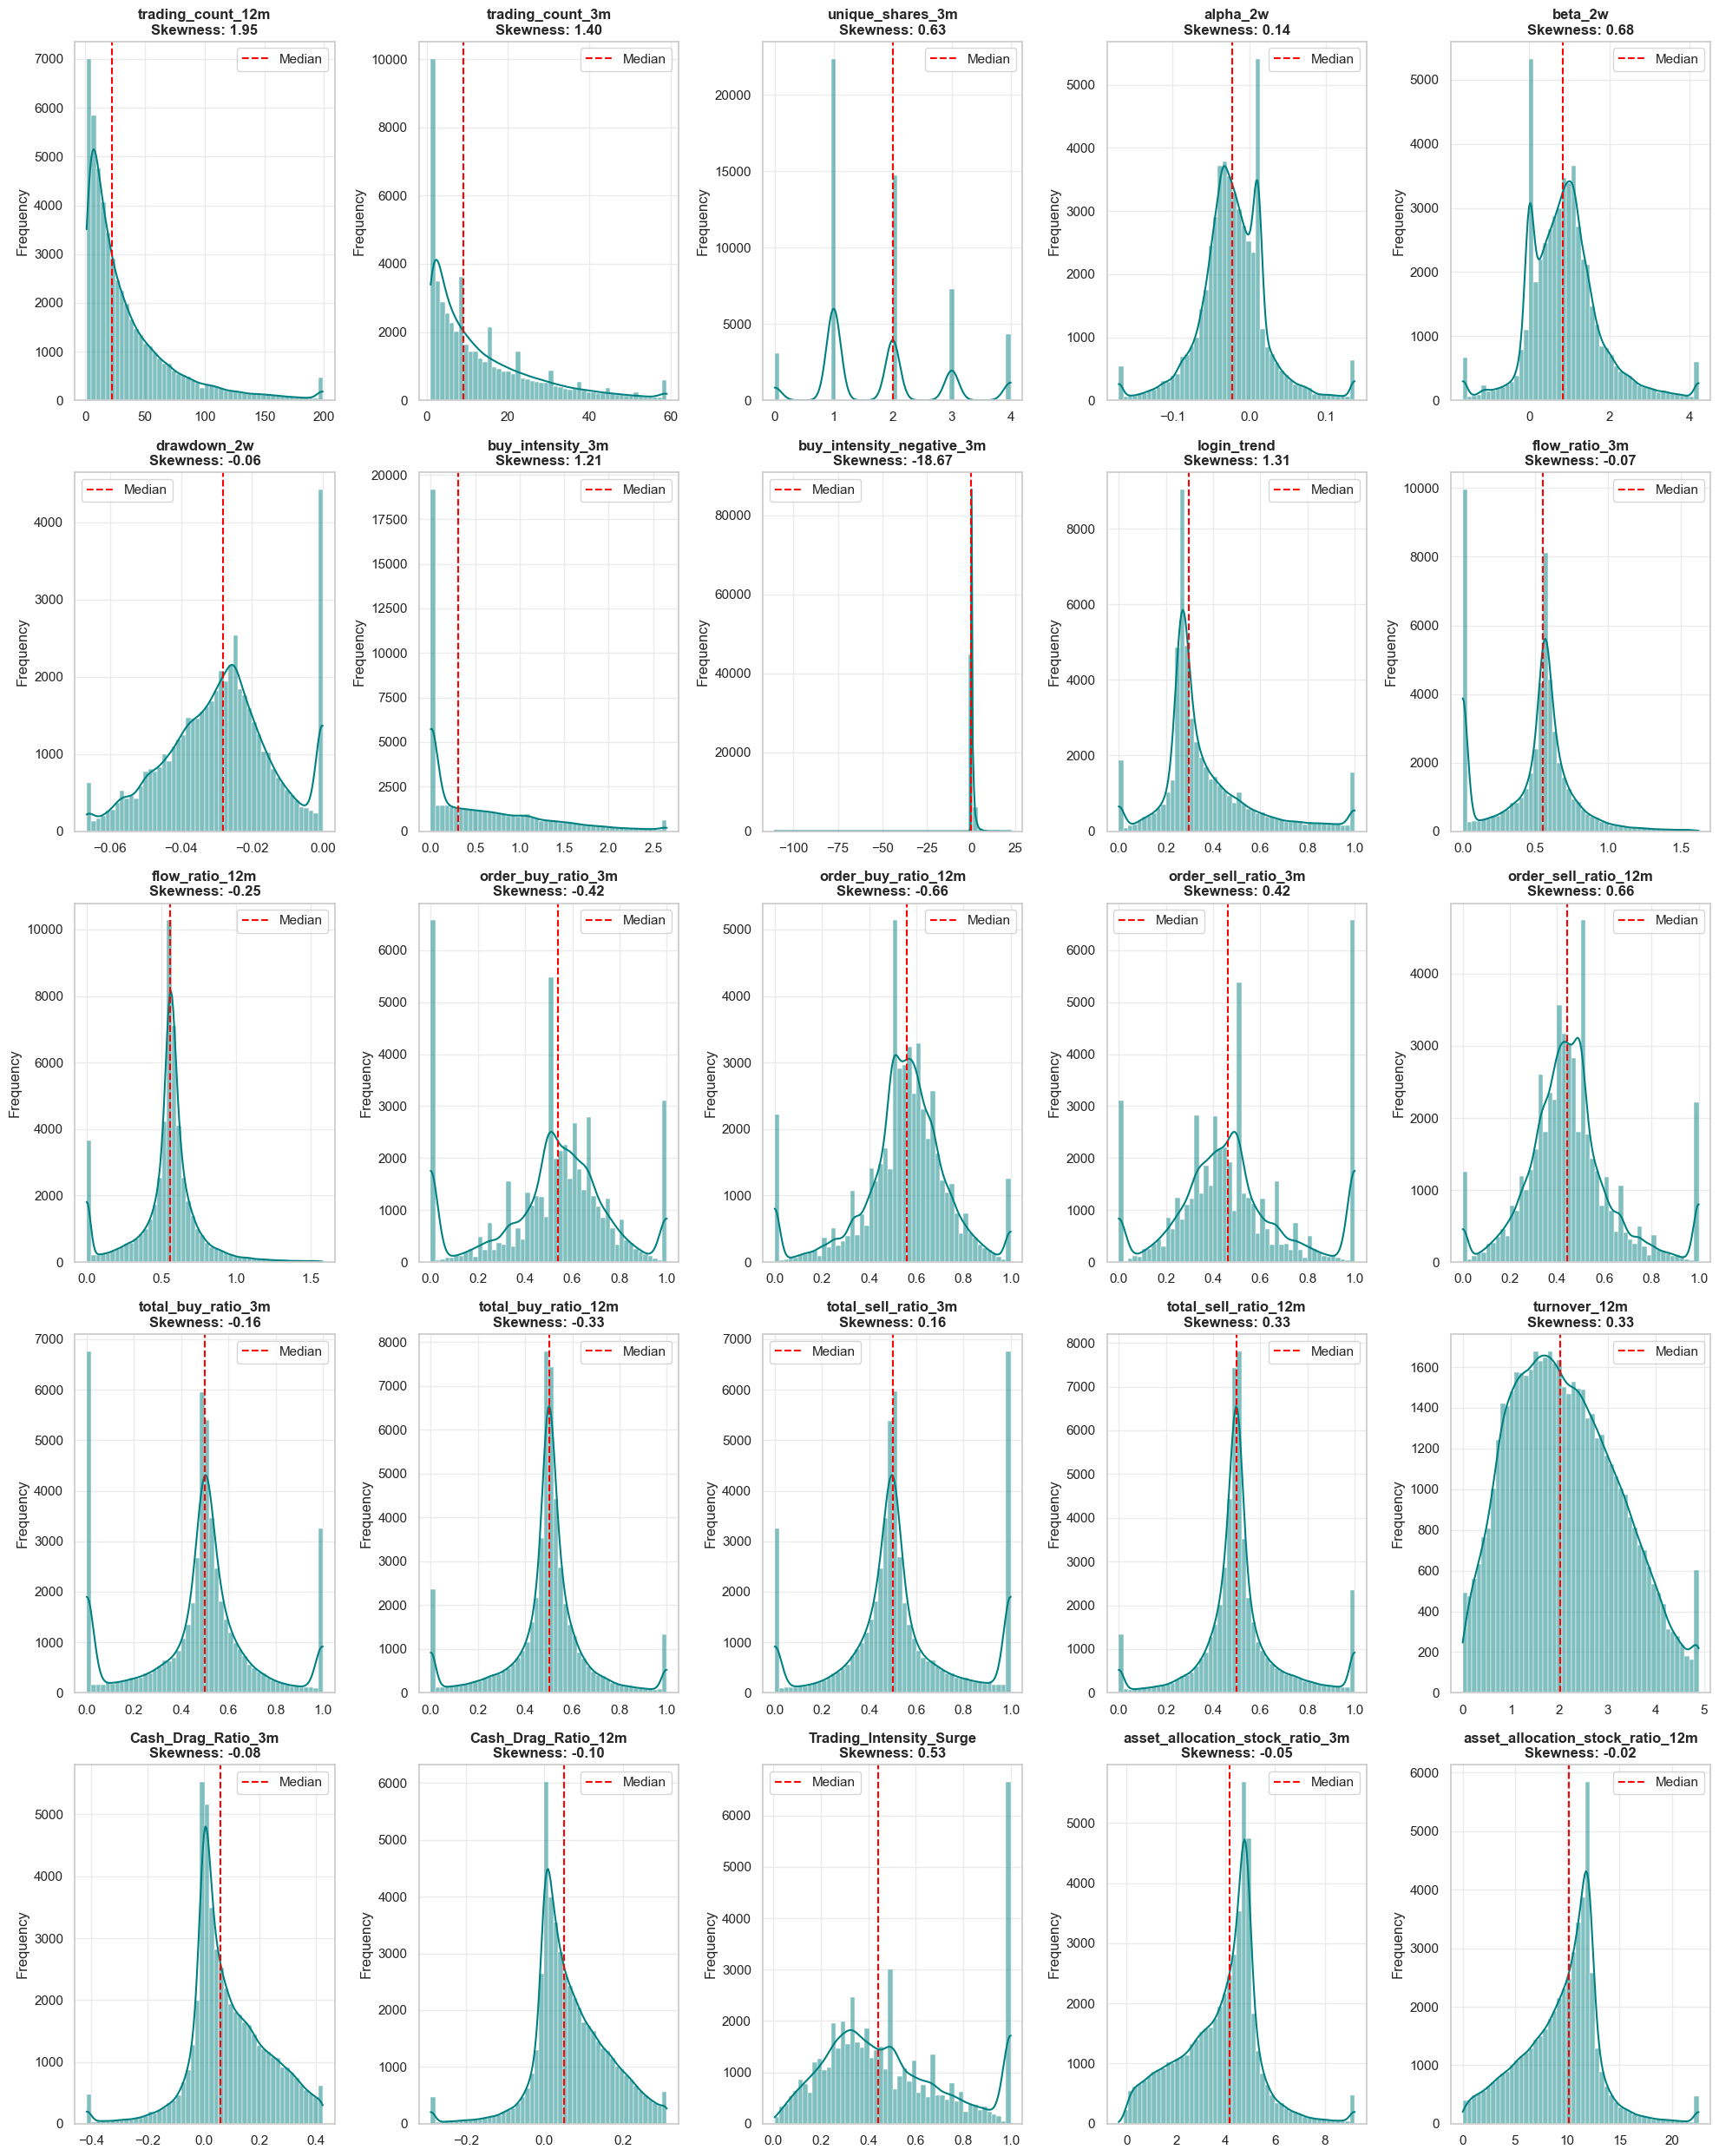

In [235]:
df_clean = df_ready_for_scale.copy()

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

def check_money_distribution(df, cols_to_check):
    """
    Vẽ biểu đồ phân phối và tính độ lệch (Skewness)
    """
    # Lọc các cột thực sự tồn tại trong df
    valid_cols = [c for c in cols_to_check if c in df.columns]
    
    n_cols = 5
    n_rows = (len(valid_cols) + n_cols - 1) // n_cols
    
    plt.figure(figsize=(20, 5 * n_rows))
    
    for i, col in enumerate(valid_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        
        # 1. Vẽ Histogram và đường KDE (Kernel Density Estimate)
        sns.histplot(df[col], kde=True, color='teal', bins=50)
        
        # 2. Tính chỉ số Skewness (Độ lệch)
  
        skew_val = df[col].skew()
        plt.title(f'{col}\nSkewness: {skew_val:.2f}', fontsize=12, fontweight='bold')
        plt.xlabel('')
        plt.ylabel('Frequency')
    
        plt.axvline(df[col].median(), color='red', linestyle='--', label='Median')
        plt.legend()

    plt.tight_layout()
    plt.show()

# --- DANH SÁCH CÁC TRƯỜNG TIỀN TỆ CẦN KIỂM TRA ---
money_cols_to_check = [

     'avg_nav_ck_12m', 'total_trading_amount_12m',
       'trading_count_12m', 'trading_count_3m',
       'unique_shares_3m', 'profit_ratio_12m', 'profit_ratio_3m', 'alpha_2w',
       'beta_2w', 'drawdown_2w', 'buy_intensity_3m',
       'buy_intensity_negative_3m', 'login_trend', 'flow_ratio_3m',
       'flow_ratio_12m', 'order_buy_ratio_3m', 'order_buy_ratio_12m',
       'order_sell_ratio_3m', 'order_sell_ratio_12m', 'total_buy_ratio_3m',
       'total_buy_ratio_12m', 'total_sell_ratio_3m', 'total_sell_ratio_12m',
       'turnover_12m', 'Cash_Drag_Ratio_3m', 'Cash_Drag_Ratio_12m',
       'Trading_Intensity_Surge', 'asset_allocation_stock_ratio_3m',
       'asset_allocation_stock_ratio_12m', 
]


check_money_distribution(df_clean, money_cols_to_check)

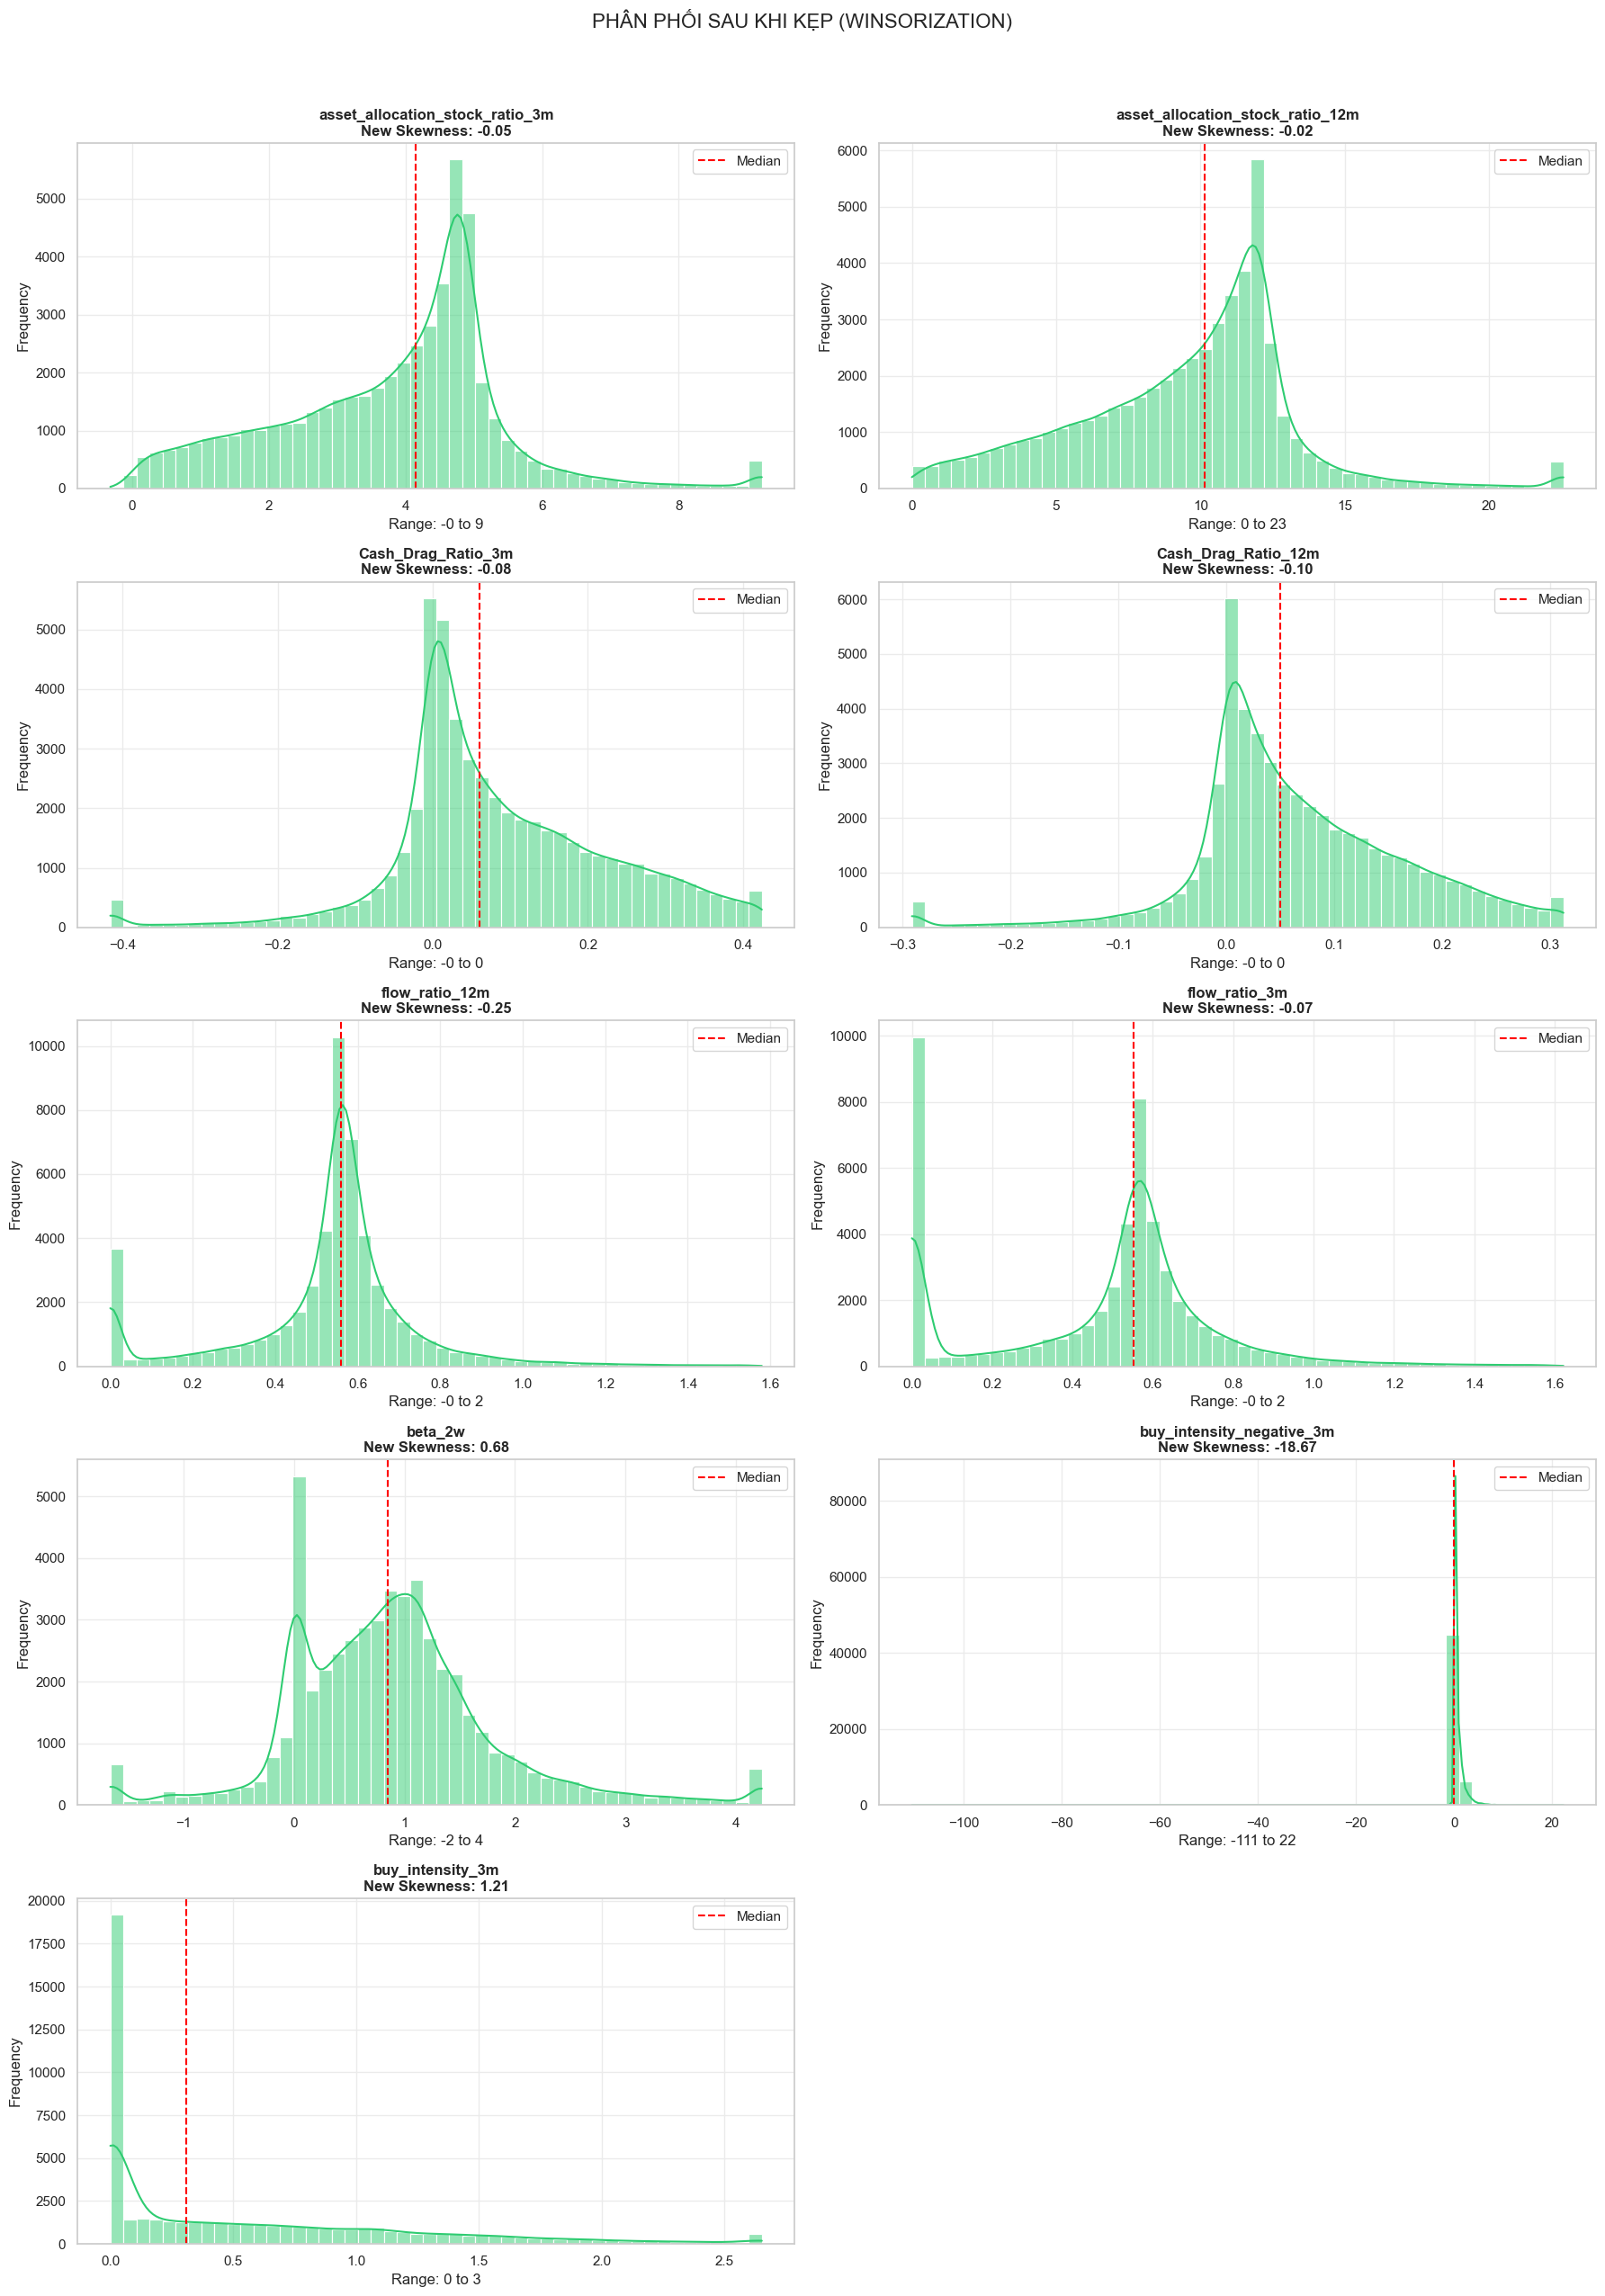

In [216]:
def check_distribution_after_clipping(df, cols_to_check):
    valid_cols = [c for c in cols_to_check if c in df.columns]
    
    n_cols = 2
    n_rows = (len(valid_cols) + n_cols - 1) // n_cols
    
    plt.figure(figsize=(18, 5 * n_rows))
    
    for i, col in enumerate(valid_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        

        sns.histplot(df[col], kde=True, color='#2ecc71', bins=50)
        
        # 2. Tính chỉ số thống kê mới
        new_skew = df[col].skew()
        new_min = df[col].min()
        new_max = df[col].max()
        
        # 3. Trang trí biểu đồ
        plt.title(f'{col}\nNew Skewness: {new_skew:.2f}', fontsize=12, fontweight='bold')
        plt.xlabel(f'Range: {new_min:,.0f} to {new_max:,.0f}') # Hiển thị phạm vi mới
        plt.ylabel('Frequency')
        
        # Thêm đường Median
        plt.axvline(df[col].median(), color='red', linestyle='--', label='Median')
        plt.legend()

    plt.suptitle('PHÂN PHỐI SAU KHI KẸP (WINSORIZATION)', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# --- THỰC THI ---
# Danh sách các biến vừa xử lý
high_skew_cols = [ 'share_pl_pct_3m', 'share_pl_pct_12m','cash_flow_3m','cash_flow_12m','asset_allocation_stock_ratio_3m',
                'asset_allocation_stock_ratio_12m', 'Cash_Drag_Ratio_3m', 'Cash_Drag_Ratio_12m','flow_ratio_12m',
                'flow_ratio_3m', 'order_buy_sell_pressure_3m','profit_ratio_3m','profit_ratio_12m', 'beta_2w', 'buy_intensity_negative_3m', 'buy_intensity_3m']

# df_clean lúc này là df đã chạy đoạn code clip ở bước trước
check_distribution_after_clipping(df_clean, high_skew_cols)

In [217]:
df_clean.loan_label_next.value_counts()

loan_label_next
0    42149
1     9622
Name: count, dtype: int64

In [218]:
df_clean.columns

Index(['loan_label_next', 'trading_count_12m', 'unique_shares_12m',
       'trading_count_3m', 'unique_shares_3m', 'alpha_2w', 'beta_2w',
       'drawdown_2w', 'buy_intensity_3m', 'buy_intensity_negative_3m',
       'login_trend', 'flow_ratio_3m', 'flow_ratio_12m', 'order_buy_ratio_3m',
       'order_buy_ratio_12m', 'order_sell_ratio_3m', 'order_sell_ratio_12m',
       'total_buy_ratio_3m', 'total_buy_ratio_12m', 'total_sell_ratio_3m',
       'total_sell_ratio_12m', 'turnover_12m', 'Cash_Drag_Ratio_3m',
       'Cash_Drag_Ratio_12m', 'Trading_Intensity_Surge',
       'asset_allocation_stock_ratio_3m', 'asset_allocation_stock_ratio_12m',
       'age_group', 'tenure_group'],
      dtype='object')

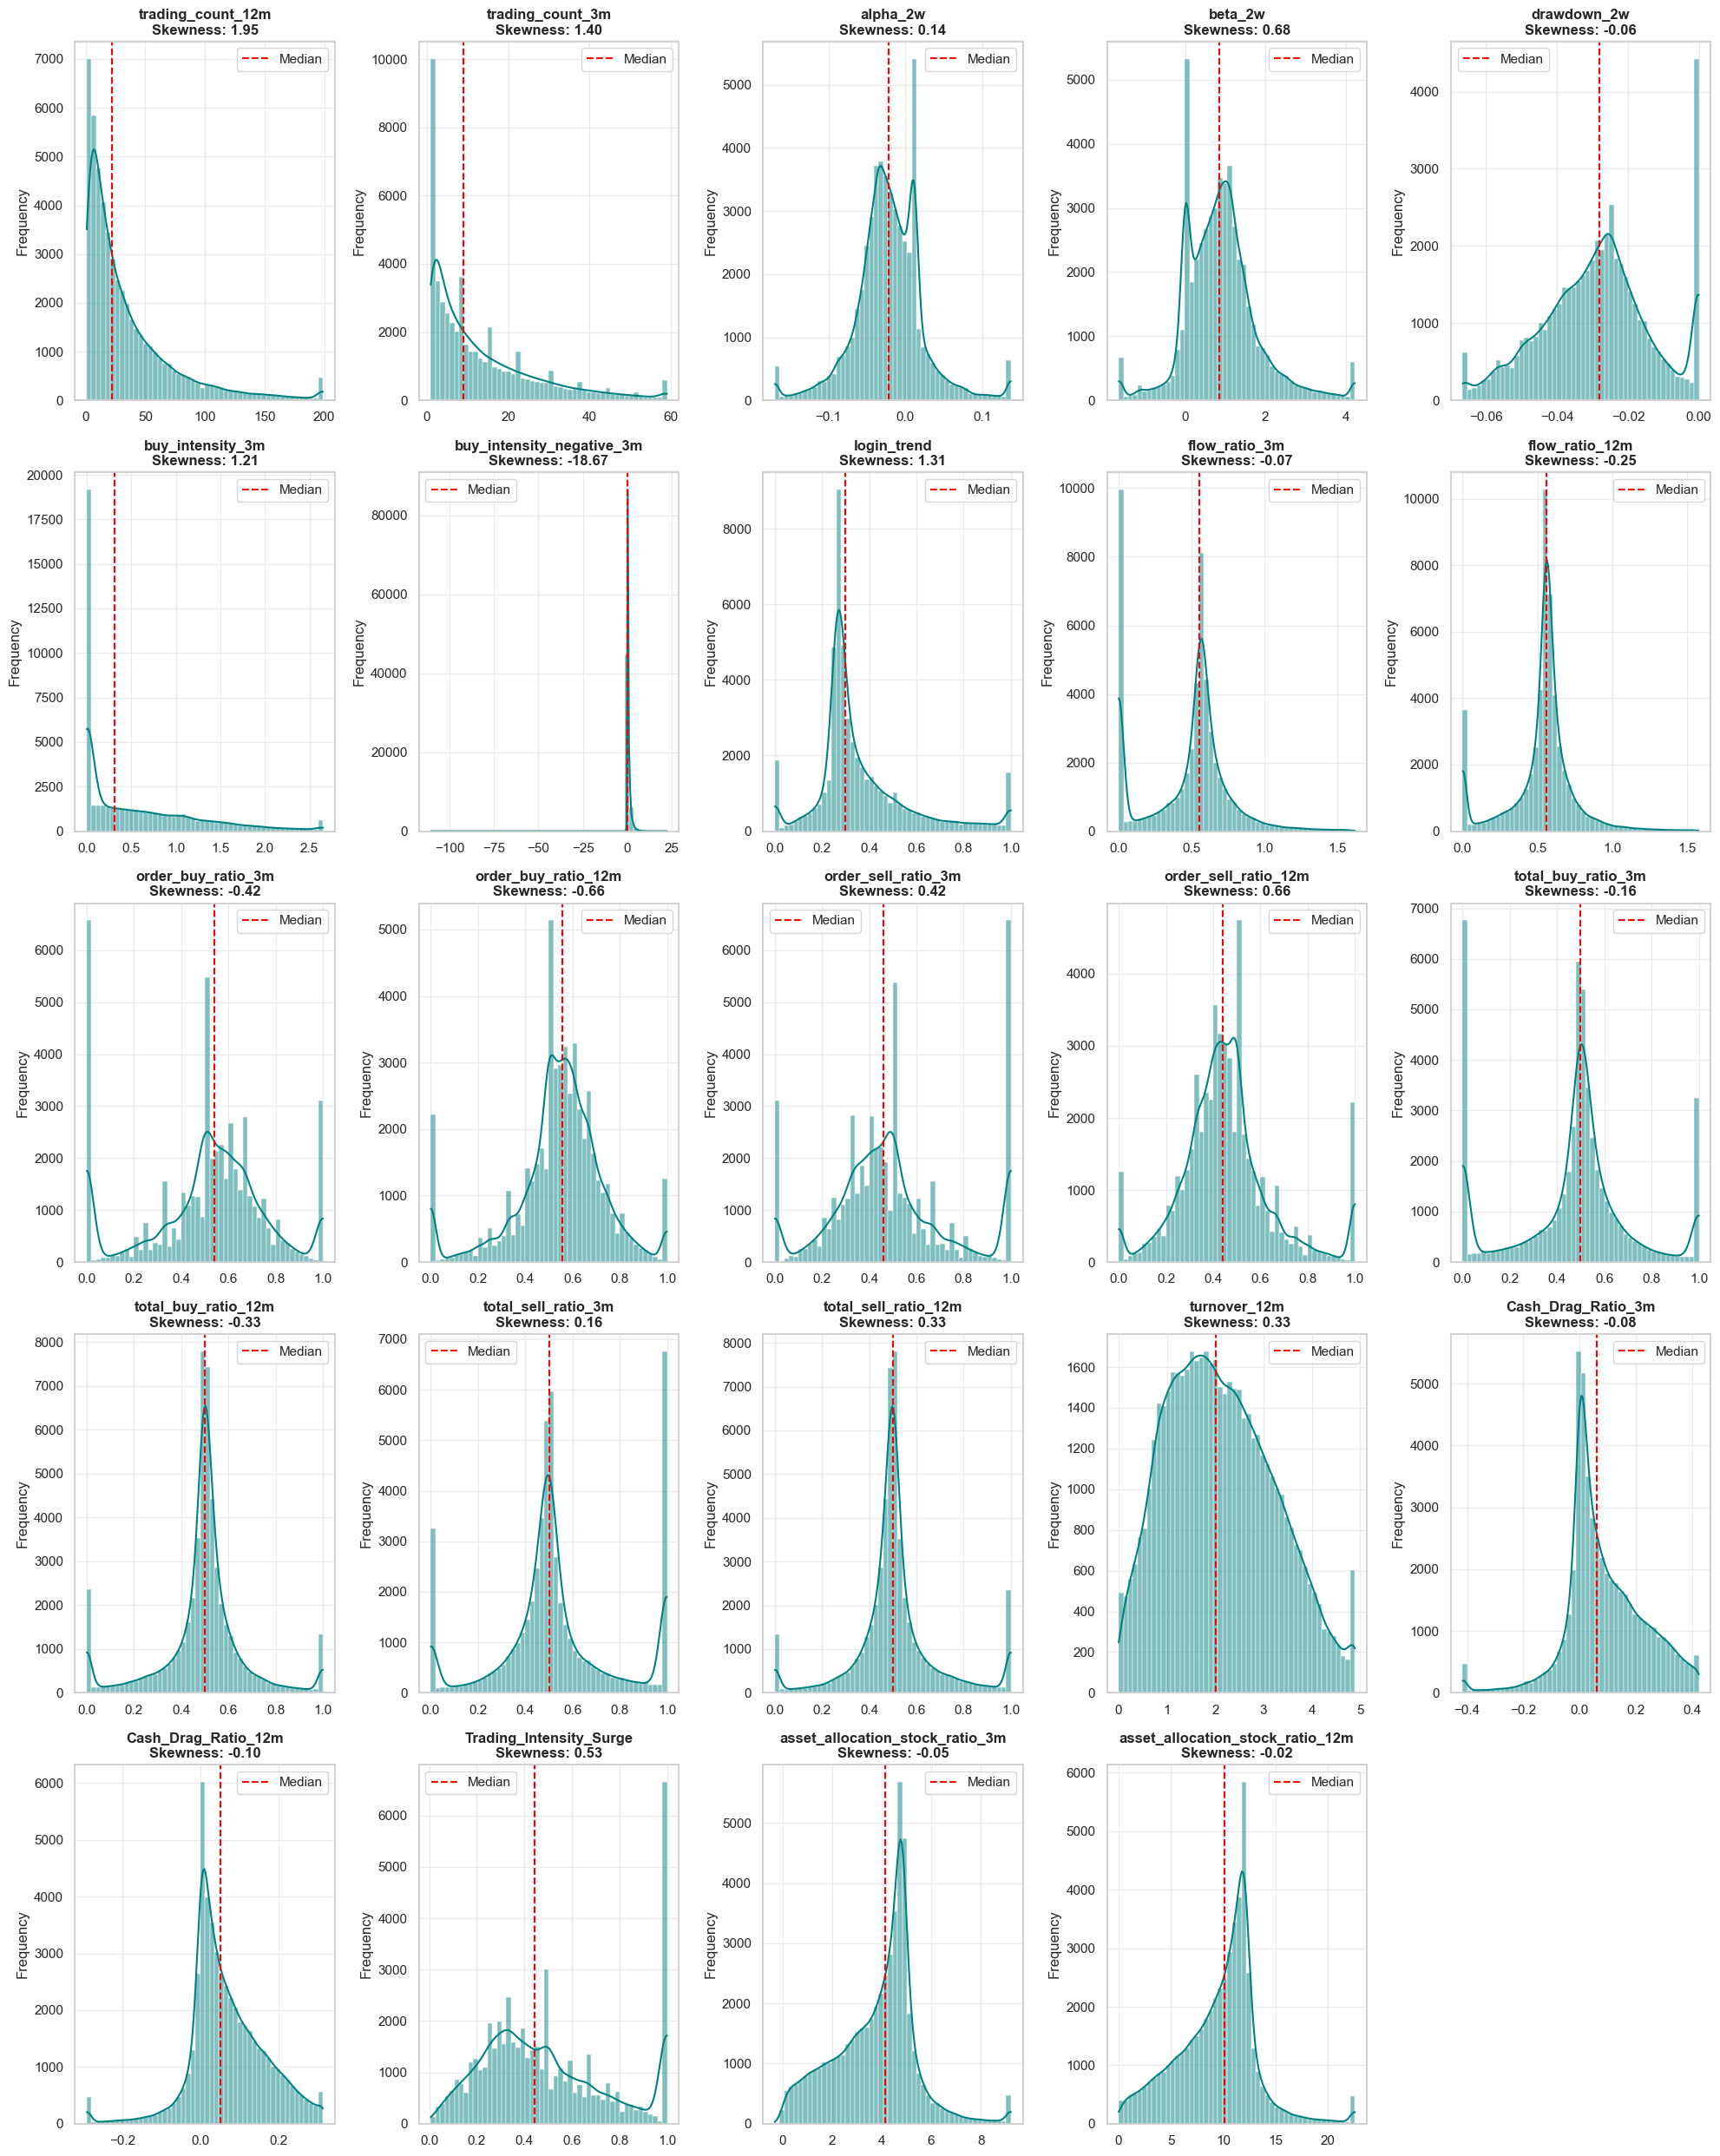

In [236]:


import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

def check_money_distribution(df, cols_to_check):
    """
    Vẽ biểu đồ phân phối và tính độ lệch (Skewness)
    """
    # Lọc các cột thực sự tồn tại trong df
    valid_cols = [c for c in cols_to_check if c in df.columns]
    
    n_cols = 5
    n_rows = (len(valid_cols) + n_cols - 1) // n_cols
    
    plt.figure(figsize=(20, 5 * n_rows))
    
    for i, col in enumerate(valid_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        
        # 1. Vẽ Histogram và đường KDE (Kernel Density Estimate)
        sns.histplot(df[col], kde=True, color='teal', bins=50)
        
        # 2. Tính chỉ số Skewness (Độ lệch)
  
        skew_val = df[col].skew()
        plt.title(f'{col}\nSkewness: {skew_val:.2f}', fontsize=12, fontweight='bold')
        plt.xlabel('')
        plt.ylabel('Frequency')
    
        plt.axvline(df[col].median(), color='red', linestyle='--', label='Median')
        plt.legend()

    plt.tight_layout()
    plt.show()

# --- DANH SÁCH CÁC TRƯỜNG TIỀN TỆ CẦN KIỂM TRA ---
money_cols_to_check = [

       'avg_nav_ck_12m', 'total_trading_amount_12m',
       'trading_count_12m', 'trading_count_3m',
       'profit_ratio_12m', 'profit_ratio_3m', 'alpha_2w',
       'beta_2w', 'drawdown_2w', 'buy_intensity_3m',
       'buy_intensity_negative_3m', 'login_trend', 'flow_ratio_3m',
       'flow_ratio_12m', 'order_buy_ratio_3m', 'order_buy_ratio_12m',
       'order_sell_ratio_3m', 'order_sell_ratio_12m', 'total_buy_ratio_3m',
       'total_buy_ratio_12m', 'total_sell_ratio_3m', 'total_sell_ratio_12m',
       'turnover_12m', 'Cash_Drag_Ratio_3m', 'Cash_Drag_Ratio_12m',
       'Trading_Intensity_Surge', 'asset_allocation_stock_ratio_3m',
       'asset_allocation_stock_ratio_12m',
]


check_money_distribution(df_clean, money_cols_to_check)

### Train test split, scale & handle imbalance data

In [220]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score as f1
from sklearn.metrics import confusion_matrix
X = df_clean.drop(columns=['loan_label_next'])
y = df_clean['loan_label_next']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy= 1/2, random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_scaled, y_train)
y_resampled_counts = pd.Series(y_resampled).value_counts()
count_label_0 = y_resampled_counts.get(0, 0)
count_label_1 = y_resampled_counts.get(1, 0)

print("--- KẾT QUẢ UNDERSAMPLING 2:1 ---")
print(f"Số lượng Label 0 (Đa số mới): {count_label_0:,} mẫu")
print(f"Số lượng Label 1 (Thiểu số): {count_label_1:,} mẫu")
print(f"Tỷ lệ cuối cùng: {count_label_0 / count_label_1:.2f} : 1")


--- KẾT QUẢ UNDERSAMPLING 2:1 ---
Số lượng Label 0 (Đa số mới): 15,394 mẫu
Số lượng Label 1 (Thiểu số): 7,697 mẫu
Tỷ lệ cuối cùng: 2.00 : 1


c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


## Train base

In [221]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from scipy.special import expit
import numpy as np


# K-Fold setup
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Định nghĩa lại X và y cho việc huấn luyện K-Fold
# X_resampled và y_resampled là đầu ra sau khi Undersample
X_final_train = X_resampled 
y_final_train = y_resampled 

# Các model (Giữ nguyên cấu hình bạn đã chọn)
models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=7, min_samples_leaf=6, max_features='sqrt', random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'), 
    "LightGBM": LGBMClassifier(
    random_state=42,
    n_estimators=200,          # Tăng số cây lên nhiều để khai thác learning_rate nhỏ
    learning_rate=0.01,         # Tăng tốc độ học lên 0.01 (thay vì 0.001) để hội tụ nhanh hơn
    max_depth=6,                # Giữ độ sâu vừa phải để chống Overfitting
    colsample_bytree=0.8,       # Sử dụng 80% feature (subsample features)
    subsample=0.8,              # Sử dụng 80% dữ liệu (subsample data)
    reg_alpha=0.1,              # L1 regularization (giúp loại bỏ các feature yếu)
    reg_lambda=0.1,             # L2 regularization (làm mượt model)
    n_jobs=-1                   # Tận dụng tối đa CPU
),
    "CatBoost": CatBoostClassifier(
        verbose=0,
        random_state=42,
        iterations=400, 
        learning_rate=0.01, 
        depth=6, 
        l2_leaf_reg=5.0, 
        subsample=0.8, 
        rsm=0.8, 
        random_strength=1.5, 
        bagging_temperature=1.0
    ),
}

# --- Hàm run_kfold đã điều chỉnh ---
def run_kfold(model, model_name):
    print(f"\n🔍 Đang đánh giá: {model_name} trên tập đã CÂN BẰNG")
    scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}

    # THAY THẾ X_train_scaled VÀ y_train BẰNG X_final_train VÀ y_final_train
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_final_train, y_final_train)): 
        
        # Lấy dữ liệu train và validation
        X_tr, X_val = X_final_train[train_idx], X_final_train[val_idx]
        y_tr, y_val = y_final_train[train_idx], y_final_train[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1]

        scores['accuracy'].append(accuracy_score(y_val, y_pred))
        scores['precision'].append(precision_score(y_val, y_pred))
        scores['recall'].append(recall_score(y_val, y_pred))
        scores['f1'].append(f1_score(y_val, y_pred))
        scores['roc_auc'].append(roc_auc_score(y_val, y_proba))

        print(f" Fold {fold+1}: "
              f"Acc = {scores['accuracy'][-1]:.4f}, "
              f"Prec = {scores['precision'][-1]:.4f}, "
              f"Recall = {scores['recall'][-1]:.4f}, "
              f"F1 = {scores['f1'][-1]:.4f}, "
              f"ROC AUC = {scores['roc_auc'][-1]:.4f}")

    print(f"\n {model_name} - KFold trung bình:")
    for metric, values in scores.items():
        print(f" {metric.capitalize()}: {np.mean(values):.4f}")

# Chạy từng mô hình (K-Fold Evaluation)
for name, model in models.items():
    run_kfold(model, name)

# --- Đánh giá trên tập test cuối cùng ---
print("\n Đánh giá trên tập test cuối cùng:")
for name, model in models.items():
    
    # Huấn luyện trên toàn bộ tập đã cân bằng (X_final_train, y_final_train)
    model.fit(X_final_train, y_final_train) 
    
    # Dự đoán trên tập test GỐC (X_test_scaled, y_test)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    print(f"\n {name} - Test set:")
    print(f" Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
    print(f" Precision: {precision_score(y_test, y_pred):.4f}")
    print(f" Recall:    {recall_score(y_test, y_pred):.4f}")
    print(f" F1 Score:  {f1_score(y_test, y_pred):.4f}")
    print(f" ROC AUC:   {roc_auc_score(y_test, y_proba):.4f}")


🔍 Đang đánh giá: Random Forest trên tập đã CÂN BẰNG
 Fold 1: Acc = 0.8298, Prec = 0.8179, Recall = 0.6299, F1 = 0.7117, ROC AUC = 0.8807
 Fold 2: Acc = 0.8324, Prec = 0.8014, Recall = 0.6608, F1 = 0.7244, ROC AUC = 0.8871
 Fold 3: Acc = 0.8450, Prec = 0.8295, Recall = 0.6732, F1 = 0.7432, ROC AUC = 0.8998
 Fold 4: Acc = 0.8346, Prec = 0.8189, Recall = 0.6465, F1 = 0.7226, ROC AUC = 0.8864
 Fold 5: Acc = 0.8335, Prec = 0.8043, Recall = 0.6617, F1 = 0.7260, ROC AUC = 0.8858

 Random Forest - KFold trung bình:
 Accuracy: 0.8350
 Precision: 0.8144
 Recall: 0.6544
 F1: 0.7256
 Roc_auc: 0.8880

🔍 Đang đánh giá: Logistic Regression trên tập đã CÂN BẰNG
 Fold 1: Acc = 0.8062, Prec = 0.6861, Recall = 0.7721, F1 = 0.7266, ROC AUC = 0.8727
 Fold 2: Acc = 0.8068, Prec = 0.6848, Recall = 0.7791, F1 = 0.7289, ROC AUC = 0.8792
 Fold 3: Acc = 0.8192, Prec = 0.7009, Recall = 0.7979, F1 = 0.7463, ROC AUC = 0.8917
 Fold 4: Acc = 0.8060, Prec = 0.6857, Recall = 0.7713, F1 = 0.7260, ROC AUC = 0.8754
 Fold

c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


 Fold 1: Acc = 0.8320, Prec = 0.8271, Recall = 0.6273, F1 = 0.7134, ROC AUC = 0.8826
[LightGBM] [Info] Number of positive: 6158, number of negative: 12315
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5894
[LightGBM] [Info] Number of data points in the train set: 18473, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333351 -> initscore=-0.693066
[LightGBM] [Info] Start training from score -0.693066


c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


 Fold 2: Acc = 0.8348, Prec = 0.8129, Recall = 0.6550, F1 = 0.7254, ROC AUC = 0.8892
[LightGBM] [Info] Number of positive: 6158, number of negative: 12315
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5894
[LightGBM] [Info] Number of data points in the train set: 18473, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333351 -> initscore=-0.693066
[LightGBM] [Info] Start training from score -0.693066


c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


 Fold 3: Acc = 0.8456, Prec = 0.8380, Recall = 0.6654, F1 = 0.7418, ROC AUC = 0.9044
[LightGBM] [Info] Number of positive: 6158, number of negative: 12315
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5895
[LightGBM] [Info] Number of data points in the train set: 18473, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333351 -> initscore=-0.693066
[LightGBM] [Info] Start training from score -0.693066


c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


 Fold 4: Acc = 0.8352, Prec = 0.8291, Recall = 0.6368, F1 = 0.7203, ROC AUC = 0.8871
[LightGBM] [Info] Number of positive: 6157, number of negative: 12316
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5894
[LightGBM] [Info] Number of data points in the train set: 18473, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333297 -> initscore=-0.693310
[LightGBM] [Info] Start training from score -0.693310


c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


 Fold 5: Acc = 0.8352, Prec = 0.8180, Recall = 0.6506, F1 = 0.7248, ROC AUC = 0.8879

 LightGBM - KFold trung bình:
 Accuracy: 0.8366
 Precision: 0.8250
 Recall: 0.6470
 F1: 0.7251
 Roc_auc: 0.8902

🔍 Đang đánh giá: CatBoost trên tập đã CÂN BẰNG
 Fold 1: Acc = 0.8270, Prec = 0.8065, Recall = 0.6331, F1 = 0.7093, ROC AUC = 0.8822
 Fold 2: Acc = 0.8302, Prec = 0.7970, Recall = 0.6582, F1 = 0.7210, ROC AUC = 0.8880
 Fold 3: Acc = 0.8476, Prec = 0.8343, Recall = 0.6771, F1 = 0.7475, ROC AUC = 0.9028
 Fold 4: Acc = 0.8330, Prec = 0.8132, Recall = 0.6478, F1 = 0.7212, ROC AUC = 0.8888
 Fold 5: Acc = 0.8374, Prec = 0.8119, Recall = 0.6669, F1 = 0.7323, ROC AUC = 0.8904

 CatBoost - KFold trung bình:
 Accuracy: 0.8350
 Precision: 0.8126
 Recall: 0.6566
 F1: 0.7263
 Roc_auc: 0.8904

 Đánh giá trên tập test cuối cùng:

 Random Forest - Test set:
 Accuracy:  0.8778
 Precision: 0.6765
 Recall:    0.6571
 F1 Score:  0.6667
 ROC AUC:   0.8933

 Logistic Regression - Test set:
 Accuracy:  0.8170
 Pre

c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 LightGBM - Test set:
 Accuracy:  0.8805
 Precision: 0.6888
 Recall:    0.6519
 F1 Score:  0.6699
 ROC AUC:   0.8959

 CatBoost - Test set:
 Accuracy:  0.8768
 Precision: 0.6698
 Recall:    0.6649
 F1 Score:  0.6674
 ROC AUC:   0.8953


## Tuning

In [222]:
import numpy as np
import pandas as pd
import optuna
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


X_train_final = X_resampled 
y_train_final = y_resampled 
X_test_final = X_test_scaled 
y_test_final = y_test 

# Ép về NumPy array cho tính nhất quán và tương thích với KFold indexing
X_train_final_np = np.array(X_train_final)
y_train_final_np = np.array(y_train_final)
X_test_final_np = np.array(X_test_final)
y_test_final_np = np.array(y_test_final)


# ====================================================================
# CÁC MODEL VÀ OBJECTIVES CHO OPTUNA
# ====================================================================

models = {
    # --- LIGHTGBM: Tốc độ cao, cần tune kỹ để không Overfit ---
    "lightgbm_optuna": {
        "model": LGBMClassifier,
        "objective": lambda trial: {
            'n_estimators': trial.suggest_int('n_estimators', 200 , 800), # Tăng min lên 200 vì data bạn >10k dòng
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05, log=True), # Log scale để dò kỹ vùng learning rate nhỏ
            'num_leaves': trial.suggest_int('num_leaves', 18, 100),
            'max_depth': trial.suggest_int('max_depth', 4, 10),
            'min_child_samples': trial.suggest_int('min_child_samples', 18, 100), # Quan trọng: Chặn lá quá nhỏ (chống noise)
            'subsample': trial.suggest_float('subsample', 0.6, 0.95), # Bagging fraction
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.95), # Feature fraction
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 5.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 5.0, log=True),
            'random_state': 42,
            'n_jobs': -1,
            'verbose': -1
        }
    },


}

# ====================================================================
# HÀM ĐÁNH GIÁ VÀ TỐI ƯU
# ====================================================================

# Hàm đánh giá mô hình bằng KFold (trên tập đã cân bằng)
def evaluate_model(model, X, y):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}

    for train_idx, val_idx in kf.split(X, y):
        model.fit(X[train_idx], y[train_idx])
        preds = model.predict(X[val_idx])
        probs = model.predict_proba(X[val_idx])[:, 1]

        scores['accuracy'].append(accuracy_score(y[val_idx], preds))
        scores['precision'].append(precision_score(y[val_idx], preds, zero_division=0))
        scores['recall'].append(recall_score(y[val_idx], preds, zero_division=0))
        scores['f1'].append(f1_score(y[val_idx], preds, zero_division=0))
        scores['roc_auc'].append(roc_auc_score(y[val_idx], probs))

    print("\n KFold Evaluation (Tập đã cân bằng):")
    for metric, values in scores.items():
        print(f" {metric}: {np.mean(values):.4f} (+/- {np.std(values):.4f})")

# Hàm tối ưu bằng Optuna
def optimize_model(model_name, model_class, objective_func):
    def objective(trial):
        params = objective_func(trial)
        model = model_class(**params)
        cv_result = cross_validate(
            model,
            X_train_final_np,
            y_train_final_np,
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            scoring='average_precision', 
            n_jobs=-1
        )
        # Mục tiêu: Tối đa hóa ROC AUC trung bình
        return np.mean(cv_result['test_score'])

    print(f"Bắt đầu tối ưu {model_name}...")
    # Tạo study và tối ưu (có thể tăng n_trials lên 50-100 nếu có thời gian)
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=30) 

    print(f"\n Best ROC AUC cho {model_name}: {study.best_value:.4f}")
    best_model = model_class(**study.best_params)
    
    # Huấn luyện mô hình tốt nhất trên toàn bộ tập đã cân bằng
    best_model.fit(X_train_final_np, y_train_final_np) 
    
    # Đánh giá KFold trên tập đã cân bằng
    evaluate_model(best_model, X_train_final_np, y_train_final_np) 

    return {
        "model": best_model,
        "params": study.best_params,
        "best_roc_auc": study.best_value
    }

# ====================================================================
# CHẠY TỐI ƯU VÀ BÁO CÁO KẾT QUẢ
# ====================================================================

best_models = {}
for model_name, model_info in models.items():
    print(f"\n==========================================")
    print(f" Tối ưu: {model_name}")
    print(f"==========================================")
    best_models[model_name] = optimize_model(
        model_name,
        model_info["model"],
        model_info["objective"]
    )

# Classification report trên tập test GỐC (Đánh giá cuối cùng)
print(f"\n\n==========================================")
print(f" BÁO CÁO CUỐI CÙNG TRÊN TẬP TEST GỐC")
print(f"==========================================")

for model_name, info in best_models.items():
    model = info["model"]
    # Dự đoán trên tập Test GỐC (đã scaled)
    y_pred = model.predict(X_test_final_np) 
    
    print(f"\n Classification Report - {model_name}:")
    print(classification_report(y_test_final_np, y_pred, target_names=["Label 0", "Label 1"], zero_division=0))

[I 2026-01-28 10:43:15,907] A new study created in memory with name: no-name-b9a5eba7-bd3f-4a1e-8f9f-9813ecefac3a



 Tối ưu: lightgbm_optuna
Bắt đầu tối ưu lightgbm_optuna...


[I 2026-01-28 10:43:30,909] Trial 0 finished with value: 0.848830083810918 and parameters: {'n_estimators': 348, 'learning_rate': 0.01407423078458252, 'num_leaves': 98, 'max_depth': 8, 'min_child_samples': 18, 'subsample': 0.9251767647281148, 'colsample_bytree': 0.6289784251210491, 'reg_alpha': 0.008170899159888103, 'reg_lambda': 0.06077481033432175}. Best is trial 0 with value: 0.848830083810918.
[I 2026-01-28 10:43:36,000] Trial 1 finished with value: 0.8178732044688488 and parameters: {'n_estimators': 447, 'learning_rate': 0.0011631808051588983, 'num_leaves': 25, 'max_depth': 4, 'min_child_samples': 49, 'subsample': 0.6331893427097874, 'colsample_bytree': 0.8156883525714815, 'reg_alpha': 0.02353791238616177, 'reg_lambda': 1.1115044738416093}. Best is trial 0 with value: 0.848830083810918.
[I 2026-01-28 10:43:55,902] Trial 2 finished with value: 0.8464868549008685 and parameters: {'n_estimators': 778, 'learning_rate': 0.004066684141611177, 'num_leaves': 95, 'max_depth': 10, 'min_chil


 Best ROC AUC cho lightgbm_optuna: 0.8498
[LightGBM] [Info] Number of positive: 7697, number of negative: 15394
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5895
[LightGBM] [Info] Number of data points in the train set: 23091, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 6157, number of negative: 12315
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002536

c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 6158, number of negative: 12315
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5894
[LightGBM] [Info] Number of data points in the train set: 18473, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333351 -> initscore=-0.693066
[LightGBM] [Info] Start training from score -0.693066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 6158, number of negative: 12315
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5894
[LightGBM] [Info] Number of data points in the train set: 18473, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333351 -> initscore=-0.693066
[LightGBM] [Info] Start training from score -0.693066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 6158, number of negative: 12315
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5895
[LightGBM] [Info] Number of data points in the train set: 18473, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333351 -> initscore=-0.693066
[LightGBM] [Info] Start training from score -0.693066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 Classification Report cho mô hình: lightgbm_optuna

[TEST]
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      8430
           1       0.67      0.70      0.68      1925

    accuracy                           0.88     10355
   macro avg       0.80      0.81      0.80     10355
weighted avg       0.88      0.88      0.88     10355



c:\Users\Admin\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


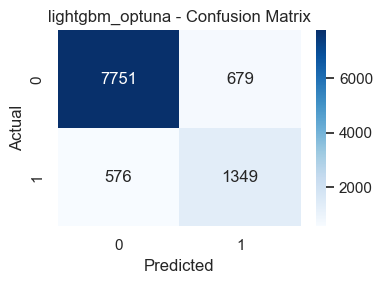

In [223]:
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(cm, title, labels=["0", "1"]):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()

    plt.show()

# Lặp qua từng mô hình trong best_models
for name, model_info in best_models.items():
    model = model_info["model"]  # Lấy actual model đã được fit

    print(f"\n Classification Report cho mô hình: {name}")
    
    # Predict
    y_pred_test = model.predict(X_test_scaled)

    # In classification report
    print("\n[TEST]")
    print(classification_report(y_test, y_pred_test, zero_division=0))

    # Vẽ Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_test)
    plot_confusion_matrix(cm, title=f"{name} - Confusion Matrix")

### Save model

In [224]:
import pickle
import os 
from lightgbm import LGBMClassifier # Cần import lại class này nếu chưa import

# Giả định: 
# 1. Quá trình tối ưu đã chạy xong và biến best_models đã được điền.
# 2. X_train_final_np và y_train_final_np đã được định nghĩa và sử dụng.

# Lấy đối tượng mô hình LightGBM tốt nhất đã được huấn luyện
# Nó nằm trong dictionary best_models dưới key 'lightgbm_optuna' và là giá trị của key 'model'
best_lgbm_model = best_models["lightgbm_optuna"]["model"]
# get datetime


# --- Lưu mô hình ---
file_name = "lightgbm_optuna_best_model_recall_70.pkl"

try:
    with open(file_name, "wb") as f:
        pickle.dump(best_lgbm_model, f)
        
    print(f"✅ Mô hình LightGBM (Optuna) đã được lưu thành công vào '{file_name}'.")
    # Bạn cũng có thể lưu các mô hình khác (Random Forest, CatBoost) tương tự nếu muốn
    
    # In ra đường dẫn tuyệt đối để dễ dàng tìm thấy file
    print(f"Đường dẫn lưu: {os.path.abspath(file_name)}")
    
except Exception as e:
    print(f"❌ Lỗi xảy ra trong quá trình lưu mô hình: {e}")

✅ Mô hình LightGBM (Optuna) đã được lưu thành công vào 'lightgbm_optuna_best_model_recall_70.pkl'.
Đường dẫn lưu: D:\diệu ổ D\MBS\model_predict_who_mr_loan_next_m\version_2\Data\lightgbm_optuna_best_model_recall_70.pkl


In [225]:
with open("scaler_v1_recall_70.pkl", "wb") as f:
    pickle.dump(scaler, f)

# 2. Lưu feature order (list)
feature_order = list(X_train.columns)
with open("feature_order_v1_recall_70.pkl", "wb") as f:
    pickle.dump(feature_order, f)

### Feature importance 

--- ĐANG LOAD CÁC FILE .PKL ---
✅ Đã load Model LightGBM.
✅ Đã load danh sách 28 features.
✅ Đã load Scaler.

--- TOP 10 FEATURE QUAN TRỌNG NHẤT ---
                    Feature  Importance
5                   beta_2w        1510
20             turnover_12m        1492
7          buy_intensity_3m        1484
6               drawdown_2w        1338
0         trading_count_12m        1335
9               login_trend        1285
4                  alpha_2w        1182
23  Trading_Intensity_Surge        1167
22      Cash_Drag_Ratio_12m        1076
21       Cash_Drag_Ratio_3m         983


C:\Users\Admin\AppData\Local\Temp\ipykernel_15500\1877755904.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


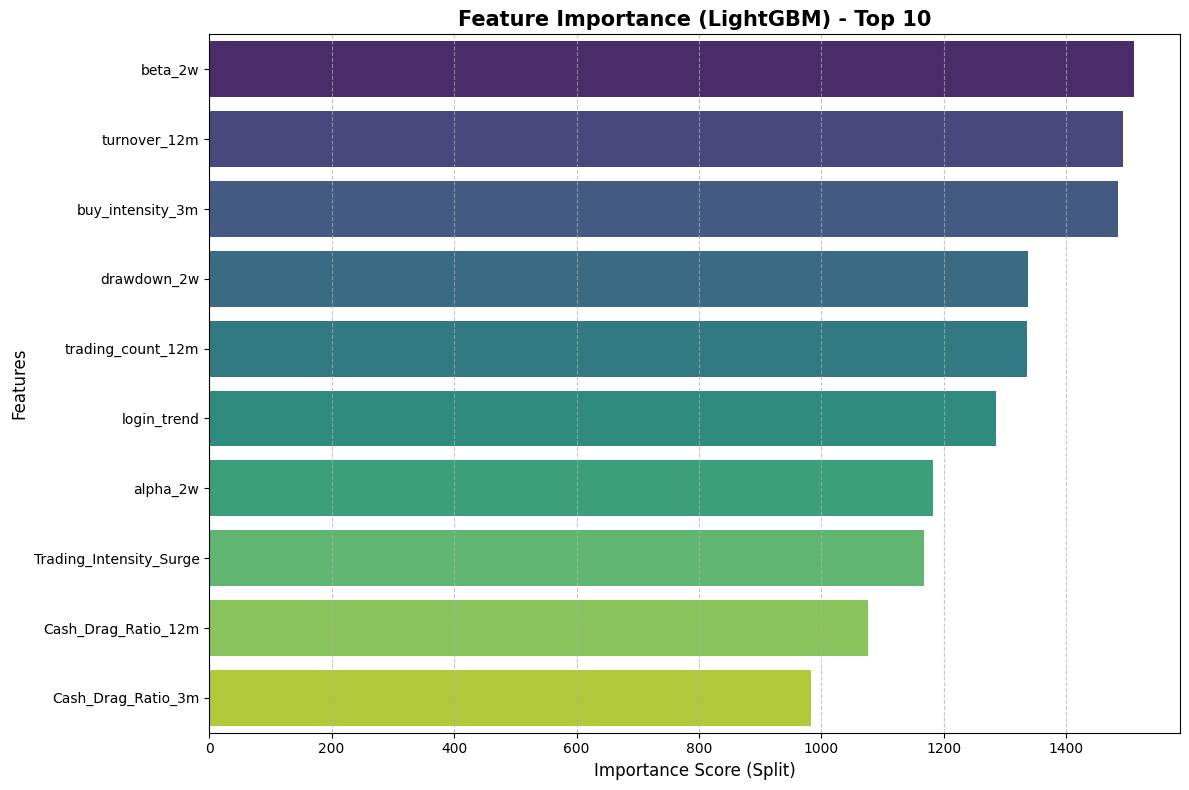

In [5]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# 1. LOAD CÁC FILE ĐÃ LƯU (.pkl)
# ==============================================================================
print("--- ĐANG LOAD CÁC FILE .PKL ---")

try:
    # A. Load Model LightGBM
    with open("lightgbm_optuna_best_model_recall_70.pkl", "rb") as f:
        loaded_model = pickle.load(f)
    print("✅ Đã load Model LightGBM.")

    # B. Load Feature Order (Danh sách tên cột)
    # RẤT QUAN TRỌNG: Vì model train trên numpy array (đã mất tên cột), 
    # ta cần list này để map lại tên.
    with open("feature_order_v1_recall_70.pkl", "rb") as f:
        feature_names = pickle.load(f)
    print(f"✅ Đã load danh sách {len(feature_names)} features.")
    
    # C. Load Scaler (Để kiểm tra thôi, không dùng vẽ biểu đồ)
    with open("scaler_v1_recall_70.pkl", "rb") as f:
        loaded_scaler = pickle.load(f)
    print("✅ Đã load Scaler.")

except Exception as e:
    print(f"❌ Lỗi khi load file: {e}")
    # Dừng chương trình nếu lỗi
    raise e

# ==============================================================================
# 2. TRÍCH XUẤT VÀ VẼ FEATURE IMPORTANCE
# ==============================================================================

def plot_feature_importance(model, feature_list, top_n=20):
    """
    Hàm vẽ biểu đồ tầm quan trọng của biến từ model LightGBM/XGBoost/RF
    """
    # 1. Lấy giá trị importance
    # Với LightGBM sklearn API, mặc định feature_importances_ là kiểu "split" (số lần chia)
    # Nếu muốn kiểu "gain" (lượng thông tin mang lại), cần truy cập booster
    importances = model.feature_importances_
    
    # Kiểm tra khớp độ dài
    if len(importances) != len(feature_list):
        print(f"⚠️ CẢNH BÁO: Số lượng biến trong model ({len(importances)}) "
              f"khác với danh sách tên biến ({len(feature_list)}).")
        return

    # 2. Tạo DataFrame để dễ sắp xếp
    feature_imp_df = pd.DataFrame({
        'Feature': feature_list,
        'Importance': importances
    })

    # 3. Sắp xếp giảm dần
    feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)
    
    # 4. Hiển thị Top N ra màn hình console
    print(f"\n--- TOP {top_n} FEATURE QUAN TRỌNG NHẤT ---")
    print(feature_imp_df.head(top_n))

    # 5. Vẽ biểu đồ
    plt.figure(figsize=(12, 8))
    sns.barplot(
        x='Importance', 
        y='Feature', 
        data=feature_imp_df.head(top_n), # Chỉ vẽ top N
        palette='viridis'
    )
    
    plt.title(f'Feature Importance (LightGBM) - Top {top_n}', fontsize=15, fontweight='bold')
    plt.xlabel('Importance Score (Split)', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    return feature_imp_df

# --- THỰC THI ---
df_importance = plot_feature_importance(loaded_model, feature_names, top_n=10)